# Obesity treatment prediction
Author - Danilov Sergey

## Libraries load

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
import graphviz
import os

# ML
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay, LeaveOneOut, KFold, GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lars, Ridge, Lasso
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error, make_scorer, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, jaccard_score, average_precision_score
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay

# from fedot.api.main import Fedot

# Stats
from scipy.stats import kstest, norm, spearmanr, pearsonr, chi2_contingency, chisquare, fisher_exact, barnard_exact, ks_2samp, ttest_ind, mannwhitneyu
import shap
import xgboost


# Setups
import warnings
warnings.filterwarnings("ignore")
generate_path = lambda m: f"model_{m.__class__.__name__}_{datetime.now().strftime('%d_%m_%y')}.pkl"
pd.options.display.float_format = '{:,.4f}'.format


/var/folders/hm/db57hs3d7313sy_mhv1yl8680000gp/T/ipykernel_20155/95966987.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'tqdm'

In [ ]:
def prepare_dir(name):
  import os
  if not os.path.exists(name):
    os.mkdir(name)
  else:
    import shutil
    shutil.rmtree(name)
    os.mkdir(name)

## Data Load

Загружаем датасет Алмазова

In [ ]:
dataset_path = "/content/ALMAZOV_dataset.xlsx"
if (not os.path.exists(dataset_path)):
  !gdown 1G3-HmI67zesBYZadd2khZLc3EMLgy9Se -O ALMAZOV_dataset.xlsx
full_dataset = pd.read_excel(dataset_path)
dataset = full_dataset.copy()
dataset.head(5)

Downloading...
From: https://drive.google.com/uc?id=1G3-HmI67zesBYZadd2khZLc3EMLgy9Se
To: /content/ALMAZOV_dataset.xlsx
100% 494k/494k [00:00<00:00, 74.6MB/s]


ID  Пол 0 - М, 1 - Ж  Выполняли ли ПЭТ 0- нет, 1 - да  \
0  SIB001                 1                                1   
1  SIB002                 1                                1   
2  SIB003                 1                                1   
3  SIB004                 0                                1   
4  SIB005                 1                                1   

   Наличие БЖТ исходно по ПЭТ 0 -нет, 1 - да  \
0                                     0.0000   
1                                     1.0000   
2                                     0.0000   
3                                     0.0000   
4                                     0.0000   

   Наличие БЖТ  через 6 мес по ПЭТ 0 -нет, 1 - да  Возраст  Рост  Вес 0 мес  \
0                                             NaN       39   160   101.0000   
1                                          0.0000       47   167   100.0000   
2                                          0.0000       44   164    89.0000   
3                                          0.0000       31   178   124.0000   
4                                          1.0000       30   161   102.0000   

   Вес 3 мес  Вес 6 мес  ...  \
0   101.0000        NaN  ...   
1    90.0000    90.0000  ...   
2    78.0000    80.0000  ...   
3   115.0000   109.0000  ...   
4    98.0000    96.0000  ...   

   Ограничительное (Диетическое) пищевое поведение В2.  \
0                                                NaN     
1                                             2.8000     
2                                             3.8000     
3                                             3.4000     
4                                             3.6000     

   Насколько голодным вы себя чувствуете? В2.  \
0                                         NaN   
1                                      2.0000   
2                                      3.0000   
3                                      2.0000   
4                                      0.0000   

   Насколько сытым вы себя чувствуете? В2.  \
0                                      NaN   
1                                   7.0000   
2                                   7.0000   
3                                   8.0000   
4                                   8.0000   

   Насколько сильно вы хотите есть? В2.  \
0                                   NaN   
1                                2.0000   
2                                2.0000   
3                                2.0000   
4                                0.0000   

   Сколько пищи вы могли бы сейчас съесть? В2.  Никотин В2.  Алкоголь В2.  \
0                                          NaN          NaN           NaN   
1                                       5.0000       0.0000        2.0000   
2                                       2.0000       0.0000        2.0000   
3                                       1.0000       7.0000        1.0000   
4                                       0.0000       0.0000        6.0000   

   EQ-5 В2.  Депрессия В1..1  Тревога В2.  
0       NaN              NaN          NaN  
1   70.0000           5.0000       9.0000  
2   70.0000           0.0000       3.0000  
3   45.0000          14.0000      10.0000  
4   90.0000           0.0000       3.0000  

[5 rows x 313 columns]

In [ ]:
if not os.path.exists("ttests"):
  os.mkdir("ttests")
prepare_dir("chisquare")
prepare_dir("correlation")

## Preproceeesing

Было решено соединить методы лечения VBD STD в общую STD как метод лечения диетой

In [ ]:
medicines = {
    'STD': 'Диета',
    'SIB': 'Сибутрамин',
    'SAX': 'Лираглутид'
}

parameters_truncated = {
    'Глюкоза крови натощак ммоль/л (3,3-6,1) 0 мес': "Глюкоза",
    'Пол 0 - М, 1 - Ж': 'Пол',
    'Степень Ожир': 'Степень ожирения',
    'Инсулин пкмоль/л (17.80 - 173.00) перемножить 6,945 0 мес': 'Инсулин',
    'Индекс HOMA-IR (> 3) 0 мес': 'HOMA-IR',
    'Индекс HOMA-В (20×инсулин плазмы натощак (мкЕд/мл)/глюкозы плазмы натощак (ммоль/л)-3,5 ) 0 мес': 'HOMA-B',
    'ОХС ммоль/л (3,5-5,0) 0 мес': 'OXC',
    'Мочевая кислота ммоль/л (0.14 - 0.34) 0 мес': 'Мочевая Кислота',
    'ЛПВП ммоль/л (Ж >1.20, М>1.0) 0 мес': 'ЛПВП',
    'ЛПНП ммоль/л (<3.00) 0 мес': 'ЛПНП',
    'ТГ ммоль/л (<1.77) 0 мес': 'ТГ',
    'КА (0-3,5) 0 мес': 'КА',
    'С-РБ мг/л (0-6) 0 мес': 'СРБ',
    'Эмоциональное пищевое поведение В1.': 'Эмоциональное ПП',
    'Экстернальное пищевое поведение В1.': 'Экстернальное ПП',
    'Ограничительное (Диетическое) пищевое поведение В1.': 'Диетическое ПП',
    'Насколько голодным вы себя чувствуете? В1.': 'Голод',
    'Насколько сытым вы себя чувствуете? В1.': 'Сытость',
    'Насколько сильно вы хотите есть? В1.': 'Степень желания поесть',
    'Сколько пищи вы могли бы сейчас съесть? В1.': "Сколько может сьесть",
    'EQ-5 В1.': 'EQ-5',
    'Депрессия В1.': 'Депрессия',
    'Тревога В1.': 'Тревога',
    'НТГ (нарушнгин толерантности к глюкозе)': 'НТГ',
    'МЗО=0/МНО=1 V3 (Мейгц)': 'МЗО/МНО_V3',
    'Стаж ожирения (1 - до 5 лет, 2 5-10 лет, 3 - более 10 лет': 'Стаж ожирения',
    'Фенотип ожирения - 0 - Центральное ожирение, 1 - Периферическое ожирение, более 0,9 у мужчин и 0,85 у женщин – центральное ожиренрие, менее периферическое': 'Фенотип ожирения',
    'Артериальная гипертензия': 'Артериальная гипертензия',
    'Дислипидемия': 'Дислипидемия'
}

parameters = [
    'Лечение',
    'Пол',
    'Возраст',
    'Рост',
    'Степень ожирения',
    'Стаж ожирения',
    'САД',
    'ДАД',
    'Пульс',
    'Глюкоза',
    'Инсулин',
    'HOMA-IR',
    'HOMA-B',
    'OXC',
    'Мочевая Кислота',
    'ЛПВП',
    'ЛПНП',
    'ТГ',
    'КА',
    'СРБ',
    'Вес 0 мес',
    'ОТ 0 мес',
    'ОБ 0 мес',
    'ОТ/ОБ 0 мес',
    'ИМТ 0 мес',
    'Эмоциональное ПП',
    'Экстернальное ПП',
    'Диетическое ПП',
    'Голод',
    'Сытость',
    'Степень желания поесть',
    'Сколько может сьесть',
    'EQ-5',
    'Депрессия',
    'Тревога',
    'НТГ',
    'Артериальная гипертензия',
    'Дислипидемия',
    'Фенотип ожирения',
    'МЗО/МНО_V3']


initial_columns = [
    'Вес 0 мес',
    'ОТ 0 мес',
    'ОБ 0 мес',
    'ОТ/ОБ 0 мес',
    'ИМТ 0 мес'
]

targets = [
    '% потери веса 3 мес',
    '% потери веса 6 мес',
    'Вес 3 мес',
    'Вес 6 мес',
    # 'ОТ 3 мес',
    # 'ОТ/ОБ 3 мес',
    # 'ОТ/ОБ 6 мес',
    # 'ОТ 6 мес',
    # 'ОБ 3 мес',
    # 'ОБ 6 мес',

]

medicine_keys = [
    "SIB",
    "STD",
    "SAX"
]

discret_params = ['НТГ',
      'Голод',
      'МЗО/МНО_V3',
      'Степень ожирения',
      'Тревога',
      'Пол',
      'Артериальная гипертензия',
      'Депрессия',
      'Сколько может сьесть',
      'Степень желания поесть',
      'Дислипидемия',
      'Экстернальное ПП',
      'Эмоциональное ПП',
      'Диетическое ПП',
      'Стаж ожирения',
      'Фенотип ожирения',
      'Сытость']

categorical_param = [
    'Пол',
    'Артериальная гипертензия',
    'Дислипидемия',
    'Фенотип ожирения'
]

percent_targets = [
    '% потери веса 3 мес',
    '% потери веса 6 мес'
]

weigth_target = [
    'Вес 3 мес',
    'Вес 6 мес'
]

continious_cols = ["Глюкоза",
                   "ЛПНП",
                   "Инсулин",
                   "ЛПВП",
                   "HOMA-IR",
                   "КА",
                   "СРБ",
                   "HOMA-B",
                   "Мочевая Кислота",
                   "OXC"]

discret_params = ["Тип ПП 0 - нет нарушений, 1 - эмоциогенное, 2 - экстернальное, 3 - ограничительное",
                  "ГПП-1 после нагрузки 0 - норма и выше, 1 снижение","В-Блокаторы", "МЗО=0/МНО=1",
                  "Стаж ожирения", "Степень ожирения", "Пол", "Нарушение экстернального ПП 0 - нет, 1 - да",
                  "Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рост2 повышен, 2 - ММЛЖ/рост2,7 повышен, 3 - ОЛП и ММЛЖ повышены",
                  "Лептинрезистентность 0 - повышение лептина, 1 - снижение лептина, 2 - лептин не изменялся", "Сартаны",
                  "Дислипидемия", "Артериальная гипертензия"]

agroup_parameters = list(set(initial_columns+parameters+targets))


In [ ]:
dataset["Лечение"] = dataset["ID"].apply(lambda x: x[:3])
dataset.loc[dataset["Лечение"]=="VBD", "Лечение"] = "STD"
dataset = dataset.drop((dataset[dataset["Лечение"]=="Red"]).index)
dataset = dataset.drop("ID", 1)

dataset.columns = list(map(lambda x: x.strip(), dataset.columns))
dataset.columns = list(map(lambda x: " ".join(x.split()), dataset.columns))
dataset.columns = list(map(lambda i: parameters_truncated[i] if i in parameters_truncated else i, dataset.columns))

dataset["% потери веса 3 мес"] = (((dataset["Вес 0 мес"]-dataset["Вес 3 мес"])/dataset["Вес 0 мес"]))*100
dataset["% потери веса 6 мес"] = (((dataset["Вес 0 мес"]-dataset["Вес 6 мес"])/dataset["Вес 0 мес"]))*100
dataset[dataset["ИМТ 0 мес"].isna()]["ИМТ 0 мес"] = (dataset[dataset["ИМТ 0 мес"].isna()]["Вес 0 мес"]
                                                     / dataset[dataset["ИМТ 0 мес"].isna()]["Рост"]**2).round()
dataset = dataset.loc[~pd.isna(dataset['Вес 3 мес']) | ~pd.isna(dataset['Вес 6 мес'])]
errors = ["101,,3", "1,87,54", "0,,38"]
cols = dataset.columns[(dataset.isin(errors)).any()]
for col in cols:
  dataset.loc[dataset[col]=="101,,3", col] = 101.3
  dataset.loc[dataset[col]=="1,87,54", col] = 1.8754
  dataset.loc[dataset[col]=="0,,38", col] = 0.38
dataset["Мочевая Кислота"] = dataset["Мочевая Кислота"].astype(float)

## Анализ распределения колонок через хи-квадрат

In [ ]:
def get_conditions(dataset_x, threshold=5):
  conditions = {
      "A": (dataset_x["% потери веса 3 мес"]>threshold),
      "B": (dataset_x[~pd.isna(dataset_x["% потери веса 6 мес"])]["% потери веса 6 мес"]>threshold),
      'C': (np.nanmax(dataset_x[["% потери веса 3 мес","% потери веса 6 мес"]], axis=1)>threshold),
      'D': (dataset_x["% потери веса 3 мес"]>threshold)&(dataset_x["% потери веса 6 мес"]>threshold)
  }
  return conditions

def test_chisquare(medicine="SAX"):
  global dataset
  dataset_x = dataset.copy()
  stats = []
  for i in range(5,  15):
    for j in ["A", "B", "C", "D"]:
      conditions = get_conditions(dataset_x, threshold=i)
      dataset_x["success"] = conditions[j]
      dataset_x = dataset_x[dataset_x["Лечение"]==medicine]
      for col in dataset_x.columns:
        if (col == "success"):
          continue
        res = [col, f">{i}%", j, None, None]
        if any([col.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]):
          continue
        if ((~(dataset_x[col].isna())).sum() < 20):
          continue
        try:
          A = dataset_x.pivot_table(columns=col, index="success", aggfunc="size").fillna(0)
        except:
          raise Exception(f"{col} cannot be calculated")
        try:
          res[3]=chi2_contingency(A)[1]
        except Exception as e:
          pass
        try:
          res[4]=fisher_exact(A)[1]
        except Exception as e:
          pass
        stats.append(res)
  dfds = pd.DataFrame(stats, columns=["param", "treshold", "condition", "p-value", "p-value fisher"])
  dfds = dfds[((~(dfds["p-value"].isna()))&(dfds["p-value"]<=0.05))|((~(dfds["p-value fisher"].isna()))&(dfds["p-value fisher"]<=0.05))].reset_index(drop=True)
  return dfds


In [ ]:
def add_descriptions(sib_df):
  sib_df.loc[sib_df["condition"]=="A", "condition"] = "% изменения веса за 3 мес"
  sib_df.loc[sib_df["condition"]=="B", "condition"] = "% изменения веса за 6 мес"
  sib_df.loc[sib_df["condition"]=="C", "condition"] = "% макс изменения веса за 3 и 6 мес"
  sib_df.loc[sib_df["condition"]=="D", "condition"] = "% изменения веса больше и за 3 и за 6 мес"

In [ ]:
sax_df = test_chisquare("SAX")
sax_df = sax_df[sax_df["param"].isin(discret_params)]
add_descriptions(sax_df)
sax_df

param treshold                           condition  p-value  \
0   Степень ожирения      >5%           % изменения веса за 6 мес   0.0353   
1            Сартаны      >5%  % макс изменения веса за 3 и 6 мес   0.0400   
2   Степень ожирения      >6%           % изменения веса за 6 мес   0.0353   
3            Сартаны      >6%  % макс изменения веса за 3 и 6 мес   0.0400   
4   Степень ожирения      >7%           % изменения веса за 6 мес   0.0194   
5            Сартаны      >7%  % макс изменения веса за 3 и 6 мес   0.0767   
7   Степень ожирения      >8%           % изменения веса за 6 мес   0.0194   
8            Сартаны      >8%  % макс изменения веса за 3 и 6 мес   0.0767   
19      Дислипидемия     >10%  % макс изменения веса за 3 и 6 мес   0.0833   

    p-value fisher  
0              NaN  
1           0.0369  
2              NaN  
3           0.0369  
4              NaN  
5           0.0461  
7              NaN  
8           0.0461  
19          0.0482

In [ ]:
sib_df = test_chisquare("SIB")
sib_df = sib_df[sib_df["param"].isin(discret_params)]
add_descriptions(sib_df)
sib_df

param treshold  \
1    Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >5%   
3    Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >5%   
4    Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >6%   
6    Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >6%   
8    Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >6%   
9    Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >6%   
11   Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >7%   
12   Лептинрезистентность 0 - повышение лептина, 1 ...      >7%   
13   Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >7%   
14   Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >7%   
19   Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >8%   
20   Лептинрезистентность 0 - повышение лептина, 1 ...      >8%   
23   Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...      >8%   
36                                        Дислипидемия     >10%   
37   Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рос...     >10%   
42                            Артериальная гипертензия     >10%   
43                                        Дислипидемия     >10%   
74                                         МЗО=0/МНО=1     >11%   
89   ГПП-1 после нагрузки 0 - норма и выше, 1 снижение     >12%   
104                                        МЗО=0/МНО=1     >12%   
114  Тип ПП 0 - нет нарушений, 1 - эмоциогенное, 2 ...     >13%   
137  Тип ПП 0 - нет нарушений, 1 - эмоциогенное, 2 ...     >13%   

                                     condition  p-value  p-value fisher  
1                    % изменения веса за 6 мес   0.0029             NaN  
3    % изменения веса больше и за 3 и за 6 мес   0.0112             NaN  
4                    % изменения веса за 3 мес   0.0390             NaN  
6                    % изменения веса за 6 мес   0.0243             NaN  
8           % макс изменения веса за 3 и 6 мес   0.0282             NaN  
9    % изменения веса больше и за 3 и за 6 мес   0.0413             NaN  
11                   % изменения веса за 6 мес   0.0113             NaN  
12                   % изменения веса за 6 мес   0.0141             NaN  
13          % макс изменения веса за 3 и 6 мес   0.0368             NaN  
14   % изменения веса больше и за 3 и за 6 мес   0.0413             NaN  
19                   % изменения веса за 6 мес   0.0423             NaN  
20                   % изменения веса за 6 мес   0.0472             NaN  
23   % изменения веса больше и за 3 и за 6 мес   0.0252             NaN  
36                   % изменения веса за 3 мес   0.0635          0.0264  
37                   % изменения веса за 3 мес   0.0193             NaN  
42          % макс изменения веса за 3 и 6 мес   0.0716          0.0324  
43          % макс изменения веса за 3 и 6 мес   0.0714          0.0435  
74   % изменения веса больше и за 3 и за 6 мес   0.0226          0.0163  
89                   % изменения веса за 6 мес   0.0813          0.0481  
104  % изменения веса больше и за 3 и за 6 мес   0.0226          0.0163  
114                  % изменения веса за 3 мес   0.0327             NaN  
137  % изменения веса больше и за 3 и за 6 мес   0.0327             NaN

In [ ]:
std_df = test_chisquare("STD")
std_df = std_df[std_df["param"].isin(discret_params)]
add_descriptions(std_df)
std_df

Empty DataFrame
Columns: [param, treshold, condition, p-value, p-value fisher]
Index: []

In [ ]:
std_df.to_csv("chisquare/STD_chisquare.csv")
sib_df.to_csv("chisquare/SIB_chisquare.csv")
sax_df.to_csv("chisquare/SAX_chisquare.csv")

### Тест Колмогорова-Смирнова, Мэнни-Витни и Стьюдента для непрерывных величин

Проводит тест Колмогорова-Смирнова для непрерывных величин чтобы понять, различается ли распределение непрерывных величин при удачном и неудачном лечении Сибутрамином

In [ ]:
def test_distributions(medicine="SIB"):
  dcolsnunique = dataset.nunique()
  dcolsnunique = dcolsnunique[dcolsnunique<5].index.values
  dataset_x = dataset.copy()
  dataset_x = dataset_x[dataset_x["Лечение"]==medicine]
  stats = []
  for i in range(5, 15):
    for c in ["A", "B", "C", "D"]:
      conditions = get_conditions(dataset_x, threshold=i)
      dataset_x["success"] = conditions[c]
      for p in dataset_x.columns:
        if (p == "success"):
          continue
        param_not_none = dataset_x[~dataset_x[p].isna()]
        if (param_not_none.shape[0] < 10):
          continue
        if any([p.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]) or p in dcolsnunique:
          continue
        param_from_fail = param_not_none[param_not_none["success"]==0][p]
        param_from_succ = param_not_none[param_not_none["success"]==1][p]
        try:
          mw_result = mannwhitneyu(param_from_fail, param_from_succ)
        except:
          mw_result = [1, 1]
        try:
          ttest_result = ttest_ind(param_from_fail, param_from_succ)
        except:
          ttest_result = [1, 1]
        stats.append([p, f">{i}%", c, mw_result[1], ttest_result[1], param_from_succ.mean(), param_from_succ.std(), param_from_fail.mean(), param_from_fail.std(ddof=0), param_not_none.shape[0]])
  ks_stats = pd.DataFrame(stats, columns=["Параметр", 'Порог %', 'Условие', "MW p-value", "t-test p_value", '+ mean', '+ std', '- mean', '- std', "count"]).round(2)
  ks_stats = ks_stats[((~(ks_stats["MW p-value"].isna()))&(ks_stats["MW p-value"]<=0.05))|((~(ks_stats["t-test p_value"].isna()))&(ks_stats["t-test p_value"]<=0.05))].reset_index(drop=True)

  return ks_stats

In [ ]:
sib_ttest_df = test_distributions("SIB")
add_descriptions(sib_ttest_df)
sib_ttest_df

Параметр Порог % Условие  MW p-value  t-test p_value  \
0                             ДАД     >5%       A      0.0500          0.0300   
1               ГПП 1 нг/мл 0 мес     >5%       A      0.0200          0.0200   
2    Грелин 1 час (нг/мл) 0 мес.1     >5%       A      0.0400          0.0300   
3              miR378 (ПЖТ) 0 мес     >5%       A      0.0100          0.0100   
4                    miR155 0 мес     >5%       A      0.0200          0.0100   
..                            ...     ...     ...         ...             ...   
463                КСО, мл, 0 мес    >14%       D      0.1000          0.0000   
464                 УО, мл, 0 мес    >14%       D      0.1000          0.0000   
465     ММЛЖ/ (рост, м)^2,7 0 мес    >14%       D      0.1000          0.0000   
466         ММЛЖ/ (рост, м) 0 мес    >14%       D      0.1000          0.0000   
467        ММЛЖ/ (рост, м)2 0 мес    >14%       D      0.1000          0.0000   

        + mean      + std      - mean      - std  count  
0      74.8200     9.7700     70.2400     8.7100     79  
1       3.2200     1.4000      3.9400     1.0100     66  
2       4.7000     3.6500     10.6900     9.9800     35  
3   1,635.6200 1,376.7000  4,174.3700 2,174.1100     27  
4   6,420.7300 5,270.2400 16,444.6000 5,330.6700     13  
..         ...        ...         ...        ...    ...  
463    74.0000        NaN     40.2700     8.6500     34  
464    96.0000        NaN     64.9300     9.1500     31  
465    77.4700        NaN     47.8600     8.7200     34  
466   194.7700        NaN    112.3100    18.7800     34  
467   113.2400        NaN     67.9600    11.7100     34  

[468 rows x 10 columns]

In [ ]:
sib_ttest_df[(sib_ttest_df["Порог %"] == ">5%") & (sib_ttest_df["Условие"].isin(["A", "C"]))]

Параметр Порог % Условие  MW p-value  \
0                                       ДАД     >5%       A      0.0500   
1                         ГПП 1 нг/мл 0 мес     >5%       A      0.0200   
2              Грелин 1 час (нг/мл) 0 мес.1     >5%       A      0.0400   
3                        miR378 (ПЖТ) 0 мес     >5%       A      0.0100   
4                              miR155 0 мес     >5%       A      0.0200   
5       Миелопероксидаза нг/мл (˂200) 0 мес     >5%       A      0.0500   
6  Проколлаген 1 типа нг/мл (183-244) 0 мес     >5%       A      0.2100   
9                     miR142 (ПЛАЗМА) 0 мес     >5%       C      0.0200   

   t-test p_value      + mean        + std      - mean       - std  count  
0          0.0300     74.8200       9.7700     70.2400      8.7100     79  
1          0.0200      3.2200       1.4000      3.9400      1.0100     66  
2          0.0300      4.7000       3.6500     10.6900      9.9800     35  
3          0.0100  1,635.6200   1,376.7000  4,174.3700  2,174.1100     27  
4          0.0100  6,420.7300   5,270.2400 16,444.6000  5,330.6700     13  
5          0.4800     80.4200     119.7500    106.2100    113.6900     44  
6          0.0400     75.7300      31.5000    127.0300     98.1400     44  
9          0.1800 76,070.1200 116,029.8800 38,606.0500 52,742.5300     50

In [ ]:
sax_ttest_df = test_distributions("SAX")
add_descriptions(sax_ttest_df)
sax_ttest_df

Параметр Порог % Условие  \
0                    Креатинин мкмоль/л (53-106) 0 мес     >5%       A   
1                                    ГПП 1 нг/мл 0 мес     >5%       A   
2    Грелин АС Рассчет на коэффициент (нг/мл) К=3,4...     >5%       A   
3                                           CCL2 0 мес     >5%       A   
4                       NT-proBMP пг/мл (<85.80) 0 мес     >5%       A   
..                                                 ...     ...     ...   
250  Грелин АС Рассчет на коэффициент (нг/мл) К=3,4...    >14%       C   
251                                  TAVS, см/с, 0 мес    >14%       C   
252                                     ММЛЖ/КДО 0 мес    >14%       C   
253                                     DP mmHg, 0 мес    >14%       C   
254                                       Алкоголь В1.    >14%       C   

     MW p-value  t-test p_value     + mean      + std      - mean  \
0        0.0100          0.0200    66.2700     8.9000     76.3100   
1        0.1000          0.0500     5.3900     3.9600      3.0000   
2        0.0100          0.0100     7.7700     5.2800      2.0800   
3        0.0200          0.2200 4,726.6300 3,101.5900 69,597.2300   
4        0.0300          0.0200    94.3000    66.8800     32.0500   
..          ...             ...        ...        ...         ...   
250      0.2900          0.0300    13.5600        NaN      3.8300   
251      0.0700          0.0400    11.0000     1.4100     13.3200   
252      0.0600          0.0100     2.5600     0.5100      1.9200   
253      0.1600          0.0400    94.0000        NaN     77.6700   
254      0.0600          0.0000     6.3300     3.7900      2.2100   

           - std  count  
0        10.2300     27  
1         1.6600     25  
2         1.0500     14  
3   110,335.9900     12  
4        21.3600     16  
..           ...    ...  
250       3.6300     14  
251       1.3800     21  
252       0.3000     21  
253       5.9600     10  
254       1.8500     27  

[255 rows x 10 columns]

In [ ]:
std_ttest_df = test_distributions("STD")
add_descriptions(std_ttest_df)
std_ttest_df

Параметр Порог % Условие  \
0                                              Возраст     >5%       A   
1                                                 Рост     >5%       A   
2            (ОТ (см) к росту (см2))*1000 (ООТР) 0 мес     >5%       A   
3                                              Инсулин     >5%       A   
4                                              HOMA-IR     >5%       A   
..                                                 ...     ...     ...   
217                                    Мочевая Кислота    >14%       C   
218                               Грелин (нг/мл) 0 мес    >14%       C   
219  Грелин АС Рассчет на коэффициент (нг/мл) К=3,4...    >14%       C   
220                                   Экстернальное ПП    >14%       C   
221                               Сколько может сьесть    >14%       C   

     MW p-value  t-test p_value   + mean   + std   - mean   - std  count  
0        0.0200          0.0100  31.1700  9.9300  47.1100  9.9500     15  
1        0.0200          0.0000 177.3300  9.7500 162.1100  6.6700     15  
2        0.0300          0.0200   3.3100  0.5300   3.9500  0.3600     15  
3        0.0000          0.0000  73.5400 35.8800 159.4900 49.9500     15  
4        0.0100          0.0100   2.4400  1.2700   5.6300  2.2300     15  
..          ...             ...      ...     ...      ...     ...    ...  
217      0.1300          0.0100   0.6900     NaN   0.3600  0.1000     15  
218      0.1300          0.0300   9.6300     NaN   3.6900  2.3200     15  
219      0.1300          0.0500  33.6400     NaN  11.4800  9.4000     15  
220      0.2000          0.0400   2.1000     NaN   3.2300  0.4600     15  
221      0.1600          0.0400  10.0000     NaN   4.4300  2.2300     15  

[222 rows x 10 columns]

In [ ]:
sax_ttest_df.to_csv("ttests/SAX_ttest.csv")
sib_ttest_df.to_csv("ttests/SIB_ttest.csv")
std_ttest_df.to_csv("ttests/STD_ttest.csv")

### Корреляции Спирмана и Пирсона между параметрами и таргетом

In [ ]:
if ("success" in dataset.columns):
  dataset = dataset.drop(["success"], axis=1)

In [ ]:
from scipy import stats
def pearsonr_test(x, y):
  dcolsnunique = dataset.nunique()
  dcolsnunique = dcolsnunique[dcolsnunique<5].index.values
  x = x.loc[:, ~x.isna().all()]
  f = []
  for p in x.columns:
    mask = ~(x[p].isna())
    param_not_none = x[mask]
    if (param_not_none.shape[0] < 10):
      continue
    if any([p.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]) or (p in dcolsnunique):
      continue
    res = pearsonr(np.array(x[mask][p]), y[mask])
    f.append([p, res[1], res[0]])
  return pd.DataFrame(f, columns=["Parameter", "p-value pearson", "pearsonr"])

In [ ]:
default_params = list(filter(lambda x: x not in categorical_param+["Лечение"]+targets, agroup_parameters))
def spearman_test(x, y):
  dcolsnunique = dataset.nunique()
  dcolsnunique = dcolsnunique[dcolsnunique<5].index.values
  y[:] = SimpleImputer().fit_transform(y.reshape(-1, 1)).reshape(-1)
  f = []
  for p in x.columns:
    mask = ~(x[p].isna())
    param_not_none = x[mask]
    if (param_not_none.shape[0] < 10):
      continue
    if any([p.find(prf)!=-1 for prf in ["3 мес", "6 мес", "В2", "Респондер", "В.2", "В1..1", "ПЭТ"]]) or (p in dcolsnunique):
      continue
    res = spearmanr(np.array(x[mask][p]), y[mask])
    f.append([p, res[1], res[0]])
  return pd.DataFrame(f, columns=["Parameter", "p-value spearman", "spearmanr"])

In [ ]:
def correlation_test(medicine="SIB", condition="A"):
  dataset_x = dataset.copy()
  x = dataset_x[dataset_x["Лечение"]==medicine].drop("Лечение", 1)
  if (condition=="A"):
    y = x["% потери веса 3 мес"].to_numpy()
  if (condition=="B"):
    x = x[~x["% потери веса 6 мес"].isna()]
    y = x["% потери веса 6 мес"].to_numpy()
  if (condition=="C"):
    y = np.nanmax(x[["% потери веса 3 мес", "% потери веса 6 мес"]], axis=1)
  if (condition=="D"):
    y = np.nanmean(x[["% потери веса 3 мес", "% потери веса 6 мес"]], axis=1)
  dfsp = spearman_test(x, y)
  dfp = pearsonr_test(x, y)
  dfsp = dfsp.merge(dfp, on="Parameter", how="left")
  dfsp = dfsp[(dfsp["p-value spearman"]<0.05) | (dfsp["p-value pearson"]<0.05)]
  dfsp.sort_values(by="p-value spearman", ascending=True)
  return dfsp


In [ ]:
for i in ["SIB", "SAX", "STD"]:
  for j in ["A", "B", "C"]:
    dft = correlation_test(medicine=i, condition=j)
    if (j=="A"):
      dft.to_csv(f"correlation/{i}_corr_3percent.csv")
    if (j=="B"):
      dft.to_csv(f"correlation/{i}_corr_6percent.csv")
    if (j=="C"):
      dft.to_csv(f"correlation/{i}_corr_max3and6percent.csv")

Корреляция между колонками - метод ранговой корреляции Спирмана

In [ ]:
# target_col = "% потери веса 3 мес"
# matrix_spearmanr_pvalue = spearman_test(medicine=None)
# matrix_spearmanr_pvalue[target_col] = matrix_spearmanr_pvalue["p-value"]
# matrix_spearmanr = spearman_test(medicine=None)
# matrix_spearmanr[target_col] = matrix_spearmanr["spearmanr"]
# for i in matrix_spearmanr_pvalue["Parameter"]:
#   res = spearman_test(target=i, medicine=None)
#   matrix_spearmanr[i] = res[res["p-value"]<0.05]["spearmanr"]
# matrix_spearmanr = matrix_spearmanr.drop(columns=["p-value", "spearmanr"])
# matrix_spearmanr.fillna("---")


TypeError: ignored

In [ ]:
# target_col = "% потери веса 3 мес"
# matrix_pearsonr_pvalue = pearsonr_test(target=target_col, medicine=None)
# matrix_pearsonr_pvalue[target_col] = matrix_pearsonr_pvalue["p-value"]
# matrix_pearsonr = pearsonr_test(target=target_col, medicine=None)
# matrix_pearsonr[target_col] = matrix_pearsonr["pearsonr"]
# for i in matrix_pearsonr_pvalue["Parameter"]:
#   res = pearsonr_test(target=i, medicine=None)
#   matrix_pearsonr[i] = res[res["p-value"]<0.05]["pearsonr"]
# matrix_pearsonr = matrix_pearsonr.drop(columns=["p-value", "pearsonr"])
# matrix_pearsonr.fillna("-")

## Построение модели

Строить модель будем для Сибутрамина

В функции pipeline мы применяем CV стратегию Leave-One-Out и тестируем модель. Метрики качества - R2, RMSE, MAE
Также мне интересно узнать качество классификации результата лечения.  Для этого я присваиваю 0 всем результатам, где разница в весе меньше килограмма и 1 где разница больше киллограма. И для полуичвшихся векторов считаю accuracy, precision, ROC AUC

В эксперименте я использую следующие модели:
 - Linear Regression
 - Random Forest
 - Decision Tree
 - SVR
 - Lasso
 - Gradient Boosting Regressor

In [ ]:
orig_dataset = dataset.copy()

In [ ]:
def some_transforms():
  dataset = orig_dataset.copy()
  to_drop = []
  for c in dataset.columns:
    for k in ["3 мес", "В2","6 мес", "В.2", "В1..1", "Депрессия 2", "Респондер", "ПЭТ"]:
      if (c.find(k)!=-1):
        to_drop.append(c)
  to_drop.remove("% потери веса 6 мес")
  to_drop.remove("% потери веса 3 мес")
  dataset = dataset.drop(to_drop, 1)
  return dataset.copy()

In [ ]:
def classification_experiment(model, params, medicine="SIB", target_type="C"):
  dataset_x = some_transforms()
  dataset_x = dataset_x[dataset_x["Лечение"]==medicine].drop("Лечение", 1)
  if (target_type == "B"):
    dataset_x = dataset_x[~dataset_x["% потери веса 6 мес"].isna()]

  pipe = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", model)
  ])

  cv_loo = LeaveOneOut()
  targetcol_3 = "% потери веса 3 мес"
  targetcol_6 = "% потери веса 6 мес"
  y_3 = dataset_x[targetcol_3]
  y_6 = dataset_x[targetcol_6]
  treshold = 5
  if (target_type=="A"):
    target = (y_3.astype(int)>treshold).astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="B"):
    target = (y_6.astype(int)>treshold).astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="C"):
    target = (np.nanmax([y_3, y_6], axis=0).astype(int)>treshold).astype(int)
  y = target
  X = dataset_x
  if params!=None:
    X = dataset_x[params]
  X = X.loc[:, ~X.isna().all()]
  X = X.reset_index(drop=True)
  for j in [targetcol_3, targetcol_6]:
    if (j in X.columns):
      X = X.drop(j, axis=1)
  y_pred = []
  y_true = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    pipe.fit(X_train, y_train)
    y_pred.append(pipe.predict(X_test))
    y_true.append(y_test[0])
  y_pred = np.array(y_pred).squeeze()
  return pipe, X, y_true, y_pred

In [ ]:
sib_default_params_list = ["Дислипидемия",
"TAVS, см/с, 0 мес",
"ММЛЖ/ (рост, м) 0 мес",
"PRDM16 0 мес",
"ФВ,% Симпсон, 0 мес",
"параксоназа мкг/мл (0,56-8,2) 0 мес",
"КСО, мл, 0 мес",
"AIx (AP/PP) %, 0 мес",
"ТИМ справа макс, мм, 0 мес",
"ИММ ЛЖ, г/кв.м, 0 мес",
"miR125 0 мес",
"ТИМ слева ср, мм, 0 мес",
"КА",
"Aortic AIx (AP/PP) @HR75 in %, 0 мес",
"Индекс Висцерального Ожирения (ИВО) 0 мес: [ОТ/(39,68+(1,88×ИМТ))×(ТГ/1,03)×(1,31/ЛВП)] — для мужчин, [ОТ/(36,58+(1,89×ИМТ))×(ТГ/0,81)×(1,52/ЛВП)] — для женщин",
"Е-селектин нг/мл 0 мес",
"УО, мл, 0 мес",
"ЭхоКГ Ао, мм, 0 мес",
"Лептинрезистентность 0 - повышение лептина, 1 - снижение лептина, 2 - лептин не изменялся",
"Грелин 1 час (нг/мл) 0 мес.1",
"Пульс",
"Aortic Augmentation (AP) – mmHg, 0 мес",
"Никотин В1.",
"HOMA-B",
"Грелин 1 час (нг/мл) 0 мес",
"ДАД",
"Экстернальное ПП",
"miR142 (ПЛАЗМА) 0 мес",
"ММЛЖ/ (рост, м)2 0 мес",
"Проколлаген 1 типа нг/мл (183-244) 0 мес",
"Проколлаген 3 типа пг/мл (11178-36957) 0 мес",
"ГИП 1 час (нг/мл) 0 мес",
"ММЛЖ/КДО 0 мес",
"ОТС (RWT), 0 мес",
"ММЛЖ/ (рост, м)^2,7 0 мес",
"Эмоциональное ПП",
"ОБ 0 мес",
"ЗС ЛЖ (PW), 0 мес",
"ЛПВП",
"ИМТ 0 мес",
"miR378 (ПЖТ) 0 мес",
"Лептин/Адипонектин 0 мес",
"ЛП, мм, 0 мес",
"AIx (P2/P1) mmHg, 0 мес",
"miR155 0 мес",
"Кардиогруппа 0 - стадия А (норма), 1 - ОЛП/рост2 повышен, 2 - ММЛЖ/рост2,7 повышен, 3 - ОЛП и ММЛЖ повышены",
"Лептин 1 час (нг/мл) 0 мес",
"ТИМ справа ср, мм 0 мес",
"HOMA-IR",
"sST2/Лептин 0 мес",
"Дельта Индекс объема ЛП",
"СКФ мл/мин/1.73м2 (> 60) 0 мес",
"CCL2 0 мес",
"Миелопероксидаза нг/мл (˂200) 0 мес",
"Проколлаген-1/Проколлаген-3 0 мес",
"OXC",
"EQ-5",
"Вес 0 мес",
"ЛПНП",
"Артериальная гипертензия",
"Тип ПП 0 - нет нарушений, 1 - эмоциогенное, 2 - экстернальное, 3 - ограничительное",
"МЗО=0/МНО=1",
"КДР, мм, 0 мес",
"ММ ЛЖ (LVM), г, 0 мес",
"ГПП-1 после нагрузки 0 - норма и выше, 1 снижение",
"ADIPOQ 0 мес",
"САД",
"Глюкоза",
"Инсулин",
"КДО, мл, 0 мес",
"СРБ",
"Грелин АС Рассчет на коэффициент (нг/мл) К=3,494 1 час 0 мес",
"индекс конусности ИК= ОТ(м)/0,109×√(рост(м)/вес (кг) 0 мес",
"Алкоголь В1.",
"MMP-9 нг/мл (450-1351) 0 мес",
"E/Em, 0 мес",
"GLS, %, 0 мес",
"ГПП 1 нг/мл 0 мес",
"HIF1a 0 мес",
]

sax_default_params_list = [
    "Дислипидемия",
"Пульс",
"TAVS, см/с, 0 мес",
"HOMA-B",
"ТИМ слева макс, мм, 0 мес",
"ИМТ 0 мес",
"Грелин АС Рассчет на коэффициент (нг/мл) К=3,494 0 мес",
"MP mmHg, 0 мес",
"Степень ожирения",
"NT-proBMP пг/мл (<85.80) 0 мес",
"ДАД",
"Центральное давление SP mmHg, 0 мес",
"КДР, мм, 0 мес",
"Дельта СПВ",
"Сытость",
"Экстернальное ПП",
"Голод",
"ОТ 0 мес",
"параксоназа мкг/мл (0,56-8,2) 0 мес",
"САД",
"ТИМ справа ср, мм 0 мес",
"Глюкоза",
"Инсулин",
"NT-proBMP/Лептин 0 мес",
"ММЛЖ/КДО 0 мес",
"HOMA-IR",
"CCL2 0 мес",
"Алкоголь В1.",
"ТИМ слева ср, мм, 0 мес",
"DP mmHg, 0 мес",
"Эмоциональное ПП",
"Проколлаген-1/Проколлаген-3 0 мес",
"RHI, 0 мес",
"E/Em, 0 мес",
"OXC",
"ОТ/ОБ 0 мес",
"Креатинин мкмоль/л (53-106) 0 мес",
"Вес 0 мес",
"ГПП 1 нг/мл 0 мес",
"Тревога",
"Е-селектин нг/мл 0 мес",
"ЛПНП",
"ЭхоКГ Ао, мм, 0 мес"
]

std_default_params_list = [
    "Мочевая Кислота",
"Галектин-3 нг/мл (6,68-9,5) 0 мес",
"Грелин 1 час (нг/мл) 0 мес.1",
"Пульс",
"Депрессия",
"sST2/Адипонектин 0 мес",
"(ОТ (см) к росту (см2))*1000 (ООТР) 0 мес",
"HOMA-B",
"Грелин 1 час (нг/мл) 0 мес",
"Грелин АС Рассчет на коэффициент (нг/мл) К=3,494 0 мес",
"ДАД",
"Сколько может сьесть",
"Возраст",
"Экстернальное ПП",
"Рост",
"Голод",
"Диетическое ПП",
"Лептин 1 час (нг/мл) 0 мес",
"ОТ 0 мес",
"NT-proBMP/Адипонектин 0 мес",
"САД",
"Грелин (нг/мл) 0 мес",
"Проколлаген 3 типа пг/мл (11178-36957) 0 мес",
"Глюкоза",
"Инсулин",
"Лептин (нг/мл) 0 мес",
"NT-proBMP/Лептин 0 мес",
"HOMA-IR",
"sST2/Лептин 0 мес",
"ТГ",
"СРБ",
"Грелин АС Рассчет на коэффициент (нг/мл) К=3,494 1 час 0 мес",
"ЛПОНП 0 мес",
"индекс конусности ИК= ОТ(м)/0,109×√(рост(м)/вес (кг) 0 мес",
"Алкоголь В1.",
"sST2 нг/мл (15,15-26,86) 0 мес",
"Индекс Висцерального Ожирения (ИВО) 0 мес: [ОТ/(39,68+(1,88×ИМТ))×(ТГ/1,03)×(1,31/ЛВП)] — для мужчин, [ОТ/(36,58+(1,89×ИМТ))×(ТГ/0,81)×(1,52/ЛВП)] — для женщин",
"EQ-5",
"Креатинин мкмоль/л (53-106) 0 мес",
"Вес 0 мес",
"ГПП 1 нг/мл 0 мес",
"Тревога",
"Е-селектин нг/мл 0 мес"
]

### Trees

In [ ]:
def recursively_delete_params(medicine, set_of_params):
  params_to_eliminate = set_of_params.copy()
  stats = []
  while len(params_to_eliminate)!=0:
    try:
      model, X, y_true, y_pred = classification_experiment(DecisionTreeClassifier(),
                                                                params=params_to_eliminate,
                                                                medicine=medicine,
                                                                target_type="C")
    except:
      break
    statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
    statdf = statdf[statdf[1]>0]
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    stats.append([params_to_eliminate.copy(), macro_f1, len(params_to_eliminate.copy())])
    param_to_remove = statdf.iloc[-1, 0]
    params_to_eliminate.remove(param_to_remove)
    # print("Progress: ", len(set_of_params) - len(params_to_eliminate), " / ", len(set_of_params), "F1 score ", macro_f1)
  dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
  dfstats = dfstats.sort_values(by = "F1", ascending=False)
  return dfstats

In [ ]:
t = []
sdpl_copy = sib_default_params_list.copy()
for i in range(5):
  sibstatsdf = recursively_delete_params("SIB", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['Инсулин', 'СРБ', 'HOMA-B', 'ЛПВП', 'индекс конусности ИК= ОТ(м)/0,109×√(рост(м)/вес (кг) 0 мес']




              precision    recall  f1-score   support

           0       0.70      0.77      0.73        43
           1       0.69      0.61      0.65        36

    accuracy                           0.70        79
   macro avg       0.69      0.69      0.69        79
weighted avg       0.70      0.70      0.69        79



0      1
1                                  СРБ 0.2522
4           Лептин 1 час (нг/мл) 0 мес 0.1678
3                miR142 (ПЛАЗМА) 0 мес 0.1668
5                              Инсулин 0.1492
0  параксоназа мкг/мл (0,56-8,2) 0 мес 0.1363
2         Грелин 1 час (нг/мл) 0 мес.1 0.1278

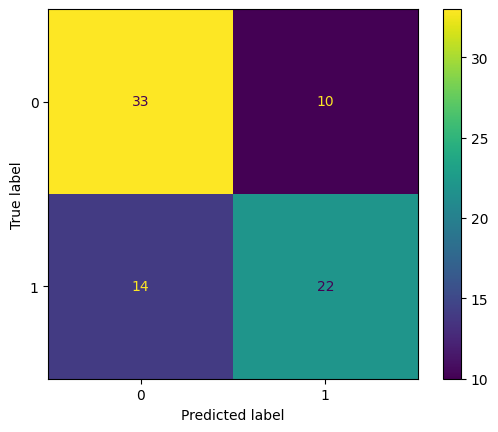

In [ ]:
model_sib, X, y_true, y_pred = classification_experiment(RandomForestClassifier(), medicine="SIB",
        params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type="C")
statdf = pd.DataFrame(list(zip(model_sib[:-1].get_feature_names_out(), model_sib[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

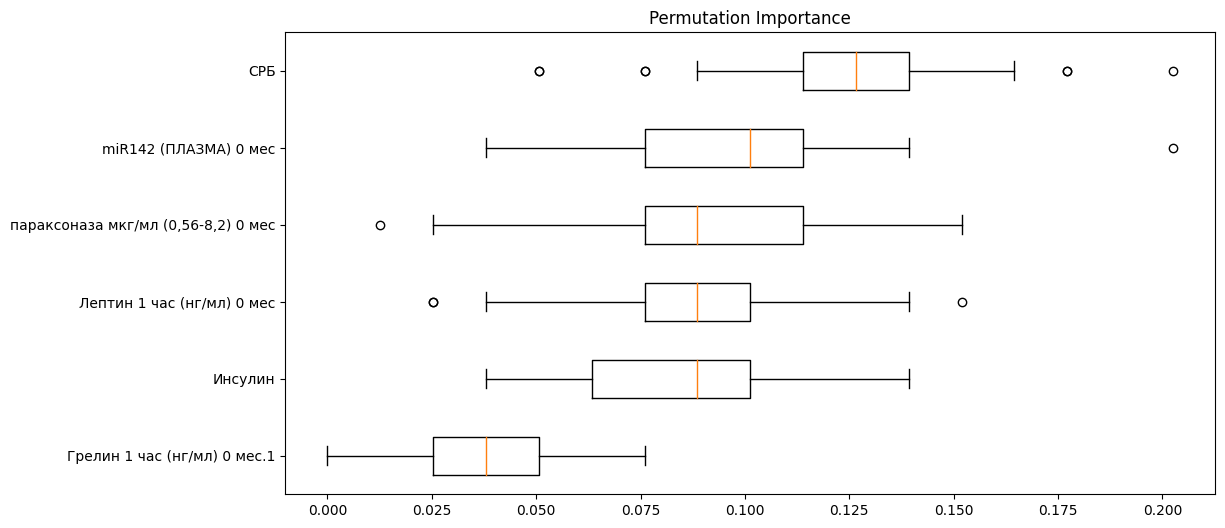

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

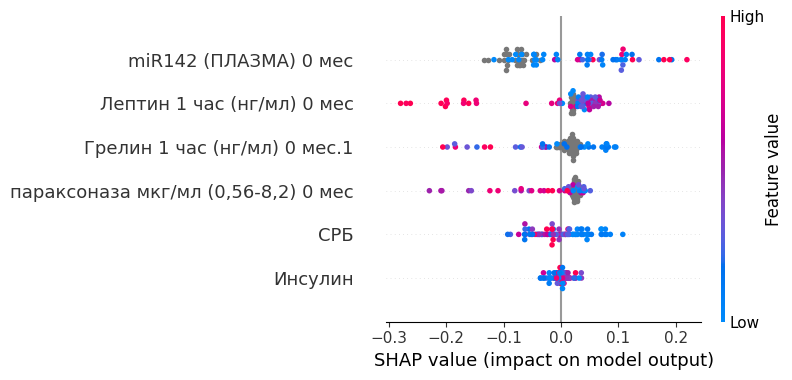

In [ ]:
explainer = shap.TreeExplainer(model[-1], X)
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

In [ ]:
for i in ["A", "B", "C"]:
  for m in [RandomForestClassifier(), DecisionTreeClassifier()]:
    model, X, y_true, y_pred = classification_experiment(m, medicine="SIB",
        params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type=i)
    print(i, m.__class__.__name__, classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"])

A RandomForestClassifier 0.5323315118397085
A DecisionTreeClassifier 0.6513680494263019
B RandomForestClassifier 0.609375
B DecisionTreeClassifier 0.5495495495495495
C RandomForestClassifier 0.7160130718954247
C DecisionTreeClassifier 0.6073432740099407


SAX

In [ ]:
t = []
sdpl_copy = sax_default_params_list.copy()
for i in range(5):
  saxstatsdf = recursively_delete_params("SAX", sdpl_copy)
  best_param = saxstatsdf[saxstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)


['ГПП 1 нг/мл 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес', 'ТИМ справа ср, мм 0 мес', 'Е-селектин нг/мл 0 мес', 'CCL2 0 мес']




              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.76      0.87      0.81        15

    accuracy                           0.78        27
   macro avg       0.78      0.77      0.77        27
weighted avg       0.78      0.78      0.77        27



0      1
0                             HOMA-B 0.2001
3                               ЛПНП 0.1930
2                  ГПП 1 нг/мл 0 мес 0.1841
5                          ИМТ 0 мес 0.1693
4  Креатинин мкмоль/л (53-106) 0 мес 0.1387
1                              Пульс 0.1148

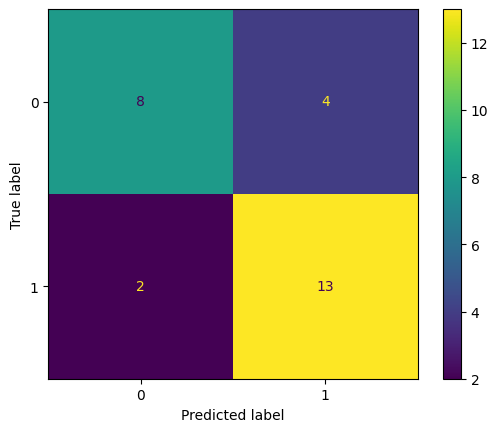

In [ ]:
model_sax, X, y_true, y_pred = classification_experiment(RandomForestClassifier(), medicine="SAX",
        params = ['ГПП 1 нг/мл 0 мес',
                  'Креатинин мкмоль/л (53-106) 0 мес',
                  'HOMA-B', 'ИМТ 0 мес', "Сартаны"], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

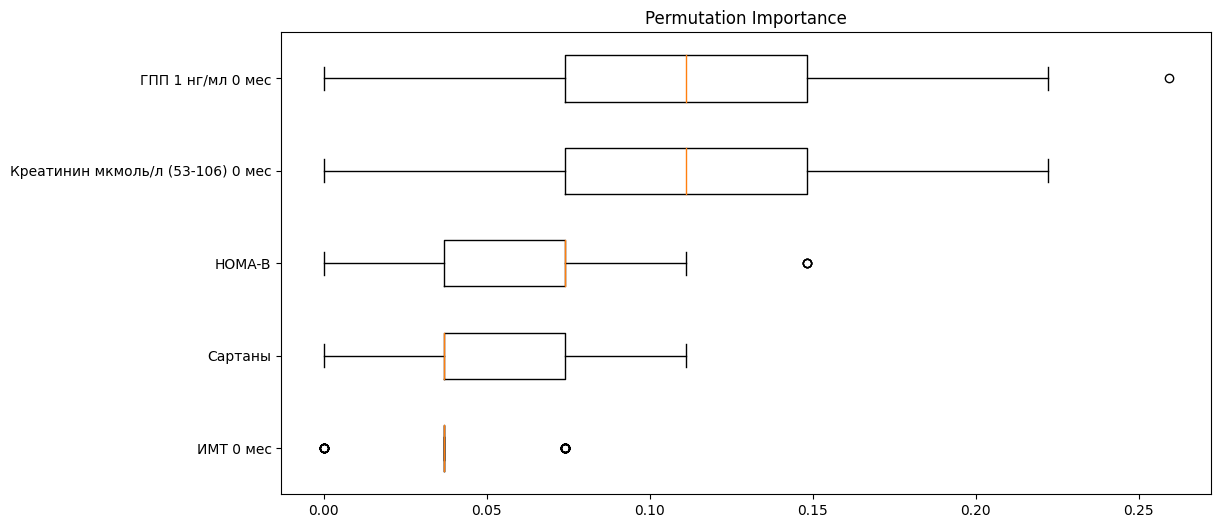

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

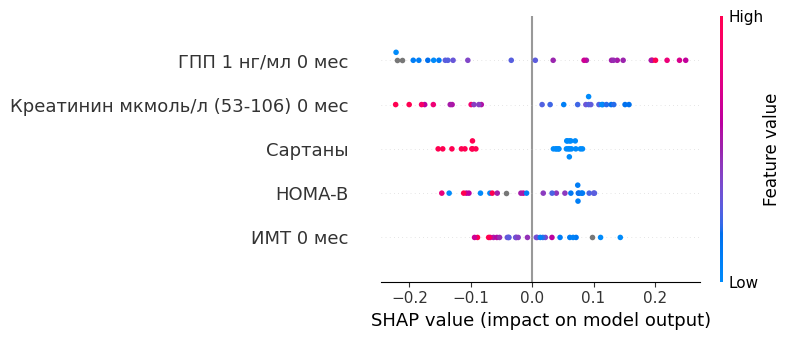

In [ ]:
explainer = shap.TreeExplainer(model[-1], X)
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

In [ ]:
y_true[7]

0

In [ ]:
y_pred[7]

1

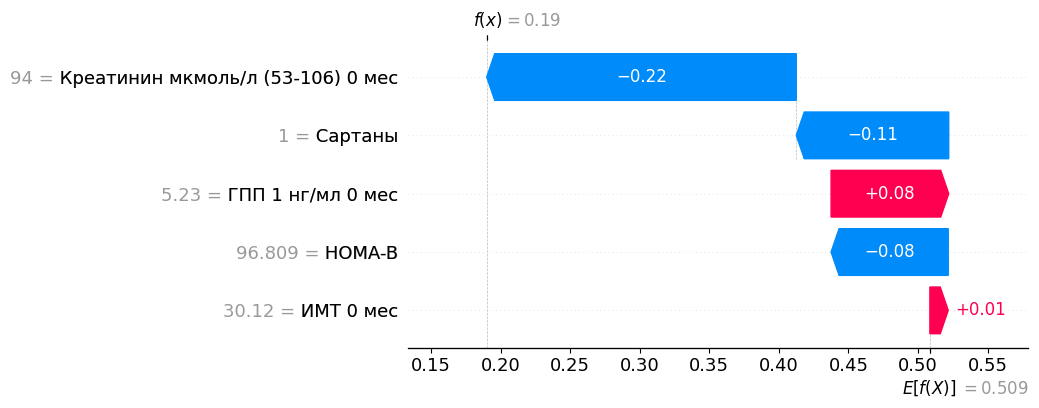

In [ ]:
shap.plots.waterfall(shap_values[7][:, 1])

## XGBoost

## CatBoost

In [ ]:
m = catboost.CatBoostRegressor(learning_rate=0.001, iterations=1000)
st = []
for j in tqdm(range(100)):
  dataset_x = some_transforms()
  dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
  cat_features = ['МЗО/МНО_V3', 'Артериальная гипертензия', 'Дислипидемия', 'Пол'] #+ ["Лечение"]
  X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1), np.max(dataset_x[["% потери веса 3 мес", "% потери веса 6 мес"]], axis=1)
  y = (y-y.min())/(y.max()-y.min())
  X.loc[:, cat_features] = X.loc[:, cat_features].astype(str)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  cat_features = np.where(X.columns.isin(cat_features))[0]
  m.fit(X_train, y_train)
  st.append(m.score(X_test, y_test))


  0%|          | 0/100 [00:00<?, ?it/s]

0:	learn: 0.2575978	total: 6.12ms	remaining: 6.12s
1:	learn: 0.2575296	total: 20.6ms	remaining: 10.3s
2:	learn: 0.2574489	total: 28.2ms	remaining: 9.37s
3:	learn: 0.2573631	total: 43.3ms	remaining: 10.8s
4:	learn: 0.2572937	total: 51.1ms	remaining: 10.2s
5:	learn: 0.2572383	total: 63.1ms	remaining: 10.4s
6:	learn: 0.2571908	total: 68.9ms	remaining: 9.77s
7:	learn: 0.2571526	total: 79.1ms	remaining: 9.81s
8:	learn: 0.2570915	total: 87.1ms	remaining: 9.59s
9:	learn: 0.2570390	total: 103ms	remaining: 10.2s
10:	learn: 0.2569651	total: 115ms	remaining: 10.4s
11:	learn: 0.2568976	total: 128ms	remaining: 10.6s
12:	learn: 0.2568093	total: 136ms	remaining: 10.3s
13:	learn: 0.2567089	total: 148ms	remaining: 10.4s
14:	learn: 0.2566408	total: 155ms	remaining: 10.2s
15:	learn: 0.2565502	total: 164ms	remaining: 10.1s
16:	learn: 0.2564443	total: 169ms	remaining: 9.79s
17:	learn: 0.2563420	total: 177ms	remaining: 9.68s
18:	learn: 0.2562559	total: 189ms	remaining: 9.74s
19:	learn: 0.2561892	total: 198m

  1%|          | 1/100 [00:04<07:02,  4.27s/it]

994:	learn: 0.1987861	total: 3.96s	remaining: 19.9ms
995:	learn: 0.1987307	total: 3.96s	remaining: 15.9ms
996:	learn: 0.1986829	total: 3.97s	remaining: 11.9ms
997:	learn: 0.1986138	total: 3.97s	remaining: 7.96ms
998:	learn: 0.1985483	total: 3.97s	remaining: 3.98ms
999:	learn: 0.1984832	total: 3.98s	remaining: 0us
0:	learn: 0.2627318	total: 3.2ms	remaining: 3.2s
1:	learn: 0.2626484	total: 6.28ms	remaining: 3.13s
2:	learn: 0.2625459	total: 9.86ms	remaining: 3.28s
3:	learn: 0.2624438	total: 12.9ms	remaining: 3.21s
4:	learn: 0.2623830	total: 14.3ms	remaining: 2.84s
5:	learn: 0.2622970	total: 17.2ms	remaining: 2.85s
6:	learn: 0.2621868	total: 20.2ms	remaining: 2.87s
7:	learn: 0.2621251	total: 23.2ms	remaining: 2.88s
8:	learn: 0.2620507	total: 26.2ms	remaining: 2.89s
9:	learn: 0.2619685	total: 29.4ms	remaining: 2.91s
10:	learn: 0.2618833	total: 32.3ms	remaining: 2.91s
11:	learn: 0.2617731	total: 35.4ms	remaining: 2.92s
12:	learn: 0.2616580	total: 38.5ms	remaining: 2.92s
13:	learn: 0.2615657	

  2%|▏         | 2/100 [00:07<06:09,  3.77s/it]

960:	learn: 0.1907709	total: 3.14s	remaining: 127ms
961:	learn: 0.1907278	total: 3.14s	remaining: 124ms
962:	learn: 0.1906914	total: 3.14s	remaining: 121ms
963:	learn: 0.1906131	total: 3.15s	remaining: 118ms
964:	learn: 0.1905572	total: 3.15s	remaining: 114ms
965:	learn: 0.1905212	total: 3.15s	remaining: 111ms
966:	learn: 0.1904594	total: 3.16s	remaining: 108ms
967:	learn: 0.1904030	total: 3.16s	remaining: 104ms
968:	learn: 0.1903434	total: 3.16s	remaining: 101ms
969:	learn: 0.1902690	total: 3.16s	remaining: 97.9ms
970:	learn: 0.1902122	total: 3.17s	remaining: 94.6ms
971:	learn: 0.1901308	total: 3.17s	remaining: 91.3ms
972:	learn: 0.1900636	total: 3.17s	remaining: 88ms
973:	learn: 0.1900165	total: 3.17s	remaining: 84.8ms
974:	learn: 0.1899558	total: 3.18s	remaining: 81.5ms
975:	learn: 0.1898964	total: 3.18s	remaining: 78.2ms
976:	learn: 0.1898394	total: 3.18s	remaining: 74.9ms
977:	learn: 0.1897956	total: 3.19s	remaining: 71.7ms
978:	learn: 0.1897643	total: 3.19s	remaining: 68.4ms
979:

  3%|▎         | 3/100 [00:10<05:42,  3.53s/it]

982:	learn: 0.2093918	total: 3.02s	remaining: 52.2ms
983:	learn: 0.2093455	total: 3.02s	remaining: 49.2ms
984:	learn: 0.2092993	total: 3.03s	remaining: 46.1ms
985:	learn: 0.2092295	total: 3.03s	remaining: 43ms
986:	learn: 0.2091807	total: 3.03s	remaining: 39.9ms
987:	learn: 0.2091213	total: 3.03s	remaining: 36.9ms
988:	learn: 0.2090481	total: 3.04s	remaining: 33.8ms
989:	learn: 0.2089871	total: 3.04s	remaining: 30.7ms
990:	learn: 0.2089411	total: 3.04s	remaining: 27.6ms
991:	learn: 0.2088731	total: 3.04s	remaining: 24.6ms
992:	learn: 0.2088125	total: 3.05s	remaining: 21.5ms
993:	learn: 0.2087541	total: 3.05s	remaining: 18.4ms
994:	learn: 0.2086847	total: 3.05s	remaining: 15.3ms
995:	learn: 0.2086257	total: 3.06s	remaining: 12.3ms
996:	learn: 0.2085538	total: 3.06s	remaining: 9.2ms
997:	learn: 0.2084917	total: 3.06s	remaining: 6.13ms
998:	learn: 0.2084027	total: 3.06s	remaining: 3.07ms
999:	learn: 0.2083773	total: 3.07s	remaining: 0us
0:	learn: 0.2641614	total: 1.4ms	remaining: 1.39s
1:

  4%|▍         | 4/100 [00:15<06:29,  4.06s/it]

961:	learn: 0.2068234	total: 4.49s	remaining: 177ms
962:	learn: 0.2067828	total: 4.49s	remaining: 173ms
963:	learn: 0.2067300	total: 4.5s	remaining: 168ms
964:	learn: 0.2066642	total: 4.5s	remaining: 163ms
965:	learn: 0.2066086	total: 4.5s	remaining: 159ms
966:	learn: 0.2065617	total: 4.51s	remaining: 154ms
967:	learn: 0.2065174	total: 4.51s	remaining: 149ms
968:	learn: 0.2064519	total: 4.51s	remaining: 144ms
969:	learn: 0.2063744	total: 4.52s	remaining: 140ms
970:	learn: 0.2063332	total: 4.52s	remaining: 135ms
971:	learn: 0.2062823	total: 4.53s	remaining: 130ms
972:	learn: 0.2062277	total: 4.54s	remaining: 126ms
973:	learn: 0.2061811	total: 4.54s	remaining: 121ms
974:	learn: 0.2061181	total: 4.55s	remaining: 117ms
975:	learn: 0.2060806	total: 4.55s	remaining: 112ms
976:	learn: 0.2060430	total: 4.55s	remaining: 107ms
977:	learn: 0.2060089	total: 4.56s	remaining: 103ms
978:	learn: 0.2059499	total: 4.56s	remaining: 97.8ms
979:	learn: 0.2059091	total: 4.56s	remaining: 93.2ms
980:	learn: 0

  5%|▌         | 5/100 [00:19<06:05,  3.85s/it]

963:	learn: 0.1939716	total: 3.19s	remaining: 119ms
964:	learn: 0.1939637	total: 3.2s	remaining: 116ms
965:	learn: 0.1939054	total: 3.2s	remaining: 113ms
966:	learn: 0.1938549	total: 3.2s	remaining: 109ms
967:	learn: 0.1938024	total: 3.21s	remaining: 106ms
968:	learn: 0.1937441	total: 3.21s	remaining: 103ms
969:	learn: 0.1937050	total: 3.21s	remaining: 99.4ms
970:	learn: 0.1936320	total: 3.22s	remaining: 96.1ms
971:	learn: 0.1935718	total: 3.22s	remaining: 92.8ms
972:	learn: 0.1935032	total: 3.22s	remaining: 89.4ms
973:	learn: 0.1934426	total: 3.23s	remaining: 86.1ms
974:	learn: 0.1933834	total: 3.23s	remaining: 82.8ms
975:	learn: 0.1933357	total: 3.23s	remaining: 79.5ms
976:	learn: 0.1932935	total: 3.23s	remaining: 76.2ms
977:	learn: 0.1932271	total: 3.24s	remaining: 72.9ms
978:	learn: 0.1931686	total: 3.24s	remaining: 69.5ms
979:	learn: 0.1931031	total: 3.25s	remaining: 66.2ms
980:	learn: 0.1930708	total: 3.25s	remaining: 62.9ms
981:	learn: 0.1930295	total: 3.25s	remaining: 59.6ms
98

  6%|▌         | 6/100 [00:22<05:48,  3.71s/it]

995:	learn: 0.1946830	total: 3.24s	remaining: 13ms
996:	learn: 0.1946249	total: 3.25s	remaining: 9.77ms
997:	learn: 0.1945822	total: 3.25s	remaining: 6.51ms
998:	learn: 0.1945468	total: 3.25s	remaining: 3.26ms
999:	learn: 0.1944938	total: 3.26s	remaining: 0us
0:	learn: 0.2773910	total: 3.05ms	remaining: 3.05s
1:	learn: 0.2773027	total: 6.18ms	remaining: 3.08s
2:	learn: 0.2771937	total: 9.43ms	remaining: 3.13s
3:	learn: 0.2771002	total: 12.7ms	remaining: 3.16s
4:	learn: 0.2769848	total: 15.7ms	remaining: 3.12s
5:	learn: 0.2768888	total: 20.1ms	remaining: 3.33s
6:	learn: 0.2767882	total: 23.2ms	remaining: 3.29s
7:	learn: 0.2767278	total: 26.5ms	remaining: 3.29s
8:	learn: 0.2766222	total: 29.5ms	remaining: 3.25s
9:	learn: 0.2765217	total: 34.1ms	remaining: 3.38s
10:	learn: 0.2764151	total: 40.3ms	remaining: 3.62s
11:	learn: 0.2763384	total: 43.3ms	remaining: 3.57s
12:	learn: 0.2762689	total: 46.3ms	remaining: 3.52s
13:	learn: 0.2761404	total: 49.4ms	remaining: 3.48s
14:	learn: 0.2760404	t

  7%|▋         | 7/100 [00:27<06:18,  4.07s/it]

994:	learn: 0.2037111	total: 4.52s	remaining: 22.7ms
995:	learn: 0.2036261	total: 4.52s	remaining: 18.2ms
996:	learn: 0.2035419	total: 4.53s	remaining: 13.6ms
997:	learn: 0.2035004	total: 4.53s	remaining: 9.08ms
998:	learn: 0.2034254	total: 4.53s	remaining: 4.54ms
999:	learn: 0.2033691	total: 4.54s	remaining: 0us
0:	learn: 0.2390602	total: 3ms	remaining: 3s
1:	learn: 0.2389656	total: 6.03ms	remaining: 3.01s
2:	learn: 0.2388979	total: 9.55ms	remaining: 3.17s
3:	learn: 0.2388327	total: 12.6ms	remaining: 3.13s
4:	learn: 0.2387655	total: 15.5ms	remaining: 3.08s
5:	learn: 0.2386972	total: 18.5ms	remaining: 3.06s
6:	learn: 0.2386181	total: 21.6ms	remaining: 3.06s
7:	learn: 0.2385564	total: 24.6ms	remaining: 3.05s
8:	learn: 0.2385080	total: 27.5ms	remaining: 3.03s
9:	learn: 0.2384464	total: 30.6ms	remaining: 3.03s
10:	learn: 0.2383941	total: 33.9ms	remaining: 3.05s
11:	learn: 0.2383170	total: 37ms	remaining: 3.04s
12:	learn: 0.2382436	total: 40ms	remaining: 3.03s
13:	learn: 0.2381832	total: 4

  8%|▊         | 8/100 [00:30<05:55,  3.86s/it]

958:	learn: 0.1839996	total: 3.13s	remaining: 134ms
959:	learn: 0.1839498	total: 3.14s	remaining: 131ms
960:	learn: 0.1839100	total: 3.14s	remaining: 127ms
961:	learn: 0.1838683	total: 3.14s	remaining: 124ms
962:	learn: 0.1838064	total: 3.15s	remaining: 121ms
963:	learn: 0.1837540	total: 3.15s	remaining: 118ms
964:	learn: 0.1837009	total: 3.15s	remaining: 114ms
965:	learn: 0.1836491	total: 3.15s	remaining: 111ms
966:	learn: 0.1835926	total: 3.16s	remaining: 108ms
967:	learn: 0.1835446	total: 3.16s	remaining: 105ms
968:	learn: 0.1834754	total: 3.16s	remaining: 101ms
969:	learn: 0.1834251	total: 3.17s	remaining: 98ms
970:	learn: 0.1833717	total: 3.17s	remaining: 94.7ms
971:	learn: 0.1833439	total: 3.17s	remaining: 91.4ms
972:	learn: 0.1833034	total: 3.17s	remaining: 88.1ms
973:	learn: 0.1832560	total: 3.18s	remaining: 84.8ms
974:	learn: 0.1832068	total: 3.18s	remaining: 81.6ms
975:	learn: 0.1831561	total: 3.18s	remaining: 78.3ms
976:	learn: 0.1831116	total: 3.19s	remaining: 75ms
977:	lea

  9%|▉         | 9/100 [00:34<05:37,  3.71s/it]

954:	learn: 0.2003570	total: 3.04s	remaining: 143ms
955:	learn: 0.2003186	total: 3.05s	remaining: 140ms
956:	learn: 0.2002599	total: 3.05s	remaining: 137ms
957:	learn: 0.2001960	total: 3.05s	remaining: 134ms
958:	learn: 0.2001603	total: 3.06s	remaining: 131ms
959:	learn: 0.2001208	total: 3.06s	remaining: 128ms
960:	learn: 0.2000656	total: 3.07s	remaining: 125ms
961:	learn: 0.2000059	total: 3.07s	remaining: 121ms
962:	learn: 0.1999550	total: 3.07s	remaining: 118ms
963:	learn: 0.1999006	total: 3.08s	remaining: 115ms
964:	learn: 0.1998294	total: 3.08s	remaining: 112ms
965:	learn: 0.1997731	total: 3.08s	remaining: 109ms
966:	learn: 0.1997495	total: 3.09s	remaining: 105ms
967:	learn: 0.1997157	total: 3.09s	remaining: 102ms
968:	learn: 0.1996616	total: 3.09s	remaining: 99ms
969:	learn: 0.1996289	total: 3.1s	remaining: 95.8ms
970:	learn: 0.1995692	total: 3.1s	remaining: 92.6ms
971:	learn: 0.1995157	total: 3.1s	remaining: 89.4ms
972:	learn: 0.1994582	total: 3.1s	remaining: 86.2ms
973:	learn: 0

 10%|█         | 10/100 [00:38<06:00,  4.00s/it]

997:	learn: 0.1986981	total: 4.36s	remaining: 8.74ms
998:	learn: 0.1986501	total: 4.37s	remaining: 4.37ms
999:	learn: 0.1986013	total: 4.38s	remaining: 0us
0:	learn: 0.2485432	total: 4.54ms	remaining: 4.53s
1:	learn: 0.2484576	total: 12.9ms	remaining: 6.42s
2:	learn: 0.2483870	total: 18.6ms	remaining: 6.2s
3:	learn: 0.2482993	total: 26.3ms	remaining: 6.54s
4:	learn: 0.2482012	total: 35.2ms	remaining: 7s
5:	learn: 0.2481054	total: 42.7ms	remaining: 7.08s
6:	learn: 0.2480108	total: 47.3ms	remaining: 6.71s
7:	learn: 0.2479312	total: 53.7ms	remaining: 6.66s
8:	learn: 0.2478356	total: 57.8ms	remaining: 6.36s
9:	learn: 0.2477361	total: 62.9ms	remaining: 6.23s
10:	learn: 0.2476327	total: 67.2ms	remaining: 6.04s
11:	learn: 0.2475380	total: 71.5ms	remaining: 5.89s
12:	learn: 0.2474350	total: 77.8ms	remaining: 5.91s
13:	learn: 0.2473367	total: 86.1ms	remaining: 6.07s
14:	learn: 0.2472550	total: 95.6ms	remaining: 6.27s
15:	learn: 0.2471556	total: 104ms	remaining: 6.41s
16:	learn: 0.2470392	total:

 11%|█         | 11/100 [00:42<05:47,  3.90s/it]

957:	learn: 0.1810685	total: 3.35s	remaining: 147ms
958:	learn: 0.1810347	total: 3.35s	remaining: 143ms
959:	learn: 0.1809706	total: 3.36s	remaining: 140ms
960:	learn: 0.1809197	total: 3.36s	remaining: 136ms
961:	learn: 0.1808591	total: 3.36s	remaining: 133ms
962:	learn: 0.1808122	total: 3.36s	remaining: 129ms
963:	learn: 0.1807682	total: 3.37s	remaining: 126ms
964:	learn: 0.1807155	total: 3.37s	remaining: 122ms
965:	learn: 0.1806525	total: 3.37s	remaining: 119ms
966:	learn: 0.1806097	total: 3.38s	remaining: 115ms
967:	learn: 0.1805610	total: 3.38s	remaining: 112ms
968:	learn: 0.1805056	total: 3.38s	remaining: 108ms
969:	learn: 0.1804658	total: 3.38s	remaining: 105ms
970:	learn: 0.1804101	total: 3.39s	remaining: 101ms
971:	learn: 0.1803474	total: 3.39s	remaining: 97.6ms
972:	learn: 0.1802936	total: 3.39s	remaining: 94.1ms
973:	learn: 0.1802371	total: 3.4s	remaining: 90.6ms
974:	learn: 0.1801803	total: 3.4s	remaining: 87.1ms
975:	learn: 0.1801157	total: 3.4s	remaining: 83.7ms
976:	learn

 12%|█▏        | 12/100 [00:45<05:27,  3.73s/it]

953:	learn: 0.1846393	total: 3.01s	remaining: 145ms
954:	learn: 0.1845943	total: 3.01s	remaining: 142ms
955:	learn: 0.1845592	total: 3.01s	remaining: 139ms
956:	learn: 0.1845255	total: 3.02s	remaining: 136ms
957:	learn: 0.1844655	total: 3.02s	remaining: 132ms
958:	learn: 0.1844568	total: 3.02s	remaining: 129ms
959:	learn: 0.1843988	total: 3.02s	remaining: 126ms
960:	learn: 0.1843560	total: 3.03s	remaining: 123ms
961:	learn: 0.1842873	total: 3.03s	remaining: 120ms
962:	learn: 0.1842493	total: 3.03s	remaining: 117ms
963:	learn: 0.1842049	total: 3.04s	remaining: 113ms
964:	learn: 0.1841972	total: 3.04s	remaining: 110ms
965:	learn: 0.1841690	total: 3.04s	remaining: 107ms
966:	learn: 0.1841365	total: 3.04s	remaining: 104ms
967:	learn: 0.1840826	total: 3.05s	remaining: 101ms
968:	learn: 0.1840266	total: 3.05s	remaining: 97.5ms
969:	learn: 0.1840051	total: 3.05s	remaining: 94.4ms
970:	learn: 0.1839467	total: 3.05s	remaining: 91.2ms
971:	learn: 0.1838929	total: 3.06s	remaining: 88.1ms
972:	lea

 13%|█▎        | 13/100 [00:49<05:30,  3.80s/it]

987:	learn: 0.2087169	total: 3.65s	remaining: 44.4ms
988:	learn: 0.2086712	total: 3.66s	remaining: 40.7ms
989:	learn: 0.2086446	total: 3.66s	remaining: 37ms
990:	learn: 0.2085993	total: 3.67s	remaining: 33.3ms
991:	learn: 0.2085460	total: 3.68s	remaining: 29.7ms
992:	learn: 0.2084944	total: 3.69s	remaining: 26ms
993:	learn: 0.2084373	total: 3.69s	remaining: 22.3ms
994:	learn: 0.2083876	total: 3.7s	remaining: 18.6ms
995:	learn: 0.2083342	total: 3.71s	remaining: 14.9ms
996:	learn: 0.2082675	total: 3.72s	remaining: 11.2ms
997:	learn: 0.2082276	total: 3.73s	remaining: 7.47ms
998:	learn: 0.2081416	total: 3.74s	remaining: 3.74ms
999:	learn: 0.2081012	total: 3.75s	remaining: 0us
0:	learn: 0.2734030	total: 5.51ms	remaining: 5.5s
1:	learn: 0.2733149	total: 9.55ms	remaining: 4.76s
2:	learn: 0.2732149	total: 13.6ms	remaining: 4.5s
3:	learn: 0.2731132	total: 18.3ms	remaining: 4.57s
4:	learn: 0.2730193	total: 22.7ms	remaining: 4.52s
5:	learn: 0.2729333	total: 25.5ms	remaining: 4.23s
6:	learn: 0.272

 14%|█▍        | 14/100 [00:54<05:44,  4.01s/it]

995:	learn: 0.2019315	total: 4.19s	remaining: 16.8ms
996:	learn: 0.2018861	total: 4.19s	remaining: 12.6ms
997:	learn: 0.2018348	total: 4.2s	remaining: 8.42ms
998:	learn: 0.2017892	total: 4.21s	remaining: 4.21ms
999:	learn: 0.2017329	total: 4.21s	remaining: 0us
0:	learn: 0.2669823	total: 2.95ms	remaining: 2.94s
1:	learn: 0.2668999	total: 5.99ms	remaining: 2.99s
2:	learn: 0.2667812	total: 8.94ms	remaining: 2.97s
3:	learn: 0.2666705	total: 12.1ms	remaining: 3.02s
4:	learn: 0.2665875	total: 15ms	remaining: 2.98s
5:	learn: 0.2664785	total: 17.9ms	remaining: 2.96s
6:	learn: 0.2664041	total: 20.8ms	remaining: 2.95s
7:	learn: 0.2663216	total: 28.6ms	remaining: 3.54s
8:	learn: 0.2662487	total: 35.7ms	remaining: 3.93s
9:	learn: 0.2661290	total: 38.9ms	remaining: 3.85s
10:	learn: 0.2660501	total: 42ms	remaining: 3.77s
11:	learn: 0.2659581	total: 45.1ms	remaining: 3.71s
12:	learn: 0.2658335	total: 48ms	remaining: 3.65s
13:	learn: 0.2657322	total: 51ms	remaining: 3.59s
14:	learn: 0.2656229	total: 5

 15%|█▌        | 15/100 [00:59<06:01,  4.25s/it]

998:	learn: 0.1936764	total: 4.51s	remaining: 4.51ms
999:	learn: 0.1936232	total: 4.52s	remaining: 0us
0:	learn: 0.2654081	total: 2.92ms	remaining: 2.92s
1:	learn: 0.2653309	total: 5.91ms	remaining: 2.95s
2:	learn: 0.2652507	total: 8.85ms	remaining: 2.94s
3:	learn: 0.2651522	total: 12ms	remaining: 2.98s
4:	learn: 0.2650457	total: 14.8ms	remaining: 2.94s
5:	learn: 0.2649755	total: 17.9ms	remaining: 2.96s
6:	learn: 0.2649033	total: 20.8ms	remaining: 2.95s
7:	learn: 0.2648124	total: 23.7ms	remaining: 2.94s
8:	learn: 0.2647543	total: 26.5ms	remaining: 2.92s
9:	learn: 0.2646729	total: 29.4ms	remaining: 2.91s
10:	learn: 0.2646099	total: 32.5ms	remaining: 2.92s
11:	learn: 0.2645062	total: 35.3ms	remaining: 2.91s
12:	learn: 0.2644126	total: 38.1ms	remaining: 2.9s
13:	learn: 0.2643071	total: 41.4ms	remaining: 2.92s
14:	learn: 0.2642067	total: 44.2ms	remaining: 2.9s
15:	learn: 0.2641206	total: 47.1ms	remaining: 2.9s
16:	learn: 0.2640422	total: 50ms	remaining: 2.89s
17:	learn: 0.2639620	total: 52

 16%|█▌        | 16/100 [01:03<05:55,  4.23s/it]

999:	learn: 0.1935390	total: 3.89s	remaining: 0us
0:	learn: 0.2584474	total: 3.42ms	remaining: 3.42s
1:	learn: 0.2583736	total: 9.13ms	remaining: 4.55s
2:	learn: 0.2583038	total: 16.2ms	remaining: 5.37s
3:	learn: 0.2582310	total: 30.6ms	remaining: 7.62s
4:	learn: 0.2581623	total: 40.2ms	remaining: 8.01s
5:	learn: 0.2581144	total: 43.7ms	remaining: 7.25s
6:	learn: 0.2580669	total: 59ms	remaining: 8.37s
7:	learn: 0.2580377	total: 67.7ms	remaining: 8.4s
8:	learn: 0.2579588	total: 76.5ms	remaining: 8.42s
9:	learn: 0.2578899	total: 80.7ms	remaining: 7.99s
10:	learn: 0.2577908	total: 90.1ms	remaining: 8.1s
11:	learn: 0.2577127	total: 96.9ms	remaining: 7.98s
12:	learn: 0.2576126	total: 106ms	remaining: 8.07s
13:	learn: 0.2575465	total: 115ms	remaining: 8.08s
14:	learn: 0.2574630	total: 123ms	remaining: 8.08s
15:	learn: 0.2573972	total: 127ms	remaining: 7.82s
16:	learn: 0.2573853	total: 128ms	remaining: 7.42s
17:	learn: 0.2572745	total: 137ms	remaining: 7.49s
18:	learn: 0.2571804	total: 145ms	

 17%|█▋        | 17/100 [01:08<06:19,  4.57s/it]

998:	learn: 0.1979944	total: 5.02s	remaining: 5.02ms
999:	learn: 0.1979421	total: 5.03s	remaining: 0us
0:	learn: 0.2712768	total: 2.98ms	remaining: 2.98s
1:	learn: 0.2712058	total: 6.02ms	remaining: 3.01s
2:	learn: 0.2710924	total: 8.93ms	remaining: 2.97s
3:	learn: 0.2710314	total: 11.8ms	remaining: 2.94s
4:	learn: 0.2709461	total: 14.8ms	remaining: 2.95s
5:	learn: 0.2708871	total: 17.8ms	remaining: 2.95s
6:	learn: 0.2708188	total: 20.8ms	remaining: 2.95s
7:	learn: 0.2707730	total: 23.8ms	remaining: 2.95s
8:	learn: 0.2706866	total: 26.8ms	remaining: 2.95s
9:	learn: 0.2706105	total: 29.8ms	remaining: 2.95s
10:	learn: 0.2705336	total: 32.7ms	remaining: 2.94s
11:	learn: 0.2704616	total: 35.6ms	remaining: 2.93s
12:	learn: 0.2703892	total: 38.6ms	remaining: 2.93s
13:	learn: 0.2703365	total: 41.7ms	remaining: 2.94s
14:	learn: 0.2702734	total: 44.8ms	remaining: 2.94s
15:	learn: 0.2701916	total: 47.9ms	remaining: 2.95s
16:	learn: 0.2701127	total: 50.9ms	remaining: 2.94s
17:	learn: 0.2700387	to

 18%|█▊        | 18/100 [01:12<05:47,  4.24s/it]

964:	learn: 0.2070064	total: 3.14s	remaining: 114ms
965:	learn: 0.2069365	total: 3.15s	remaining: 111ms
966:	learn: 0.2068769	total: 3.15s	remaining: 108ms
967:	learn: 0.2068531	total: 3.16s	remaining: 104ms
968:	learn: 0.2068094	total: 3.16s	remaining: 101ms
969:	learn: 0.2067618	total: 3.16s	remaining: 97.8ms
970:	learn: 0.2067063	total: 3.17s	remaining: 94.6ms
971:	learn: 0.2066634	total: 3.17s	remaining: 91.3ms
972:	learn: 0.2065825	total: 3.17s	remaining: 88ms
973:	learn: 0.2065284	total: 3.17s	remaining: 84.8ms
974:	learn: 0.2064634	total: 3.18s	remaining: 81.5ms
975:	learn: 0.2064044	total: 3.18s	remaining: 78.2ms
976:	learn: 0.2063689	total: 3.18s	remaining: 75ms
977:	learn: 0.2063136	total: 3.19s	remaining: 71.7ms
978:	learn: 0.2062684	total: 3.19s	remaining: 68.4ms
979:	learn: 0.2062070	total: 3.19s	remaining: 65.2ms
980:	learn: 0.2061449	total: 3.19s	remaining: 61.9ms
981:	learn: 0.2060814	total: 3.2s	remaining: 58.6ms
982:	learn: 0.2060419	total: 3.2s	remaining: 55.4ms
983:

 19%|█▉        | 19/100 [01:15<05:20,  3.96s/it]

971:	learn: 0.2045603	total: 3.04s	remaining: 87.5ms
972:	learn: 0.2045048	total: 3.04s	remaining: 84.5ms
973:	learn: 0.2044436	total: 3.05s	remaining: 81.4ms
974:	learn: 0.2044162	total: 3.05s	remaining: 78.3ms
975:	learn: 0.2043814	total: 3.06s	remaining: 75.2ms
976:	learn: 0.2043354	total: 3.06s	remaining: 72.1ms
977:	learn: 0.2043020	total: 3.06s	remaining: 68.9ms
978:	learn: 0.2042407	total: 3.07s	remaining: 65.8ms
979:	learn: 0.2041910	total: 3.07s	remaining: 62.7ms
980:	learn: 0.2041336	total: 3.07s	remaining: 59.5ms
981:	learn: 0.2040700	total: 3.08s	remaining: 56.4ms
982:	learn: 0.2040389	total: 3.08s	remaining: 53.2ms
983:	learn: 0.2039790	total: 3.08s	remaining: 50.1ms
984:	learn: 0.2039168	total: 3.08s	remaining: 47ms
985:	learn: 0.2038681	total: 3.09s	remaining: 43.8ms
986:	learn: 0.2038080	total: 3.09s	remaining: 40.7ms
987:	learn: 0.2037541	total: 3.09s	remaining: 37.6ms
988:	learn: 0.2036757	total: 3.1s	remaining: 34.4ms
989:	learn: 0.2036288	total: 3.1s	remaining: 31.3

 20%|██        | 20/100 [01:20<05:44,  4.31s/it]

0:	learn: 0.2509260	total: 4.41ms	remaining: 4.4s
1:	learn: 0.2508468	total: 8.34ms	remaining: 4.16s
2:	learn: 0.2507733	total: 11.2ms	remaining: 3.74s
3:	learn: 0.2507150	total: 14.1ms	remaining: 3.52s
4:	learn: 0.2506388	total: 17ms	remaining: 3.39s
5:	learn: 0.2505688	total: 19.9ms	remaining: 3.29s
6:	learn: 0.2505336	total: 22.7ms	remaining: 3.23s
7:	learn: 0.2504744	total: 25.7ms	remaining: 3.19s
8:	learn: 0.2504128	total: 28.5ms	remaining: 3.14s
9:	learn: 0.2503340	total: 31.5ms	remaining: 3.12s
10:	learn: 0.2502717	total: 34.3ms	remaining: 3.09s
11:	learn: 0.2501844	total: 37.3ms	remaining: 3.07s
12:	learn: 0.2501168	total: 40.1ms	remaining: 3.05s
13:	learn: 0.2500418	total: 43ms	remaining: 3.03s
14:	learn: 0.2499608	total: 46ms	remaining: 3.02s
15:	learn: 0.2498988	total: 48.9ms	remaining: 3.01s
16:	learn: 0.2498255	total: 51.8ms	remaining: 3s
17:	learn: 0.2498033	total: 53.7ms	remaining: 2.93s
18:	learn: 0.2497578	total: 56.6ms	remaining: 2.92s
19:	learn: 0.2497041	total: 59.5

 21%|██        | 21/100 [01:24<05:18,  4.04s/it]

0:	learn: 0.2306076	total: 3.08ms	remaining: 3.08s
1:	learn: 0.2305544	total: 6.3ms	remaining: 3.15s
2:	learn: 0.2304574	total: 9.05ms	remaining: 3.01s
3:	learn: 0.2303814	total: 11.9ms	remaining: 2.96s
4:	learn: 0.2302781	total: 14.8ms	remaining: 2.94s
5:	learn: 0.2302082	total: 17.5ms	remaining: 2.89s
6:	learn: 0.2301161	total: 20.2ms	remaining: 2.87s
7:	learn: 0.2300648	total: 23.1ms	remaining: 2.86s
8:	learn: 0.2300047	total: 25.8ms	remaining: 2.84s
9:	learn: 0.2299335	total: 31.2ms	remaining: 3.09s
10:	learn: 0.2298369	total: 35.4ms	remaining: 3.18s
11:	learn: 0.2297408	total: 38.3ms	remaining: 3.15s
12:	learn: 0.2296761	total: 41.1ms	remaining: 3.12s
13:	learn: 0.2295898	total: 43.9ms	remaining: 3.09s
14:	learn: 0.2294853	total: 46.7ms	remaining: 3.07s
15:	learn: 0.2293946	total: 49.8ms	remaining: 3.06s
16:	learn: 0.2293335	total: 52.8ms	remaining: 3.05s
17:	learn: 0.2292994	total: 54.8ms	remaining: 2.99s
18:	learn: 0.2292094	total: 57.8ms	remaining: 2.98s
19:	learn: 0.2291262	to

 22%|██▏       | 22/100 [01:27<05:01,  3.86s/it]

985:	learn: 0.1693296	total: 3.2s	remaining: 45.4ms
986:	learn: 0.1692793	total: 3.2s	remaining: 42.2ms
987:	learn: 0.1692406	total: 3.21s	remaining: 39ms
988:	learn: 0.1691924	total: 3.22s	remaining: 35.8ms
989:	learn: 0.1691430	total: 3.22s	remaining: 32.5ms
990:	learn: 0.1690971	total: 3.22s	remaining: 29.3ms
991:	learn: 0.1690481	total: 3.22s	remaining: 26ms
992:	learn: 0.1690279	total: 3.23s	remaining: 22.8ms
993:	learn: 0.1689796	total: 3.23s	remaining: 19.5ms
994:	learn: 0.1689543	total: 3.23s	remaining: 16.3ms
995:	learn: 0.1688963	total: 3.24s	remaining: 13ms
996:	learn: 0.1688403	total: 3.24s	remaining: 9.76ms
997:	learn: 0.1688041	total: 3.25s	remaining: 6.51ms
998:	learn: 0.1687340	total: 3.25s	remaining: 3.25ms
999:	learn: 0.1686693	total: 3.25s	remaining: 0us
0:	learn: 0.2604752	total: 2.87ms	remaining: 2.87s
1:	learn: 0.2604143	total: 5.6ms	remaining: 2.79s
2:	learn: 0.2603236	total: 8.39ms	remaining: 2.79s
3:	learn: 0.2602356	total: 12.1ms	remaining: 3s
4:	learn: 0.2601

 23%|██▎       | 23/100 [01:32<05:20,  4.17s/it]

958:	learn: 0.1977461	total: 4.41s	remaining: 189ms
959:	learn: 0.1976870	total: 4.41s	remaining: 184ms
960:	learn: 0.1976312	total: 4.42s	remaining: 179ms
961:	learn: 0.1975969	total: 4.42s	remaining: 175ms
962:	learn: 0.1975311	total: 4.43s	remaining: 170ms
963:	learn: 0.1974731	total: 4.43s	remaining: 165ms
964:	learn: 0.1974152	total: 4.43s	remaining: 161ms
965:	learn: 0.1973551	total: 4.44s	remaining: 156ms
966:	learn: 0.1973062	total: 4.44s	remaining: 152ms
967:	learn: 0.1972609	total: 4.45s	remaining: 147ms
968:	learn: 0.1971889	total: 4.45s	remaining: 142ms
969:	learn: 0.1971418	total: 4.45s	remaining: 138ms
970:	learn: 0.1970988	total: 4.45s	remaining: 133ms
971:	learn: 0.1970386	total: 4.46s	remaining: 128ms
972:	learn: 0.1969867	total: 4.46s	remaining: 124ms
973:	learn: 0.1969317	total: 4.46s	remaining: 119ms
974:	learn: 0.1968528	total: 4.47s	remaining: 115ms
975:	learn: 0.1968141	total: 4.48s	remaining: 110ms
976:	learn: 0.1967702	total: 4.48s	remaining: 106ms
977:	learn: 

 24%|██▍       | 24/100 [01:36<05:05,  4.02s/it]

991:	learn: 0.1876853	total: 3.43s	remaining: 27.7ms
992:	learn: 0.1876243	total: 3.43s	remaining: 24.2ms
993:	learn: 0.1875752	total: 3.44s	remaining: 20.8ms
994:	learn: 0.1875191	total: 3.45s	remaining: 17.3ms
995:	learn: 0.1874522	total: 3.45s	remaining: 13.9ms
996:	learn: 0.1873983	total: 3.46s	remaining: 10.4ms
997:	learn: 0.1873373	total: 3.46s	remaining: 6.93ms
998:	learn: 0.1872977	total: 3.46s	remaining: 3.47ms
999:	learn: 0.1872393	total: 3.47s	remaining: 0us
0:	learn: 0.2697997	total: 3.54ms	remaining: 3.53s
1:	learn: 0.2697415	total: 6.63ms	remaining: 3.31s
2:	learn: 0.2696787	total: 9.71ms	remaining: 3.23s
3:	learn: 0.2696040	total: 12.7ms	remaining: 3.15s
4:	learn: 0.2695051	total: 15.6ms	remaining: 3.1s
5:	learn: 0.2694398	total: 18.5ms	remaining: 3.07s
6:	learn: 0.2693887	total: 21.5ms	remaining: 3.05s
7:	learn: 0.2693267	total: 24.4ms	remaining: 3.03s
8:	learn: 0.2692856	total: 27.3ms	remaining: 3s
9:	learn: 0.2692096	total: 30.2ms	remaining: 2.99s
10:	learn: 0.2691013

 25%|██▌       | 25/100 [01:39<04:49,  3.87s/it]

0:	learn: 0.2515854	total: 2.92ms	remaining: 2.92s
1:	learn: 0.2515303	total: 6.27ms	remaining: 3.13s
2:	learn: 0.2514771	total: 9.22ms	remaining: 3.06s
3:	learn: 0.2514188	total: 12.1ms	remaining: 3.01s
4:	learn: 0.2513509	total: 14.9ms	remaining: 2.97s
5:	learn: 0.2512817	total: 21.4ms	remaining: 3.55s
6:	learn: 0.2512125	total: 24.5ms	remaining: 3.48s
7:	learn: 0.2511292	total: 27.4ms	remaining: 3.4s
8:	learn: 0.2510521	total: 30.4ms	remaining: 3.34s
9:	learn: 0.2509717	total: 33.2ms	remaining: 3.29s
10:	learn: 0.2509011	total: 36.1ms	remaining: 3.25s
11:	learn: 0.2508367	total: 39.7ms	remaining: 3.27s
12:	learn: 0.2507681	total: 42.7ms	remaining: 3.24s
13:	learn: 0.2506995	total: 45.7ms	remaining: 3.21s
14:	learn: 0.2506157	total: 48.7ms	remaining: 3.2s
15:	learn: 0.2505322	total: 51.6ms	remaining: 3.17s
16:	learn: 0.2504497	total: 56.3ms	remaining: 3.25s
17:	learn: 0.2503788	total: 59.1ms	remaining: 3.22s
18:	learn: 0.2503075	total: 62.2ms	remaining: 3.21s
19:	learn: 0.2502582	tot

 26%|██▌       | 26/100 [01:44<05:06,  4.14s/it]

979:	learn: 0.1889320	total: 4.38s	remaining: 89.5ms
980:	learn: 0.1888828	total: 4.39s	remaining: 85.1ms
981:	learn: 0.1888365	total: 4.4s	remaining: 80.7ms
982:	learn: 0.1887820	total: 4.41s	remaining: 76.2ms
983:	learn: 0.1887313	total: 4.42s	remaining: 71.8ms
984:	learn: 0.1886884	total: 4.42s	remaining: 67.4ms
985:	learn: 0.1886508	total: 4.43s	remaining: 62.9ms
986:	learn: 0.1885993	total: 4.44s	remaining: 58.4ms
987:	learn: 0.1885424	total: 4.44s	remaining: 53.9ms
988:	learn: 0.1884715	total: 4.44s	remaining: 49.4ms
989:	learn: 0.1884262	total: 4.45s	remaining: 44.9ms
990:	learn: 0.1883705	total: 4.45s	remaining: 40.4ms
991:	learn: 0.1883035	total: 4.46s	remaining: 35.9ms
992:	learn: 0.1882472	total: 4.46s	remaining: 31.5ms
993:	learn: 0.1881924	total: 4.47s	remaining: 27ms
994:	learn: 0.1881494	total: 4.47s	remaining: 22.5ms
995:	learn: 0.1881034	total: 4.49s	remaining: 18ms
996:	learn: 0.1880541	total: 4.49s	remaining: 13.5ms
997:	learn: 0.1879973	total: 4.49s	remaining: 9.01m

 27%|██▋       | 27/100 [01:47<04:50,  3.97s/it]

953:	learn: 0.1959787	total: 3.23s	remaining: 156ms
954:	learn: 0.1959326	total: 3.24s	remaining: 153ms
955:	learn: 0.1958871	total: 3.25s	remaining: 149ms
956:	learn: 0.1958495	total: 3.25s	remaining: 146ms
957:	learn: 0.1958022	total: 3.26s	remaining: 143ms
958:	learn: 0.1957375	total: 3.26s	remaining: 139ms
959:	learn: 0.1956970	total: 3.26s	remaining: 136ms
960:	learn: 0.1956386	total: 3.27s	remaining: 133ms
961:	learn: 0.1955758	total: 3.27s	remaining: 129ms
962:	learn: 0.1955316	total: 3.27s	remaining: 126ms
963:	learn: 0.1954781	total: 3.27s	remaining: 122ms
964:	learn: 0.1954451	total: 3.28s	remaining: 119ms
965:	learn: 0.1954203	total: 3.28s	remaining: 115ms
966:	learn: 0.1953604	total: 3.28s	remaining: 112ms
967:	learn: 0.1952999	total: 3.29s	remaining: 109ms
968:	learn: 0.1952535	total: 3.29s	remaining: 105ms
969:	learn: 0.1951974	total: 3.29s	remaining: 102ms
970:	learn: 0.1951407	total: 3.29s	remaining: 98.4ms
971:	learn: 0.1950710	total: 3.3s	remaining: 95ms
972:	learn: 0

 28%|██▊       | 28/100 [01:51<04:35,  3.83s/it]

975:	learn: 0.1871411	total: 3.22s	remaining: 79.2ms
976:	learn: 0.1870893	total: 3.22s	remaining: 75.9ms
977:	learn: 0.1870158	total: 3.23s	remaining: 72.7ms
978:	learn: 0.1869679	total: 3.24s	remaining: 69.4ms
979:	learn: 0.1869173	total: 3.24s	remaining: 66.2ms
980:	learn: 0.1868682	total: 3.25s	remaining: 62.9ms
981:	learn: 0.1868110	total: 3.25s	remaining: 59.6ms
982:	learn: 0.1867628	total: 3.25s	remaining: 56.3ms
983:	learn: 0.1866881	total: 3.26s	remaining: 53ms
984:	learn: 0.1866362	total: 3.26s	remaining: 49.7ms
985:	learn: 0.1866201	total: 3.26s	remaining: 46.3ms
986:	learn: 0.1865756	total: 3.27s	remaining: 43ms
987:	learn: 0.1865162	total: 3.27s	remaining: 39.7ms
988:	learn: 0.1864700	total: 3.27s	remaining: 36.4ms
989:	learn: 0.1864123	total: 3.27s	remaining: 33.1ms
990:	learn: 0.1863452	total: 3.28s	remaining: 29.8ms
991:	learn: 0.1862898	total: 3.28s	remaining: 26.5ms
992:	learn: 0.1862405	total: 3.28s	remaining: 23.2ms
993:	learn: 0.1861876	total: 3.29s	remaining: 19.8

 29%|██▉       | 29/100 [01:55<04:45,  4.02s/it]

973:	learn: 0.1852028	total: 4.05s	remaining: 108ms
974:	learn: 0.1851535	total: 4.06s	remaining: 104ms
975:	learn: 0.1850848	total: 4.07s	remaining: 100ms
976:	learn: 0.1850185	total: 4.08s	remaining: 96.1ms
977:	learn: 0.1849846	total: 4.09s	remaining: 92ms
978:	learn: 0.1849208	total: 4.09s	remaining: 87.8ms
979:	learn: 0.1848739	total: 4.1s	remaining: 83.7ms
980:	learn: 0.1848152	total: 4.11s	remaining: 79.5ms
981:	learn: 0.1847577	total: 4.11s	remaining: 75.3ms
982:	learn: 0.1846925	total: 4.12s	remaining: 71.2ms
983:	learn: 0.1846419	total: 4.12s	remaining: 67ms
984:	learn: 0.1845814	total: 4.12s	remaining: 62.8ms
985:	learn: 0.1845310	total: 4.13s	remaining: 58.6ms
986:	learn: 0.1844777	total: 4.13s	remaining: 54.4ms
987:	learn: 0.1844252	total: 4.14s	remaining: 50.2ms
988:	learn: 0.1843676	total: 4.14s	remaining: 46.1ms
989:	learn: 0.1843113	total: 4.15s	remaining: 41.9ms
990:	learn: 0.1842561	total: 4.15s	remaining: 37.7ms
991:	learn: 0.1842109	total: 4.16s	remaining: 33.5ms
9

 30%|███       | 30/100 [02:00<04:47,  4.10s/it]

982:	learn: 0.1971288	total: 3.93s	remaining: 68ms
983:	learn: 0.1970538	total: 3.94s	remaining: 64ms
984:	learn: 0.1970039	total: 3.94s	remaining: 60.1ms
985:	learn: 0.1969652	total: 3.95s	remaining: 56.1ms
986:	learn: 0.1969148	total: 3.95s	remaining: 52.1ms
987:	learn: 0.1968493	total: 3.96s	remaining: 48.1ms
988:	learn: 0.1967894	total: 3.96s	remaining: 44.1ms
989:	learn: 0.1967289	total: 3.97s	remaining: 40.1ms
990:	learn: 0.1966725	total: 3.97s	remaining: 36.1ms
991:	learn: 0.1966378	total: 3.98s	remaining: 32.1ms
992:	learn: 0.1965801	total: 3.98s	remaining: 28ms
993:	learn: 0.1965147	total: 3.98s	remaining: 24ms
994:	learn: 0.1964837	total: 3.98s	remaining: 20ms
995:	learn: 0.1964270	total: 3.99s	remaining: 16ms
996:	learn: 0.1963905	total: 3.99s	remaining: 12ms
997:	learn: 0.1963405	total: 3.99s	remaining: 8ms
998:	learn: 0.1962924	total: 4s	remaining: 4ms
999:	learn: 0.1962428	total: 4s	remaining: 0us
0:	learn: 0.2678396	total: 2.99ms	remaining: 2.99s
1:	learn: 0.2677455	tota

 31%|███       | 31/100 [02:03<04:31,  3.94s/it]

979:	learn: 0.2064895	total: 3.29s	remaining: 67.2ms
980:	learn: 0.2064108	total: 3.3s	remaining: 63.9ms
981:	learn: 0.2063453	total: 3.31s	remaining: 60.6ms
982:	learn: 0.2063079	total: 3.31s	remaining: 57.3ms
983:	learn: 0.2062721	total: 3.32s	remaining: 53.9ms
984:	learn: 0.2062106	total: 3.32s	remaining: 50.5ms
985:	learn: 0.2061452	total: 3.32s	remaining: 47.2ms
986:	learn: 0.2061040	total: 3.33s	remaining: 43.8ms
987:	learn: 0.2060705	total: 3.33s	remaining: 40.4ms
988:	learn: 0.2060173	total: 3.33s	remaining: 37ms
989:	learn: 0.2059719	total: 3.33s	remaining: 33.7ms
990:	learn: 0.2059230	total: 3.34s	remaining: 30.3ms
991:	learn: 0.2058678	total: 3.34s	remaining: 26.9ms
992:	learn: 0.2058171	total: 3.34s	remaining: 23.6ms
993:	learn: 0.2057618	total: 3.35s	remaining: 20.2ms
994:	learn: 0.2057173	total: 3.35s	remaining: 16.8ms
995:	learn: 0.2056975	total: 3.35s	remaining: 13.5ms
996:	learn: 0.2056218	total: 3.35s	remaining: 10.1ms
997:	learn: 0.2055602	total: 3.36s	remaining: 6.7

 32%|███▏      | 32/100 [02:07<04:19,  3.82s/it]

995:	learn: 0.1782077	total: 3.31s	remaining: 13.3ms
996:	learn: 0.1781415	total: 3.32s	remaining: 9.98ms
997:	learn: 0.1780852	total: 3.32s	remaining: 6.66ms
998:	learn: 0.1780720	total: 3.33s	remaining: 3.34ms
999:	learn: 0.1780321	total: 3.34s	remaining: 0us
0:	learn: 0.2681403	total: 3.18ms	remaining: 3.17s
1:	learn: 0.2680798	total: 6.37ms	remaining: 3.18s
2:	learn: 0.2680132	total: 9.34ms	remaining: 3.1s
3:	learn: 0.2679209	total: 12.3ms	remaining: 3.05s
4:	learn: 0.2678474	total: 15.2ms	remaining: 3.02s
5:	learn: 0.2677887	total: 18.1ms	remaining: 3s
6:	learn: 0.2677237	total: 21.1ms	remaining: 3s
7:	learn: 0.2676648	total: 24ms	remaining: 2.97s
8:	learn: 0.2675976	total: 26.8ms	remaining: 2.95s
9:	learn: 0.2675129	total: 29.8ms	remaining: 2.95s
10:	learn: 0.2674512	total: 32.7ms	remaining: 2.94s
11:	learn: 0.2673799	total: 36ms	remaining: 2.96s
12:	learn: 0.2673024	total: 38.9ms	remaining: 2.96s
13:	learn: 0.2672142	total: 41.9ms	remaining: 2.95s
14:	learn: 0.2671710	total: 45.

 33%|███▎      | 33/100 [02:12<04:39,  4.17s/it]

992:	learn: 0.2049021	total: 4.63s	remaining: 32.7ms
993:	learn: 0.2048360	total: 4.64s	remaining: 28ms
994:	learn: 0.2048105	total: 4.65s	remaining: 23.4ms
995:	learn: 0.2047499	total: 4.66s	remaining: 18.7ms
996:	learn: 0.2046904	total: 4.67s	remaining: 14ms
997:	learn: 0.2046196	total: 4.68s	remaining: 9.37ms
998:	learn: 0.2045530	total: 4.68s	remaining: 4.68ms
999:	learn: 0.2044890	total: 4.68s	remaining: 0us
0:	learn: 0.2168779	total: 3.77ms	remaining: 3.76s
1:	learn: 0.2168178	total: 8.1ms	remaining: 4.04s
2:	learn: 0.2167361	total: 11.7ms	remaining: 3.88s
3:	learn: 0.2166592	total: 15.5ms	remaining: 3.85s
4:	learn: 0.2165770	total: 19.3ms	remaining: 3.84s
5:	learn: 0.2164931	total: 22.2ms	remaining: 3.68s
6:	learn: 0.2163957	total: 25.1ms	remaining: 3.56s
7:	learn: 0.2163233	total: 28.3ms	remaining: 3.5s
8:	learn: 0.2162319	total: 32ms	remaining: 3.52s
9:	learn: 0.2161423	total: 34.9ms	remaining: 3.45s
10:	learn: 0.2160698	total: 37.8ms	remaining: 3.4s
11:	learn: 0.2159720	total

 34%|███▍      | 34/100 [02:15<04:22,  3.97s/it]

989:	learn: 0.1545513	total: 3.28s	remaining: 33.2ms
990:	learn: 0.1545026	total: 3.29s	remaining: 29.9ms
991:	learn: 0.1544519	total: 3.29s	remaining: 26.6ms
992:	learn: 0.1543944	total: 3.3s	remaining: 23.3ms
993:	learn: 0.1543537	total: 3.31s	remaining: 19.9ms
994:	learn: 0.1543159	total: 3.31s	remaining: 16.6ms
995:	learn: 0.1542534	total: 3.32s	remaining: 13.3ms
996:	learn: 0.1542107	total: 3.32s	remaining: 9.99ms
997:	learn: 0.1541563	total: 3.32s	remaining: 6.65ms
998:	learn: 0.1540905	total: 3.32s	remaining: 3.33ms
999:	learn: 0.1540364	total: 3.33s	remaining: 0us
0:	learn: 0.2550519	total: 4.12ms	remaining: 4.11s
1:	learn: 0.2549591	total: 6.92ms	remaining: 3.45s
2:	learn: 0.2548510	total: 9.65ms	remaining: 3.21s
3:	learn: 0.2547681	total: 12.5ms	remaining: 3.1s
4:	learn: 0.2546939	total: 15.1ms	remaining: 3s
5:	learn: 0.2545963	total: 18.1ms	remaining: 3.01s
6:	learn: 0.2545343	total: 21ms	remaining: 2.98s
7:	learn: 0.2544564	total: 23.9ms	remaining: 2.96s
8:	learn: 0.2543942

 35%|███▌      | 35/100 [02:19<04:10,  3.86s/it]

983:	learn: 0.1845243	total: 3.32s	remaining: 54ms
984:	learn: 0.1844581	total: 3.33s	remaining: 50.6ms
985:	learn: 0.1843996	total: 3.33s	remaining: 47.3ms
986:	learn: 0.1843486	total: 3.34s	remaining: 44ms
987:	learn: 0.1842883	total: 3.35s	remaining: 40.6ms
988:	learn: 0.1842255	total: 3.35s	remaining: 37.3ms
989:	learn: 0.1841632	total: 3.36s	remaining: 33.9ms
990:	learn: 0.1841080	total: 3.36s	remaining: 30.5ms
991:	learn: 0.1840678	total: 3.36s	remaining: 27.1ms
992:	learn: 0.1839924	total: 3.37s	remaining: 23.7ms
993:	learn: 0.1839259	total: 3.37s	remaining: 20.3ms
994:	learn: 0.1838726	total: 3.37s	remaining: 16.9ms
995:	learn: 0.1838209	total: 3.37s	remaining: 13.6ms
996:	learn: 0.1837758	total: 3.38s	remaining: 10.2ms
997:	learn: 0.1837296	total: 3.38s	remaining: 6.78ms
998:	learn: 0.1836823	total: 3.38s	remaining: 3.39ms
999:	learn: 0.1836198	total: 3.39s	remaining: 0us
0:	learn: 0.2693318	total: 4.17ms	remaining: 4.16s
1:	learn: 0.2692330	total: 7.11ms	remaining: 3.55s
2:	l

 36%|███▌      | 36/100 [02:24<04:33,  4.27s/it]

970:	learn: 0.2001600	total: 4.86s	remaining: 145ms
971:	learn: 0.2000841	total: 4.87s	remaining: 140ms
972:	learn: 0.2000363	total: 4.87s	remaining: 135ms
973:	learn: 0.1999803	total: 4.88s	remaining: 130ms
974:	learn: 0.1999270	total: 4.88s	remaining: 125ms
975:	learn: 0.1998813	total: 4.88s	remaining: 120ms
976:	learn: 0.1998135	total: 4.89s	remaining: 115ms
977:	learn: 0.1997582	total: 4.89s	remaining: 110ms
978:	learn: 0.1996918	total: 4.9s	remaining: 105ms
979:	learn: 0.1996330	total: 4.9s	remaining: 100ms
980:	learn: 0.1995786	total: 4.91s	remaining: 95.1ms
981:	learn: 0.1995450	total: 4.91s	remaining: 90ms
982:	learn: 0.1995245	total: 4.91s	remaining: 85ms
983:	learn: 0.1994696	total: 4.92s	remaining: 79.9ms
984:	learn: 0.1993976	total: 4.92s	remaining: 74.9ms
985:	learn: 0.1993132	total: 4.92s	remaining: 69.9ms
986:	learn: 0.1992506	total: 4.92s	remaining: 64.9ms
987:	learn: 0.1991877	total: 4.93s	remaining: 59.9ms
988:	learn: 0.1991566	total: 4.93s	remaining: 54.9ms
989:	lear

 37%|███▋      | 37/100 [02:28<04:18,  4.10s/it]

999:	learn: 0.1840192	total: 3.48s	remaining: 0us
0:	learn: 0.2352791	total: 6.4ms	remaining: 6.39s
1:	learn: 0.2352052	total: 9.45ms	remaining: 4.72s
2:	learn: 0.2350966	total: 12.5ms	remaining: 4.14s
3:	learn: 0.2350275	total: 16.4ms	remaining: 4.09s
4:	learn: 0.2349475	total: 20.9ms	remaining: 4.15s
5:	learn: 0.2348666	total: 23.7ms	remaining: 3.92s
6:	learn: 0.2347907	total: 26.6ms	remaining: 3.78s
7:	learn: 0.2347375	total: 29.4ms	remaining: 3.65s
8:	learn: 0.2346712	total: 32.3ms	remaining: 3.56s
9:	learn: 0.2346105	total: 35.4ms	remaining: 3.5s
10:	learn: 0.2345241	total: 38.4ms	remaining: 3.45s
11:	learn: 0.2344526	total: 41.2ms	remaining: 3.39s
12:	learn: 0.2343966	total: 42ms	remaining: 3.19s
13:	learn: 0.2343284	total: 45ms	remaining: 3.17s
14:	learn: 0.2342607	total: 50.1ms	remaining: 3.29s
15:	learn: 0.2341898	total: 54.1ms	remaining: 3.33s
16:	learn: 0.2341308	total: 57.1ms	remaining: 3.3s
17:	learn: 0.2340398	total: 60.4ms	remaining: 3.29s
18:	learn: 0.2339707	total: 63.

 38%|███▊      | 38/100 [02:32<04:07,  3.99s/it]

0:	learn: 0.2533834	total: 3.22ms	remaining: 3.21s
1:	learn: 0.2533068	total: 6.61ms	remaining: 3.3s
2:	learn: 0.2532436	total: 9.71ms	remaining: 3.23s
3:	learn: 0.2531662	total: 12.8ms	remaining: 3.19s
4:	learn: 0.2530831	total: 15.8ms	remaining: 3.15s
5:	learn: 0.2530090	total: 18.7ms	remaining: 3.1s
6:	learn: 0.2529232	total: 21.7ms	remaining: 3.08s
7:	learn: 0.2528628	total: 24.7ms	remaining: 3.07s
8:	learn: 0.2528177	total: 27.6ms	remaining: 3.04s
9:	learn: 0.2527443	total: 30.7ms	remaining: 3.04s
10:	learn: 0.2526757	total: 33.7ms	remaining: 3.03s
11:	learn: 0.2526046	total: 38.1ms	remaining: 3.14s
12:	learn: 0.2525004	total: 41.2ms	remaining: 3.12s
13:	learn: 0.2524369	total: 44.2ms	remaining: 3.11s
14:	learn: 0.2523648	total: 47.1ms	remaining: 3.09s
15:	learn: 0.2522782	total: 50ms	remaining: 3.08s
16:	learn: 0.2522009	total: 53ms	remaining: 3.06s
17:	learn: 0.2521478	total: 55.9ms	remaining: 3.05s
18:	learn: 0.2520323	total: 58.8ms	remaining: 3.04s
19:	learn: 0.2519438	total: 

 39%|███▉      | 39/100 [02:37<04:28,  4.40s/it]

993:	learn: 0.1915981	total: 4.78s	remaining: 28.8ms
994:	learn: 0.1915380	total: 4.78s	remaining: 24ms
995:	learn: 0.1914934	total: 4.79s	remaining: 19.2ms
996:	learn: 0.1914449	total: 4.79s	remaining: 14.4ms
997:	learn: 0.1914081	total: 4.79s	remaining: 9.61ms
998:	learn: 0.1913478	total: 4.8s	remaining: 4.8ms
999:	learn: 0.1913314	total: 4.8s	remaining: 0us
0:	learn: 0.2345417	total: 7.17ms	remaining: 7.16s
1:	learn: 0.2344390	total: 11.8ms	remaining: 5.91s
2:	learn: 0.2343585	total: 14.9ms	remaining: 4.95s
3:	learn: 0.2342633	total: 17.8ms	remaining: 4.42s
4:	learn: 0.2341995	total: 20.7ms	remaining: 4.11s
5:	learn: 0.2341421	total: 23.5ms	remaining: 3.9s
6:	learn: 0.2340814	total: 26.4ms	remaining: 3.74s
7:	learn: 0.2340333	total: 29.2ms	remaining: 3.62s
8:	learn: 0.2339856	total: 33.5ms	remaining: 3.69s
9:	learn: 0.2339105	total: 36.6ms	remaining: 3.63s
10:	learn: 0.2338249	total: 39.8ms	remaining: 3.57s
11:	learn: 0.2337620	total: 43ms	remaining: 3.54s
12:	learn: 0.2336643	total

 40%|████      | 40/100 [02:40<04:08,  4.14s/it]

0:	learn: 0.2341198	total: 6.85ms	remaining: 6.84s
1:	learn: 0.2340407	total: 13.9ms	remaining: 6.96s
2:	learn: 0.2339818	total: 16.9ms	remaining: 5.63s
3:	learn: 0.2338925	total: 19.8ms	remaining: 4.93s
4:	learn: 0.2338315	total: 22.8ms	remaining: 4.53s
5:	learn: 0.2337678	total: 25.7ms	remaining: 4.25s
6:	learn: 0.2337004	total: 28.5ms	remaining: 4.05s
7:	learn: 0.2336476	total: 31.4ms	remaining: 3.89s
8:	learn: 0.2335618	total: 36.1ms	remaining: 3.97s
9:	learn: 0.2334887	total: 40.2ms	remaining: 3.98s
10:	learn: 0.2334005	total: 42.9ms	remaining: 3.86s
11:	learn: 0.2333115	total: 45.7ms	remaining: 3.76s
12:	learn: 0.2332378	total: 48.4ms	remaining: 3.68s
13:	learn: 0.2331671	total: 51.2ms	remaining: 3.6s
14:	learn: 0.2330852	total: 54.1ms	remaining: 3.56s
15:	learn: 0.2329958	total: 57.1ms	remaining: 3.51s
16:	learn: 0.2329398	total: 60ms	remaining: 3.47s
17:	learn: 0.2328713	total: 62.8ms	remaining: 3.43s
18:	learn: 0.2328127	total: 65.7ms	remaining: 3.39s
19:	learn: 0.2327448	tota

 41%|████      | 41/100 [02:44<03:54,  3.97s/it]

0:	learn: 0.2644532	total: 5.96ms	remaining: 5.95s
1:	learn: 0.2643579	total: 13.3ms	remaining: 6.66s
2:	learn: 0.2642738	total: 21.8ms	remaining: 7.25s
3:	learn: 0.2641924	total: 24.8ms	remaining: 6.18s
4:	learn: 0.2641038	total: 27.8ms	remaining: 5.52s
5:	learn: 0.2640259	total: 30.6ms	remaining: 5.07s
6:	learn: 0.2639501	total: 33.5ms	remaining: 4.75s
7:	learn: 0.2638859	total: 36.4ms	remaining: 4.51s
8:	learn: 0.2638207	total: 39.3ms	remaining: 4.32s
9:	learn: 0.2637290	total: 42.1ms	remaining: 4.16s
10:	learn: 0.2636260	total: 44.9ms	remaining: 4.04s
11:	learn: 0.2635200	total: 47.7ms	remaining: 3.93s
12:	learn: 0.2634429	total: 50.5ms	remaining: 3.84s
13:	learn: 0.2633709	total: 53.5ms	remaining: 3.77s
14:	learn: 0.2632786	total: 56.4ms	remaining: 3.7s
15:	learn: 0.2631944	total: 59.3ms	remaining: 3.64s
16:	learn: 0.2631250	total: 62.2ms	remaining: 3.59s
17:	learn: 0.2631147	total: 63.2ms	remaining: 3.44s
18:	learn: 0.2630424	total: 66ms	remaining: 3.41s
19:	learn: 0.2629905	tota

 42%|████▏     | 42/100 [02:49<04:00,  4.15s/it]

983:	learn: 0.2019164	total: 4.14s	remaining: 67.4ms
984:	learn: 0.2018497	total: 4.15s	remaining: 63.2ms
985:	learn: 0.2017924	total: 4.16s	remaining: 59ms
986:	learn: 0.2017285	total: 4.17s	remaining: 55ms
987:	learn: 0.2016706	total: 4.18s	remaining: 50.8ms
988:	learn: 0.2016219	total: 4.19s	remaining: 46.6ms
989:	learn: 0.2015522	total: 4.2s	remaining: 42.4ms
990:	learn: 0.2014952	total: 4.21s	remaining: 38.2ms
991:	learn: 0.2014468	total: 4.21s	remaining: 34ms
992:	learn: 0.2013998	total: 4.22s	remaining: 29.8ms
993:	learn: 0.2013365	total: 4.23s	remaining: 25.5ms
994:	learn: 0.2012785	total: 4.24s	remaining: 21.3ms
995:	learn: 0.2012082	total: 4.24s	remaining: 17ms
996:	learn: 0.2011467	total: 4.25s	remaining: 12.8ms
997:	learn: 0.2010922	total: 4.25s	remaining: 8.53ms
998:	learn: 0.2010344	total: 4.26s	remaining: 4.26ms
999:	learn: 0.2009865	total: 4.26s	remaining: 0us
0:	learn: 0.2514898	total: 8.94ms	remaining: 8.94s
1:	learn: 0.2514231	total: 19.5ms	remaining: 9.73s
2:	learn:

 43%|████▎     | 43/100 [02:53<03:54,  4.12s/it]

0:	learn: 0.2342836	total: 8.15ms	remaining: 8.14s
1:	learn: 0.2342004	total: 13.6ms	remaining: 6.76s
2:	learn: 0.2340972	total: 19.9ms	remaining: 6.62s
3:	learn: 0.2340146	total: 26.8ms	remaining: 6.67s
4:	learn: 0.2339347	total: 33.1ms	remaining: 6.59s
5:	learn: 0.2338520	total: 38.9ms	remaining: 6.45s
6:	learn: 0.2337751	total: 48.8ms	remaining: 6.92s
7:	learn: 0.2337112	total: 54.4ms	remaining: 6.75s
8:	learn: 0.2336361	total: 57.4ms	remaining: 6.33s
9:	learn: 0.2335669	total: 60.4ms	remaining: 5.98s
10:	learn: 0.2334841	total: 63.5ms	remaining: 5.71s
11:	learn: 0.2333758	total: 65.7ms	remaining: 5.41s
12:	learn: 0.2332877	total: 68.7ms	remaining: 5.22s
13:	learn: 0.2331985	total: 71.7ms	remaining: 5.05s
14:	learn: 0.2331321	total: 74.8ms	remaining: 4.91s
15:	learn: 0.2330429	total: 77.7ms	remaining: 4.78s
16:	learn: 0.2329660	total: 80.8ms	remaining: 4.67s
17:	learn: 0.2328959	total: 83.8ms	remaining: 4.57s
18:	learn: 0.2327998	total: 86.8ms	remaining: 4.48s
19:	learn: 0.2327275	t

 44%|████▍     | 44/100 [02:56<03:44,  4.02s/it]

974:	learn: 0.1704198	total: 3.43s	remaining: 88ms
975:	learn: 0.1703773	total: 3.44s	remaining: 84.7ms
976:	learn: 0.1703211	total: 3.46s	remaining: 81.4ms
977:	learn: 0.1702748	total: 3.46s	remaining: 78ms
978:	learn: 0.1702227	total: 3.47s	remaining: 74.5ms
979:	learn: 0.1701725	total: 3.48s	remaining: 71ms
980:	learn: 0.1701121	total: 3.48s	remaining: 67.4ms
981:	learn: 0.1700564	total: 3.48s	remaining: 63.9ms
982:	learn: 0.1699957	total: 3.49s	remaining: 60.4ms
983:	learn: 0.1699317	total: 3.49s	remaining: 56.8ms
984:	learn: 0.1698791	total: 3.5s	remaining: 53.3ms
985:	learn: 0.1698149	total: 3.5s	remaining: 49.7ms
986:	learn: 0.1697685	total: 3.51s	remaining: 46.2ms
987:	learn: 0.1697279	total: 3.51s	remaining: 42.6ms
988:	learn: 0.1696744	total: 3.52s	remaining: 39.1ms
989:	learn: 0.1696256	total: 3.52s	remaining: 35.6ms
990:	learn: 0.1695681	total: 3.52s	remaining: 32ms
991:	learn: 0.1695174	total: 3.53s	remaining: 28.5ms
992:	learn: 0.1694533	total: 3.53s	remaining: 24.9ms
993

 45%|████▌     | 45/100 [03:01<03:54,  4.26s/it]

978:	learn: 0.1790453	total: 4.41s	remaining: 94.7ms
979:	learn: 0.1789958	total: 4.42s	remaining: 90.2ms
980:	learn: 0.1789436	total: 4.43s	remaining: 85.8ms
981:	learn: 0.1788920	total: 4.43s	remaining: 81.3ms
982:	learn: 0.1788307	total: 4.45s	remaining: 76.9ms
983:	learn: 0.1788005	total: 4.45s	remaining: 72.4ms
984:	learn: 0.1787397	total: 4.46s	remaining: 67.9ms
985:	learn: 0.1786814	total: 4.46s	remaining: 63.3ms
986:	learn: 0.1786276	total: 4.46s	remaining: 58.8ms
987:	learn: 0.1785784	total: 4.48s	remaining: 54.4ms
988:	learn: 0.1785387	total: 4.48s	remaining: 49.9ms
989:	learn: 0.1784932	total: 4.49s	remaining: 45.4ms
990:	learn: 0.1784314	total: 4.5s	remaining: 40.8ms
991:	learn: 0.1783800	total: 4.5s	remaining: 36.3ms
992:	learn: 0.1783307	total: 4.5s	remaining: 31.8ms
993:	learn: 0.1782696	total: 4.51s	remaining: 27.2ms
994:	learn: 0.1782106	total: 4.51s	remaining: 22.7ms
995:	learn: 0.1781549	total: 4.51s	remaining: 18.1ms
996:	learn: 0.1781095	total: 4.52s	remaining: 13.

 46%|████▌     | 46/100 [03:05<03:48,  4.23s/it]

961:	learn: 0.2152180	total: 3.78s	remaining: 149ms
962:	learn: 0.2151614	total: 3.79s	remaining: 146ms
963:	learn: 0.2151240	total: 3.79s	remaining: 142ms
964:	learn: 0.2150611	total: 3.79s	remaining: 138ms
965:	learn: 0.2149671	total: 3.8s	remaining: 134ms
966:	learn: 0.2149394	total: 3.8s	remaining: 130ms
967:	learn: 0.2148728	total: 3.81s	remaining: 126ms
968:	learn: 0.2148219	total: 3.81s	remaining: 122ms
969:	learn: 0.2147621	total: 3.81s	remaining: 118ms
970:	learn: 0.2147068	total: 3.82s	remaining: 114ms
971:	learn: 0.2146316	total: 3.82s	remaining: 110ms
972:	learn: 0.2145701	total: 3.83s	remaining: 106ms
973:	learn: 0.2144952	total: 3.83s	remaining: 102ms
974:	learn: 0.2144477	total: 3.83s	remaining: 98.3ms
975:	learn: 0.2143945	total: 3.84s	remaining: 94.4ms
976:	learn: 0.2143498	total: 3.84s	remaining: 90.4ms
977:	learn: 0.2143029	total: 3.84s	remaining: 86.5ms
978:	learn: 0.2142407	total: 3.85s	remaining: 82.5ms
979:	learn: 0.2141637	total: 3.85s	remaining: 78.6ms
980:	lea

 47%|████▋     | 47/100 [03:09<03:40,  4.15s/it]

969:	learn: 0.1994624	total: 3.67s	remaining: 113ms
970:	learn: 0.1994369	total: 3.67s	remaining: 110ms
971:	learn: 0.1994093	total: 3.68s	remaining: 106ms
972:	learn: 0.1993607	total: 3.69s	remaining: 102ms
973:	learn: 0.1993171	total: 3.7s	remaining: 98.8ms
974:	learn: 0.1992992	total: 3.7s	remaining: 95ms
975:	learn: 0.1992597	total: 3.71s	remaining: 91.2ms
976:	learn: 0.1992069	total: 3.71s	remaining: 87.4ms
977:	learn: 0.1991413	total: 3.71s	remaining: 83.6ms
978:	learn: 0.1991190	total: 3.72s	remaining: 79.7ms
979:	learn: 0.1990879	total: 3.72s	remaining: 75.9ms
980:	learn: 0.1990541	total: 3.72s	remaining: 72.1ms
981:	learn: 0.1989956	total: 3.73s	remaining: 68.3ms
982:	learn: 0.1989562	total: 3.73s	remaining: 64.5ms
983:	learn: 0.1989141	total: 3.73s	remaining: 60.7ms
984:	learn: 0.1988617	total: 3.74s	remaining: 56.9ms
985:	learn: 0.1988164	total: 3.74s	remaining: 53.1ms
986:	learn: 0.1987856	total: 3.74s	remaining: 49.3ms
987:	learn: 0.1987145	total: 3.75s	remaining: 45.5ms
9

 48%|████▊     | 48/100 [03:14<03:35,  4.14s/it]

993:	learn: 0.1924030	total: 3.84s	remaining: 23.2ms
994:	learn: 0.1923609	total: 3.85s	remaining: 19.3ms
995:	learn: 0.1923004	total: 3.86s	remaining: 15.5ms
996:	learn: 0.1922259	total: 3.87s	remaining: 11.6ms
997:	learn: 0.1921562	total: 3.87s	remaining: 7.76ms
998:	learn: 0.1921113	total: 3.88s	remaining: 3.88ms
999:	learn: 0.1920544	total: 3.89s	remaining: 0us
0:	learn: 0.2555554	total: 5.41ms	remaining: 5.41s
1:	learn: 0.2554618	total: 8.91ms	remaining: 4.44s
2:	learn: 0.2553866	total: 17.5ms	remaining: 5.82s
3:	learn: 0.2553074	total: 21ms	remaining: 5.23s
4:	learn: 0.2552153	total: 24.6ms	remaining: 4.89s
5:	learn: 0.2551416	total: 28.2ms	remaining: 4.67s
6:	learn: 0.2550416	total: 32ms	remaining: 4.53s
7:	learn: 0.2549723	total: 43.1ms	remaining: 5.34s
8:	learn: 0.2548862	total: 47ms	remaining: 5.18s
9:	learn: 0.2548169	total: 51.6ms	remaining: 5.11s
10:	learn: 0.2547453	total: 56.3ms	remaining: 5.06s
11:	learn: 0.2546719	total: 61.4ms	remaining: 5.06s
12:	learn: 0.2545971	tot

 49%|████▉     | 49/100 [03:18<03:42,  4.35s/it]

975:	learn: 0.1906031	total: 4.46s	remaining: 110ms
976:	learn: 0.1905465	total: 4.46s	remaining: 105ms
977:	learn: 0.1904962	total: 4.47s	remaining: 101ms
978:	learn: 0.1904305	total: 4.47s	remaining: 96ms
979:	learn: 0.1903848	total: 4.48s	remaining: 91.5ms
980:	learn: 0.1903221	total: 4.48s	remaining: 86.9ms
981:	learn: 0.1902618	total: 4.49s	remaining: 82.3ms
982:	learn: 0.1901907	total: 4.49s	remaining: 77.7ms
983:	learn: 0.1901193	total: 4.5s	remaining: 73.1ms
984:	learn: 0.1900534	total: 4.5s	remaining: 68.6ms
985:	learn: 0.1899896	total: 4.5s	remaining: 64ms
986:	learn: 0.1899200	total: 4.51s	remaining: 59.4ms
987:	learn: 0.1898799	total: 4.51s	remaining: 54.8ms
988:	learn: 0.1898175	total: 4.52s	remaining: 50.2ms
989:	learn: 0.1897667	total: 4.52s	remaining: 45.7ms
990:	learn: 0.1897183	total: 4.52s	remaining: 41.1ms
991:	learn: 0.1896740	total: 4.53s	remaining: 36.5ms
992:	learn: 0.1896136	total: 4.53s	remaining: 31.9ms
993:	learn: 0.1895416	total: 4.53s	remaining: 27.4ms
994

 50%|█████     | 50/100 [03:22<03:29,  4.18s/it]

973:	learn: 0.1974977	total: 3.48s	remaining: 92.8ms
974:	learn: 0.1974440	total: 3.48s	remaining: 89.3ms
975:	learn: 0.1973878	total: 3.49s	remaining: 85.7ms
976:	learn: 0.1973076	total: 3.49s	remaining: 82.2ms
977:	learn: 0.1972532	total: 3.5s	remaining: 78.7ms
978:	learn: 0.1971998	total: 3.5s	remaining: 75.1ms
979:	learn: 0.1971413	total: 3.51s	remaining: 71.6ms
980:	learn: 0.1970707	total: 3.52s	remaining: 68.1ms
981:	learn: 0.1970218	total: 3.52s	remaining: 64.5ms
982:	learn: 0.1969565	total: 3.52s	remaining: 60.9ms
983:	learn: 0.1969262	total: 3.53s	remaining: 57.3ms
984:	learn: 0.1968713	total: 3.53s	remaining: 53.8ms
985:	learn: 0.1968277	total: 3.53s	remaining: 50.2ms
986:	learn: 0.1968061	total: 3.54s	remaining: 46.6ms
987:	learn: 0.1967586	total: 3.54s	remaining: 43ms
988:	learn: 0.1967027	total: 3.54s	remaining: 39.4ms
989:	learn: 0.1966640	total: 3.54s	remaining: 35.8ms
990:	learn: 0.1966001	total: 3.55s	remaining: 32.2ms
991:	learn: 0.1965458	total: 3.55s	remaining: 28.6

 51%|█████     | 51/100 [03:26<03:19,  4.07s/it]

977:	learn: 0.2077373	total: 3.46s	remaining: 77.9ms
978:	learn: 0.2076953	total: 3.47s	remaining: 74.4ms
979:	learn: 0.2076377	total: 3.48s	remaining: 70.9ms
980:	learn: 0.2075887	total: 3.48s	remaining: 67.4ms
981:	learn: 0.2075292	total: 3.49s	remaining: 64ms
982:	learn: 0.2074785	total: 3.5s	remaining: 60.5ms
983:	learn: 0.2074258	total: 3.5s	remaining: 57ms
984:	learn: 0.2073537	total: 3.51s	remaining: 53.5ms
985:	learn: 0.2072886	total: 3.52s	remaining: 50ms
986:	learn: 0.2072537	total: 3.53s	remaining: 46.4ms
987:	learn: 0.2071957	total: 3.53s	remaining: 42.9ms
988:	learn: 0.2071404	total: 3.54s	remaining: 39.4ms
989:	learn: 0.2070699	total: 3.55s	remaining: 35.8ms
990:	learn: 0.2069895	total: 3.56s	remaining: 32.3ms
991:	learn: 0.2069478	total: 3.56s	remaining: 28.7ms
992:	learn: 0.2069094	total: 3.56s	remaining: 25.1ms
993:	learn: 0.2068580	total: 3.57s	remaining: 21.5ms
994:	learn: 0.2067990	total: 3.57s	remaining: 18ms
995:	learn: 0.2067402	total: 3.58s	remaining: 14.4ms
996

 52%|█████▏    | 52/100 [03:31<03:32,  4.42s/it]

954:	learn: 0.1915519	total: 4.74s	remaining: 223ms
955:	learn: 0.1914901	total: 4.74s	remaining: 218ms
956:	learn: 0.1914355	total: 4.75s	remaining: 214ms
957:	learn: 0.1913773	total: 4.76s	remaining: 209ms
958:	learn: 0.1913021	total: 4.77s	remaining: 204ms
959:	learn: 0.1912595	total: 4.78s	remaining: 199ms
960:	learn: 0.1912091	total: 4.78s	remaining: 194ms
961:	learn: 0.1911634	total: 4.78s	remaining: 189ms
962:	learn: 0.1910932	total: 4.79s	remaining: 184ms
963:	learn: 0.1910439	total: 4.79s	remaining: 179ms
964:	learn: 0.1909886	total: 4.79s	remaining: 174ms
965:	learn: 0.1909333	total: 4.8s	remaining: 169ms
966:	learn: 0.1909155	total: 4.8s	remaining: 164ms
967:	learn: 0.1908639	total: 4.8s	remaining: 159ms
968:	learn: 0.1908380	total: 4.81s	remaining: 154ms
969:	learn: 0.1907729	total: 4.81s	remaining: 149ms
970:	learn: 0.1907329	total: 4.81s	remaining: 144ms
971:	learn: 0.1906780	total: 4.82s	remaining: 139ms
972:	learn: 0.1906109	total: 4.82s	remaining: 134ms
973:	learn: 0.1

 53%|█████▎    | 53/100 [03:35<03:17,  4.21s/it]

973:	learn: 0.1997843	total: 3.43s	remaining: 91.5ms
974:	learn: 0.1997628	total: 3.43s	remaining: 87.9ms
975:	learn: 0.1997391	total: 3.43s	remaining: 84.5ms
976:	learn: 0.1996704	total: 3.44s	remaining: 81ms
977:	learn: 0.1996202	total: 3.45s	remaining: 77.6ms
978:	learn: 0.1995688	total: 3.46s	remaining: 74.2ms
979:	learn: 0.1995038	total: 3.46s	remaining: 70.7ms
980:	learn: 0.1994762	total: 3.47s	remaining: 67.2ms
981:	learn: 0.1994198	total: 3.47s	remaining: 63.7ms
982:	learn: 0.1993697	total: 3.48s	remaining: 60.1ms
983:	learn: 0.1993163	total: 3.48s	remaining: 56.6ms
984:	learn: 0.1992844	total: 3.48s	remaining: 53.1ms
985:	learn: 0.1992346	total: 3.49s	remaining: 49.5ms
986:	learn: 0.1991779	total: 3.49s	remaining: 46ms
987:	learn: 0.1991573	total: 3.49s	remaining: 42.4ms
988:	learn: 0.1991258	total: 3.5s	remaining: 38.9ms
989:	learn: 0.1990696	total: 3.5s	remaining: 35.3ms
990:	learn: 0.1990359	total: 3.5s	remaining: 31.8ms
991:	learn: 0.1989920	total: 3.5s	remaining: 28.3ms
9

 54%|█████▍    | 54/100 [03:39<03:05,  4.04s/it]

0:	learn: 0.2321925	total: 4.1ms	remaining: 4.09s
1:	learn: 0.2321436	total: 14.4ms	remaining: 7.2s
2:	learn: 0.2320502	total: 17.3ms	remaining: 5.73s
3:	learn: 0.2319803	total: 25ms	remaining: 6.22s
4:	learn: 0.2318996	total: 28.5ms	remaining: 5.67s
5:	learn: 0.2318182	total: 36.8ms	remaining: 6.09s
6:	learn: 0.2317596	total: 42.5ms	remaining: 6.03s
7:	learn: 0.2316863	total: 46.9ms	remaining: 5.82s
8:	learn: 0.2316314	total: 51ms	remaining: 5.61s
9:	learn: 0.2315440	total: 57.1ms	remaining: 5.65s
10:	learn: 0.2315041	total: 61.9ms	remaining: 5.56s
11:	learn: 0.2314362	total: 65.9ms	remaining: 5.43s
12:	learn: 0.2313730	total: 70ms	remaining: 5.32s
13:	learn: 0.2313082	total: 73.1ms	remaining: 5.15s
14:	learn: 0.2312235	total: 76.9ms	remaining: 5.05s
15:	learn: 0.2311537	total: 80.2ms	remaining: 4.93s
16:	learn: 0.2310965	total: 83.3ms	remaining: 4.82s
17:	learn: 0.2310292	total: 86.5ms	remaining: 4.72s
18:	learn: 0.2309540	total: 89.7ms	remaining: 4.63s
19:	learn: 0.2308973	total: 92

 55%|█████▌    | 55/100 [03:44<03:20,  4.46s/it]

0:	learn: 0.2551557	total: 5.26ms	remaining: 5.25s
1:	learn: 0.2550926	total: 10.5ms	remaining: 5.22s
2:	learn: 0.2550494	total: 15.6ms	remaining: 5.18s
3:	learn: 0.2549401	total: 23.4ms	remaining: 5.82s
4:	learn: 0.2548548	total: 30.6ms	remaining: 6.09s
5:	learn: 0.2547795	total: 38.1ms	remaining: 6.32s
6:	learn: 0.2546699	total: 45.9ms	remaining: 6.51s
7:	learn: 0.2546042	total: 49.6ms	remaining: 6.15s
8:	learn: 0.2545271	total: 52.6ms	remaining: 5.79s
9:	learn: 0.2544570	total: 56.1ms	remaining: 5.56s
10:	learn: 0.2543746	total: 59ms	remaining: 5.3s
11:	learn: 0.2543034	total: 61.8ms	remaining: 5.09s
12:	learn: 0.2542326	total: 64.7ms	remaining: 4.91s
13:	learn: 0.2541832	total: 67.6ms	remaining: 4.76s
14:	learn: 0.2540988	total: 70.5ms	remaining: 4.63s
15:	learn: 0.2540016	total: 73.3ms	remaining: 4.51s
16:	learn: 0.2539138	total: 76.2ms	remaining: 4.4s
17:	learn: 0.2538445	total: 79ms	remaining: 4.31s
18:	learn: 0.2537695	total: 81.8ms	remaining: 4.22s
19:	learn: 0.2537014	total: 

 56%|█████▌    | 56/100 [03:48<03:06,  4.23s/it]

978:	learn: 0.1895307	total: 3.41s	remaining: 73.2ms
979:	learn: 0.1894725	total: 3.42s	remaining: 69.8ms
980:	learn: 0.1894055	total: 3.43s	remaining: 66.4ms
981:	learn: 0.1893531	total: 3.43s	remaining: 63ms
982:	learn: 0.1893045	total: 3.44s	remaining: 59.5ms
983:	learn: 0.1892572	total: 3.45s	remaining: 56.1ms
984:	learn: 0.1891899	total: 3.46s	remaining: 52.6ms
985:	learn: 0.1891300	total: 3.46s	remaining: 49.1ms
986:	learn: 0.1890693	total: 3.46s	remaining: 45.6ms
987:	learn: 0.1890035	total: 3.46s	remaining: 42.1ms
988:	learn: 0.1889398	total: 3.47s	remaining: 38.6ms
989:	learn: 0.1888757	total: 3.47s	remaining: 35.1ms
990:	learn: 0.1888071	total: 3.48s	remaining: 31.6ms
991:	learn: 0.1887268	total: 3.48s	remaining: 28.1ms
992:	learn: 0.1886719	total: 3.48s	remaining: 24.5ms
993:	learn: 0.1886150	total: 3.48s	remaining: 21ms
994:	learn: 0.1885630	total: 3.49s	remaining: 17.5ms
995:	learn: 0.1885159	total: 3.49s	remaining: 14ms
996:	learn: 0.1884748	total: 3.49s	remaining: 10.5ms

 57%|█████▋    | 57/100 [03:51<02:56,  4.10s/it]

961:	learn: 0.2051720	total: 3.46s	remaining: 137ms
962:	learn: 0.2051144	total: 3.46s	remaining: 133ms
963:	learn: 0.2050269	total: 3.47s	remaining: 130ms
964:	learn: 0.2049714	total: 3.48s	remaining: 126ms
965:	learn: 0.2049071	total: 3.48s	remaining: 123ms
966:	learn: 0.2048474	total: 3.49s	remaining: 119ms
967:	learn: 0.2048077	total: 3.5s	remaining: 116ms
968:	learn: 0.2047299	total: 3.5s	remaining: 112ms
969:	learn: 0.2046804	total: 3.51s	remaining: 108ms
970:	learn: 0.2046415	total: 3.51s	remaining: 105ms
971:	learn: 0.2045887	total: 3.51s	remaining: 101ms
972:	learn: 0.2045537	total: 3.51s	remaining: 97.5ms
973:	learn: 0.2044936	total: 3.52s	remaining: 93.9ms
974:	learn: 0.2044331	total: 3.52s	remaining: 90.3ms
975:	learn: 0.2043868	total: 3.52s	remaining: 86.6ms
976:	learn: 0.2043633	total: 3.53s	remaining: 83ms
977:	learn: 0.2043095	total: 3.53s	remaining: 79.4ms
978:	learn: 0.2042522	total: 3.53s	remaining: 75.8ms
979:	learn: 0.2042095	total: 3.54s	remaining: 72.1ms
980:	lea

 58%|█████▊    | 58/100 [03:57<03:08,  4.49s/it]

966:	learn: 0.1835815	total: 4.9s	remaining: 167ms
967:	learn: 0.1835184	total: 4.91s	remaining: 162ms
968:	learn: 0.1834646	total: 4.91s	remaining: 157ms
969:	learn: 0.1834160	total: 4.92s	remaining: 152ms
970:	learn: 0.1833602	total: 4.92s	remaining: 147ms
971:	learn: 0.1833288	total: 4.92s	remaining: 142ms
972:	learn: 0.1832780	total: 4.93s	remaining: 137ms
973:	learn: 0.1832119	total: 4.93s	remaining: 132ms
974:	learn: 0.1831377	total: 4.94s	remaining: 127ms
975:	learn: 0.1830825	total: 4.94s	remaining: 122ms
976:	learn: 0.1829955	total: 4.95s	remaining: 116ms
977:	learn: 0.1829346	total: 4.95s	remaining: 111ms
978:	learn: 0.1828748	total: 4.96s	remaining: 106ms
979:	learn: 0.1828080	total: 4.97s	remaining: 101ms
980:	learn: 0.1827632	total: 4.97s	remaining: 96.3ms
981:	learn: 0.1827168	total: 4.97s	remaining: 91.2ms
982:	learn: 0.1826687	total: 4.98s	remaining: 86.1ms
983:	learn: 0.1826137	total: 4.98s	remaining: 81ms
984:	learn: 0.1825465	total: 4.98s	remaining: 75.9ms
985:	learn

 59%|█████▉    | 59/100 [04:01<02:57,  4.32s/it]

974:	learn: 0.2124136	total: 3.62s	remaining: 92.9ms
975:	learn: 0.2123367	total: 3.63s	remaining: 89.2ms
976:	learn: 0.2122896	total: 3.64s	remaining: 85.6ms
977:	learn: 0.2122171	total: 3.65s	remaining: 82ms
978:	learn: 0.2121704	total: 3.65s	remaining: 78.4ms
979:	learn: 0.2121302	total: 3.66s	remaining: 74.6ms
980:	learn: 0.2120516	total: 3.66s	remaining: 70.9ms
981:	learn: 0.2120073	total: 3.67s	remaining: 67.2ms
982:	learn: 0.2119481	total: 3.67s	remaining: 63.5ms
983:	learn: 0.2118867	total: 3.67s	remaining: 59.7ms
984:	learn: 0.2118345	total: 3.68s	remaining: 56ms
985:	learn: 0.2117869	total: 3.68s	remaining: 52.3ms
986:	learn: 0.2117333	total: 3.68s	remaining: 48.5ms
987:	learn: 0.2116868	total: 3.69s	remaining: 44.8ms
988:	learn: 0.2116351	total: 3.69s	remaining: 41ms
989:	learn: 0.2115799	total: 3.69s	remaining: 37.3ms
990:	learn: 0.2115116	total: 3.69s	remaining: 33.6ms
991:	learn: 0.2114796	total: 3.7s	remaining: 29.8ms
992:	learn: 0.2114168	total: 3.7s	remaining: 26.1ms
9

 60%|██████    | 60/100 [04:05<02:46,  4.16s/it]

964:	learn: 0.1982551	total: 3.45s	remaining: 125ms
965:	learn: 0.1981950	total: 3.46s	remaining: 122ms
966:	learn: 0.1981199	total: 3.46s	remaining: 118ms
967:	learn: 0.1980583	total: 3.47s	remaining: 115ms
968:	learn: 0.1980189	total: 3.48s	remaining: 111ms
969:	learn: 0.1979603	total: 3.48s	remaining: 108ms
970:	learn: 0.1978812	total: 3.49s	remaining: 104ms
971:	learn: 0.1978161	total: 3.5s	remaining: 101ms
972:	learn: 0.1977641	total: 3.5s	remaining: 97.2ms
973:	learn: 0.1977112	total: 3.5s	remaining: 93.6ms
974:	learn: 0.1976442	total: 3.51s	remaining: 90ms
975:	learn: 0.1975869	total: 3.51s	remaining: 86.4ms
976:	learn: 0.1975226	total: 3.51s	remaining: 82.7ms
977:	learn: 0.1974514	total: 3.52s	remaining: 79.1ms
978:	learn: 0.1973962	total: 3.52s	remaining: 75.5ms
979:	learn: 0.1973234	total: 3.52s	remaining: 71.9ms
980:	learn: 0.1972718	total: 3.53s	remaining: 68.3ms
981:	learn: 0.1972166	total: 3.53s	remaining: 64.7ms
982:	learn: 0.1971520	total: 3.53s	remaining: 61.1ms
983:	l

 61%|██████    | 61/100 [04:10<02:56,  4.51s/it]

990:	learn: 0.1862020	total: 4.93s	remaining: 44.8ms
991:	learn: 0.1861347	total: 4.93s	remaining: 39.8ms
992:	learn: 0.1860796	total: 4.94s	remaining: 34.8ms
993:	learn: 0.1860348	total: 4.95s	remaining: 29.9ms
994:	learn: 0.1859845	total: 4.96s	remaining: 24.9ms
995:	learn: 0.1859334	total: 4.96s	remaining: 19.9ms
996:	learn: 0.1858730	total: 4.97s	remaining: 15ms
997:	learn: 0.1858122	total: 4.98s	remaining: 9.97ms
998:	learn: 0.1857487	total: 4.98s	remaining: 4.99ms
999:	learn: 0.1856884	total: 4.98s	remaining: 0us
0:	learn: 0.2762136	total: 3.45ms	remaining: 3.44s
1:	learn: 0.2761123	total: 8.32ms	remaining: 4.15s
2:	learn: 0.2760344	total: 11.7ms	remaining: 3.87s
3:	learn: 0.2759437	total: 15.1ms	remaining: 3.75s
4:	learn: 0.2758339	total: 18.6ms	remaining: 3.7s
5:	learn: 0.2757382	total: 22.1ms	remaining: 3.66s
6:	learn: 0.2756594	total: 25ms	remaining: 3.55s
7:	learn: 0.2755653	total: 28.3ms	remaining: 3.5s
8:	learn: 0.2754980	total: 31.8ms	remaining: 3.5s
9:	learn: 0.2754088	t

 62%|██████▏   | 62/100 [04:14<02:41,  4.25s/it]

963:	learn: 0.2080312	total: 3.32s	remaining: 124ms
964:	learn: 0.2079591	total: 3.33s	remaining: 121ms
965:	learn: 0.2078812	total: 3.33s	remaining: 117ms
966:	learn: 0.2078146	total: 3.34s	remaining: 114ms
967:	learn: 0.2077642	total: 3.35s	remaining: 111ms
968:	learn: 0.2076999	total: 3.36s	remaining: 107ms
969:	learn: 0.2076353	total: 3.37s	remaining: 104ms
970:	learn: 0.2075741	total: 3.37s	remaining: 101ms
971:	learn: 0.2075286	total: 3.37s	remaining: 97.2ms
972:	learn: 0.2074686	total: 3.38s	remaining: 93.7ms
973:	learn: 0.2074233	total: 3.38s	remaining: 90.2ms
974:	learn: 0.2073865	total: 3.38s	remaining: 86.8ms
975:	learn: 0.2073140	total: 3.39s	remaining: 83.3ms
976:	learn: 0.2072521	total: 3.39s	remaining: 79.8ms
977:	learn: 0.2071861	total: 3.39s	remaining: 76.3ms
978:	learn: 0.2071313	total: 3.39s	remaining: 72.8ms
979:	learn: 0.2070773	total: 3.4s	remaining: 69.3ms
980:	learn: 0.2070179	total: 3.4s	remaining: 65.9ms
981:	learn: 0.2069676	total: 3.4s	remaining: 62.4ms
982:

 63%|██████▎   | 63/100 [04:17<02:31,  4.10s/it]

967:	learn: 0.1897573	total: 3.42s	remaining: 113ms
968:	learn: 0.1896857	total: 3.42s	remaining: 110ms
969:	learn: 0.1896366	total: 3.43s	remaining: 106ms
970:	learn: 0.1895557	total: 3.44s	remaining: 103ms
971:	learn: 0.1895176	total: 3.44s	remaining: 99.3ms
972:	learn: 0.1894664	total: 3.45s	remaining: 95.8ms
973:	learn: 0.1894109	total: 3.46s	remaining: 92.3ms
974:	learn: 0.1893606	total: 3.46s	remaining: 88.9ms
975:	learn: 0.1893036	total: 3.47s	remaining: 85.3ms
976:	learn: 0.1892407	total: 3.47s	remaining: 81.7ms
977:	learn: 0.1891787	total: 3.47s	remaining: 78.2ms
978:	learn: 0.1891137	total: 3.48s	remaining: 74.6ms
979:	learn: 0.1890323	total: 3.48s	remaining: 71ms
980:	learn: 0.1889747	total: 3.48s	remaining: 67.5ms
981:	learn: 0.1889375	total: 3.49s	remaining: 63.9ms
982:	learn: 0.1888825	total: 3.49s	remaining: 60.3ms
983:	learn: 0.1888332	total: 3.49s	remaining: 56.8ms
984:	learn: 0.1887760	total: 3.5s	remaining: 53.2ms
985:	learn: 0.1887101	total: 3.5s	remaining: 49.7ms
9

 64%|██████▍   | 64/100 [04:23<02:42,  4.51s/it]

959:	learn: 0.2036662	total: 5s	remaining: 208ms
960:	learn: 0.2036427	total: 5.01s	remaining: 203ms
961:	learn: 0.2035925	total: 5.02s	remaining: 198ms
962:	learn: 0.2035135	total: 5.03s	remaining: 193ms
963:	learn: 0.2034545	total: 5.04s	remaining: 188ms
964:	learn: 0.2033990	total: 5.04s	remaining: 183ms
965:	learn: 0.2033478	total: 5.05s	remaining: 178ms
966:	learn: 0.2032637	total: 5.06s	remaining: 173ms
967:	learn: 0.2032181	total: 5.06s	remaining: 167ms
968:	learn: 0.2031823	total: 5.07s	remaining: 162ms
969:	learn: 0.2031200	total: 5.07s	remaining: 157ms
970:	learn: 0.2030584	total: 5.07s	remaining: 152ms
971:	learn: 0.2030161	total: 5.08s	remaining: 146ms
972:	learn: 0.2029344	total: 5.08s	remaining: 141ms
973:	learn: 0.2028912	total: 5.09s	remaining: 136ms
974:	learn: 0.2028271	total: 5.09s	remaining: 131ms
975:	learn: 0.2027756	total: 5.09s	remaining: 125ms
976:	learn: 0.2027013	total: 5.1s	remaining: 120ms
977:	learn: 0.2026510	total: 5.1s	remaining: 115ms
978:	learn: 0.202

 65%|██████▌   | 65/100 [04:27<02:30,  4.30s/it]

0:	learn: 0.2674340	total: 6.86ms	remaining: 6.85s
1:	learn: 0.2673683	total: 13.8ms	remaining: 6.87s
2:	learn: 0.2672885	total: 23ms	remaining: 7.63s
3:	learn: 0.2672184	total: 30ms	remaining: 7.46s
4:	learn: 0.2671088	total: 39.6ms	remaining: 7.88s
5:	learn: 0.2670237	total: 48.1ms	remaining: 7.97s
6:	learn: 0.2669091	total: 57ms	remaining: 8.08s
7:	learn: 0.2668359	total: 59.9ms	remaining: 7.42s
8:	learn: 0.2667586	total: 62.8ms	remaining: 6.92s
9:	learn: 0.2666638	total: 65.8ms	remaining: 6.52s
10:	learn: 0.2665887	total: 68.9ms	remaining: 6.2s
11:	learn: 0.2665106	total: 71.9ms	remaining: 5.92s
12:	learn: 0.2664364	total: 75.1ms	remaining: 5.7s
13:	learn: 0.2663726	total: 78.3ms	remaining: 5.51s
14:	learn: 0.2662956	total: 81.2ms	remaining: 5.33s
15:	learn: 0.2661766	total: 84.3ms	remaining: 5.18s
16:	learn: 0.2660802	total: 87.3ms	remaining: 5.05s
17:	learn: 0.2660101	total: 90.4ms	remaining: 4.93s
18:	learn: 0.2659116	total: 93.5ms	remaining: 4.83s
19:	learn: 0.2658507	total: 96

 66%|██████▌   | 66/100 [04:30<02:22,  4.18s/it]

991:	learn: 0.2011910	total: 3.64s	remaining: 29.3ms
992:	learn: 0.2011372	total: 3.64s	remaining: 25.7ms
993:	learn: 0.2010791	total: 3.65s	remaining: 22ms
994:	learn: 0.2010307	total: 3.66s	remaining: 18.4ms
995:	learn: 0.2009550	total: 3.66s	remaining: 14.7ms
996:	learn: 0.2008925	total: 3.67s	remaining: 11ms
997:	learn: 0.2008285	total: 3.68s	remaining: 7.37ms
998:	learn: 0.2007692	total: 3.69s	remaining: 3.69ms
999:	learn: 0.2007127	total: 3.69s	remaining: 0us
0:	learn: 0.2651899	total: 4.05ms	remaining: 4.04s
1:	learn: 0.2650969	total: 8.57ms	remaining: 4.28s
2:	learn: 0.2649941	total: 10.6ms	remaining: 3.53s
3:	learn: 0.2648825	total: 13.7ms	remaining: 3.41s
4:	learn: 0.2648248	total: 18.5ms	remaining: 3.69s
5:	learn: 0.2647285	total: 22.3ms	remaining: 3.69s
6:	learn: 0.2646614	total: 27.4ms	remaining: 3.89s
7:	learn: 0.2645542	total: 30.5ms	remaining: 3.78s
8:	learn: 0.2644670	total: 35.7ms	remaining: 3.93s
9:	learn: 0.2643575	total: 38.7ms	remaining: 3.83s
10:	learn: 0.2642612

 67%|██████▋   | 67/100 [04:38<02:46,  5.06s/it]

991:	learn: 0.1916123	total: 6.59s	remaining: 53.2ms
992:	learn: 0.1915511	total: 6.6s	remaining: 46.5ms
993:	learn: 0.1915134	total: 6.61s	remaining: 39.9ms
994:	learn: 0.1914488	total: 6.63s	remaining: 33.3ms
995:	learn: 0.1913792	total: 6.63s	remaining: 26.6ms
996:	learn: 0.1913270	total: 6.64s	remaining: 20ms
997:	learn: 0.1912821	total: 6.65s	remaining: 13.3ms
998:	learn: 0.1912333	total: 6.66s	remaining: 6.66ms
999:	learn: 0.1911825	total: 6.66s	remaining: 0us
0:	learn: 0.2434560	total: 13.1ms	remaining: 13.1s
1:	learn: 0.2433683	total: 22.8ms	remaining: 11.4s
2:	learn: 0.2432869	total: 32ms	remaining: 10.6s
3:	learn: 0.2432047	total: 39ms	remaining: 9.7s
4:	learn: 0.2431171	total: 45.5ms	remaining: 9.06s
5:	learn: 0.2430354	total: 53.7ms	remaining: 8.89s
6:	learn: 0.2429614	total: 57.5ms	remaining: 8.16s
7:	learn: 0.2428788	total: 64.3ms	remaining: 7.97s
8:	learn: 0.2427873	total: 71.4ms	remaining: 7.86s
9:	learn: 0.2427092	total: 72.9ms	remaining: 7.21s
10:	learn: 0.2426303	tot

 68%|██████▊   | 68/100 [04:42<02:39,  4.98s/it]

985:	learn: 0.1801282	total: 4.42s	remaining: 62.7ms
986:	learn: 0.1800922	total: 4.42s	remaining: 58.3ms
987:	learn: 0.1800397	total: 4.43s	remaining: 53.8ms
988:	learn: 0.1799835	total: 4.44s	remaining: 49.4ms
989:	learn: 0.1799217	total: 4.45s	remaining: 44.9ms
990:	learn: 0.1798750	total: 4.45s	remaining: 40.5ms
991:	learn: 0.1798236	total: 4.46s	remaining: 36ms
992:	learn: 0.1797714	total: 4.47s	remaining: 31.5ms
993:	learn: 0.1797187	total: 4.47s	remaining: 27ms
994:	learn: 0.1796704	total: 4.47s	remaining: 22.5ms
995:	learn: 0.1796050	total: 4.48s	remaining: 18ms
996:	learn: 0.1795602	total: 4.48s	remaining: 13.5ms
997:	learn: 0.1794944	total: 4.48s	remaining: 8.99ms
998:	learn: 0.1794611	total: 4.49s	remaining: 4.49ms
999:	learn: 0.1794147	total: 4.49s	remaining: 0us
0:	learn: 0.2729787	total: 6.05ms	remaining: 6.05s
1:	learn: 0.2729075	total: 12.8ms	remaining: 6.37s
2:	learn: 0.2727987	total: 18.6ms	remaining: 6.18s
3:	learn: 0.2727076	total: 23.9ms	remaining: 5.94s
4:	learn: 

 69%|██████▉   | 69/100 [04:50<02:55,  5.65s/it]

995:	learn: 0.2068789	total: 6.75s	remaining: 27.1ms
996:	learn: 0.2068374	total: 6.75s	remaining: 20.3ms
997:	learn: 0.2067951	total: 6.76s	remaining: 13.5ms
998:	learn: 0.2067332	total: 6.76s	remaining: 6.77ms
999:	learn: 0.2066889	total: 6.77s	remaining: 0us
0:	learn: 0.2766324	total: 2.45ms	remaining: 2.44s
1:	learn: 0.2765152	total: 12.2ms	remaining: 6.11s
2:	learn: 0.2764291	total: 19.4ms	remaining: 6.44s
3:	learn: 0.2763367	total: 27.5ms	remaining: 6.84s
4:	learn: 0.2762831	total: 35.2ms	remaining: 7s
5:	learn: 0.2761926	total: 44.9ms	remaining: 7.43s
6:	learn: 0.2760767	total: 53.4ms	remaining: 7.57s
7:	learn: 0.2759927	total: 60.9ms	remaining: 7.55s
8:	learn: 0.2759167	total: 67.8ms	remaining: 7.46s
9:	learn: 0.2758330	total: 75.7ms	remaining: 7.49s
10:	learn: 0.2757853	total: 78.4ms	remaining: 7.05s
11:	learn: 0.2756902	total: 86.6ms	remaining: 7.13s
12:	learn: 0.2755928	total: 94.4ms	remaining: 7.17s
13:	learn: 0.2755641	total: 104ms	remaining: 7.35s
14:	learn: 0.2754562	tot

 70%|███████   | 70/100 [04:54<02:36,  5.21s/it]

985:	learn: 0.2064437	total: 3.92s	remaining: 55.6ms
986:	learn: 0.2063845	total: 3.92s	remaining: 51.7ms
987:	learn: 0.2063165	total: 3.93s	remaining: 47.7ms
988:	learn: 0.2062707	total: 3.94s	remaining: 43.8ms
989:	learn: 0.2062514	total: 3.94s	remaining: 39.8ms
990:	learn: 0.2061928	total: 3.94s	remaining: 35.8ms
991:	learn: 0.2061332	total: 3.95s	remaining: 31.8ms
992:	learn: 0.2060741	total: 3.95s	remaining: 27.9ms
993:	learn: 0.2059920	total: 3.96s	remaining: 23.9ms
994:	learn: 0.2059333	total: 3.96s	remaining: 19.9ms
995:	learn: 0.2058731	total: 3.96s	remaining: 15.9ms
996:	learn: 0.2058527	total: 3.97s	remaining: 11.9ms
997:	learn: 0.2057989	total: 3.97s	remaining: 7.96ms
998:	learn: 0.2057497	total: 3.98s	remaining: 3.98ms
999:	learn: 0.2056975	total: 3.98s	remaining: 0us
0:	learn: 0.2720811	total: 5.92ms	remaining: 5.91s
1:	learn: 0.2719880	total: 10.9ms	remaining: 5.45s
2:	learn: 0.2719148	total: 15.2ms	remaining: 5.06s
3:	learn: 0.2718549	total: 18.6ms	remaining: 4.63s
4:	l

 71%|███████   | 71/100 [04:58<02:18,  4.79s/it]

972:	learn: 0.2056256	total: 3.49s	remaining: 96.9ms
973:	learn: 0.2055395	total: 3.5s	remaining: 93.4ms
974:	learn: 0.2054684	total: 3.5s	remaining: 89.8ms
975:	learn: 0.2054226	total: 3.51s	remaining: 86.3ms
976:	learn: 0.2053726	total: 3.52s	remaining: 82.7ms
977:	learn: 0.2053211	total: 3.52s	remaining: 79.2ms
978:	learn: 0.2052533	total: 3.53s	remaining: 75.8ms
979:	learn: 0.2052008	total: 3.54s	remaining: 72.3ms
980:	learn: 0.2051497	total: 3.55s	remaining: 68.7ms
981:	learn: 0.2050864	total: 3.56s	remaining: 65.2ms
982:	learn: 0.2050328	total: 3.56s	remaining: 61.6ms
983:	learn: 0.2049471	total: 3.57s	remaining: 58ms
984:	learn: 0.2048731	total: 3.57s	remaining: 54.4ms
985:	learn: 0.2048215	total: 3.57s	remaining: 50.7ms
986:	learn: 0.2047363	total: 3.58s	remaining: 47.1ms
987:	learn: 0.2046792	total: 3.58s	remaining: 43.5ms
988:	learn: 0.2046235	total: 3.58s	remaining: 39.8ms
989:	learn: 0.2045528	total: 3.58s	remaining: 36.2ms
990:	learn: 0.2044916	total: 3.59s	remaining: 32.6

 72%|███████▏  | 72/100 [05:03<02:19,  4.99s/it]

975:	learn: 0.1878832	total: 4.94s	remaining: 121ms
976:	learn: 0.1878181	total: 4.94s	remaining: 116ms
977:	learn: 0.1877612	total: 4.95s	remaining: 111ms
978:	learn: 0.1876955	total: 4.95s	remaining: 106ms
979:	learn: 0.1876287	total: 4.96s	remaining: 101ms
980:	learn: 0.1875899	total: 4.96s	remaining: 96.2ms
981:	learn: 0.1875213	total: 4.98s	remaining: 91.2ms
982:	learn: 0.1874571	total: 4.98s	remaining: 86.1ms
983:	learn: 0.1873836	total: 4.99s	remaining: 81.1ms
984:	learn: 0.1873365	total: 4.99s	remaining: 76ms
985:	learn: 0.1872767	total: 5s	remaining: 71ms
986:	learn: 0.1872106	total: 5s	remaining: 65.9ms
987:	learn: 0.1871657	total: 5.01s	remaining: 60.9ms
988:	learn: 0.1871176	total: 5.02s	remaining: 55.8ms
989:	learn: 0.1870597	total: 5.03s	remaining: 50.8ms
990:	learn: 0.1869981	total: 5.03s	remaining: 45.7ms
991:	learn: 0.1869358	total: 5.03s	remaining: 40.6ms
992:	learn: 0.1868711	total: 5.04s	remaining: 35.5ms
993:	learn: 0.1868349	total: 5.04s	remaining: 30.4ms
994:	lea

 73%|███████▎  | 73/100 [05:07<02:07,  4.71s/it]

0:	learn: 0.2675564	total: 6.28ms	remaining: 6.28s
1:	learn: 0.2674682	total: 12.6ms	remaining: 6.29s
2:	learn: 0.2673971	total: 16.6ms	remaining: 5.52s
3:	learn: 0.2673170	total: 19.9ms	remaining: 4.94s
4:	learn: 0.2672604	total: 23.3ms	remaining: 4.64s
5:	learn: 0.2672088	total: 27.4ms	remaining: 4.53s
6:	learn: 0.2671262	total: 31.2ms	remaining: 4.42s
7:	learn: 0.2670537	total: 34.2ms	remaining: 4.25s
8:	learn: 0.2670066	total: 39ms	remaining: 4.3s
9:	learn: 0.2669184	total: 43.5ms	remaining: 4.3s
10:	learn: 0.2668199	total: 47.4ms	remaining: 4.26s
11:	learn: 0.2667143	total: 51ms	remaining: 4.2s
12:	learn: 0.2666423	total: 56.9ms	remaining: 4.32s
13:	learn: 0.2665629	total: 60.6ms	remaining: 4.27s
14:	learn: 0.2664393	total: 64.7ms	remaining: 4.25s
15:	learn: 0.2663682	total: 69ms	remaining: 4.25s
16:	learn: 0.2663117	total: 72.9ms	remaining: 4.22s
17:	learn: 0.2662385	total: 75ms	remaining: 4.09s
18:	learn: 0.2661591	total: 78.2ms	remaining: 4.04s
19:	learn: 0.2661067	total: 81.6m

 74%|███████▍  | 74/100 [05:11<01:55,  4.45s/it]

997:	learn: 0.2030612	total: 3.61s	remaining: 7.24ms
998:	learn: 0.2030098	total: 3.62s	remaining: 3.63ms
999:	learn: 0.2029564	total: 3.63s	remaining: 0us
0:	learn: 0.2701907	total: 6.51ms	remaining: 6.5s
1:	learn: 0.2701186	total: 13.9ms	remaining: 6.94s
2:	learn: 0.2700364	total: 19.7ms	remaining: 6.55s
3:	learn: 0.2699568	total: 27.7ms	remaining: 6.89s
4:	learn: 0.2699186	total: 35.8ms	remaining: 7.12s
5:	learn: 0.2698207	total: 45.2ms	remaining: 7.49s
6:	learn: 0.2697533	total: 51.4ms	remaining: 7.3s
7:	learn: 0.2697004	total: 56.4ms	remaining: 6.99s
8:	learn: 0.2696437	total: 59.7ms	remaining: 6.58s
9:	learn: 0.2695784	total: 63ms	remaining: 6.23s
10:	learn: 0.2694711	total: 66.1ms	remaining: 5.95s
11:	learn: 0.2694042	total: 69.2ms	remaining: 5.7s
12:	learn: 0.2693241	total: 72.3ms	remaining: 5.49s
13:	learn: 0.2692197	total: 75.4ms	remaining: 5.31s
14:	learn: 0.2691442	total: 78.5ms	remaining: 5.15s
15:	learn: 0.2690566	total: 81.6ms	remaining: 5.02s
16:	learn: 0.2689992	total:

 75%|███████▌  | 75/100 [05:17<02:03,  4.94s/it]

976:	learn: 0.2034130	total: 5.41s	remaining: 127ms
977:	learn: 0.2033601	total: 5.42s	remaining: 122ms
978:	learn: 0.2033144	total: 5.42s	remaining: 116ms
979:	learn: 0.2032708	total: 5.43s	remaining: 111ms
980:	learn: 0.2031983	total: 5.44s	remaining: 105ms
981:	learn: 0.2031264	total: 5.45s	remaining: 99.9ms
982:	learn: 0.2030641	total: 5.46s	remaining: 94.3ms
983:	learn: 0.2030010	total: 5.46s	remaining: 88.8ms
984:	learn: 0.2029554	total: 5.46s	remaining: 83.2ms
985:	learn: 0.2029129	total: 5.47s	remaining: 77.6ms
986:	learn: 0.2028410	total: 5.47s	remaining: 72.1ms
987:	learn: 0.2027818	total: 5.48s	remaining: 66.5ms
988:	learn: 0.2027123	total: 5.48s	remaining: 60.9ms
989:	learn: 0.2026599	total: 5.48s	remaining: 55.4ms
990:	learn: 0.2025897	total: 5.49s	remaining: 49.8ms
991:	learn: 0.2025342	total: 5.49s	remaining: 44.3ms
992:	learn: 0.2024752	total: 5.49s	remaining: 38.7ms
993:	learn: 0.2024077	total: 5.5s	remaining: 33.2ms
994:	learn: 0.2023513	total: 5.5s	remaining: 27.6ms


 76%|███████▌  | 76/100 [05:21<01:51,  4.64s/it]

976:	learn: 0.1929235	total: 3.63s	remaining: 85.5ms
977:	learn: 0.1928583	total: 3.64s	remaining: 81.8ms
978:	learn: 0.1928215	total: 3.65s	remaining: 78.2ms
979:	learn: 0.1927820	total: 3.65s	remaining: 74.6ms
980:	learn: 0.1927333	total: 3.66s	remaining: 70.9ms
981:	learn: 0.1926734	total: 3.67s	remaining: 67.3ms
982:	learn: 0.1926160	total: 3.68s	remaining: 63.6ms
983:	learn: 0.1925547	total: 3.69s	remaining: 60ms
984:	learn: 0.1925047	total: 3.7s	remaining: 56.3ms
985:	learn: 0.1924539	total: 3.7s	remaining: 52.5ms
986:	learn: 0.1924021	total: 3.7s	remaining: 48.8ms
987:	learn: 0.1923590	total: 3.71s	remaining: 45ms
988:	learn: 0.1923130	total: 3.71s	remaining: 41.2ms
989:	learn: 0.1922603	total: 3.71s	remaining: 37.5ms
990:	learn: 0.1922037	total: 3.71s	remaining: 33.7ms
991:	learn: 0.1921402	total: 3.72s	remaining: 30ms
992:	learn: 0.1920820	total: 3.72s	remaining: 26.2ms
993:	learn: 0.1920299	total: 3.72s	remaining: 22.5ms
994:	learn: 0.1919831	total: 3.73s	remaining: 18.7ms
99

 77%|███████▋  | 77/100 [05:25<01:41,  4.43s/it]

992:	learn: 0.2002686	total: 3.66s	remaining: 25.8ms
993:	learn: 0.2002028	total: 3.67s	remaining: 22.1ms
994:	learn: 0.2001489	total: 3.67s	remaining: 18.4ms
995:	learn: 0.2000895	total: 3.68s	remaining: 14.8ms
996:	learn: 0.2000730	total: 3.68s	remaining: 11.1ms
997:	learn: 0.2000132	total: 3.69s	remaining: 7.39ms
998:	learn: 0.1999493	total: 3.7s	remaining: 3.7ms
999:	learn: 0.1998720	total: 3.7s	remaining: 0us
0:	learn: 0.2552733	total: 4.75ms	remaining: 4.75s
1:	learn: 0.2552081	total: 7.96ms	remaining: 3.97s
2:	learn: 0.2551367	total: 12.2ms	remaining: 4.07s
3:	learn: 0.2550785	total: 16.6ms	remaining: 4.13s
4:	learn: 0.2550133	total: 19.5ms	remaining: 3.87s
5:	learn: 0.2549312	total: 24.1ms	remaining: 3.99s
6:	learn: 0.2548497	total: 28.5ms	remaining: 4.04s
7:	learn: 0.2548153	total: 31.6ms	remaining: 3.92s
8:	learn: 0.2547331	total: 36.8ms	remaining: 4.05s
9:	learn: 0.2546348	total: 41.1ms	remaining: 4.07s
10:	learn: 0.2545541	total: 44.4ms	remaining: 3.99s
11:	learn: 0.2544735

 78%|███████▊  | 78/100 [05:31<01:46,  4.85s/it]

995:	learn: 0.1899805	total: 5.42s	remaining: 21.8ms
996:	learn: 0.1899486	total: 5.42s	remaining: 16.3ms
997:	learn: 0.1899139	total: 5.43s	remaining: 10.9ms
998:	learn: 0.1898497	total: 5.44s	remaining: 5.44ms
999:	learn: 0.1897994	total: 5.45s	remaining: 0us
0:	learn: 0.2486406	total: 7.8ms	remaining: 7.79s
1:	learn: 0.2485764	total: 13.1ms	remaining: 6.53s
2:	learn: 0.2485078	total: 17.1ms	remaining: 5.68s
3:	learn: 0.2484394	total: 21.3ms	remaining: 5.31s
4:	learn: 0.2483602	total: 25.5ms	remaining: 5.08s
5:	learn: 0.2482921	total: 28.5ms	remaining: 4.71s
6:	learn: 0.2482177	total: 33.2ms	remaining: 4.71s
7:	learn: 0.2481416	total: 37.2ms	remaining: 4.61s
8:	learn: 0.2480823	total: 43.2ms	remaining: 4.75s
9:	learn: 0.2480173	total: 46.2ms	remaining: 4.58s
10:	learn: 0.2479446	total: 49.9ms	remaining: 4.48s
11:	learn: 0.2478631	total: 53.4ms	remaining: 4.39s
12:	learn: 0.2477853	total: 56ms	remaining: 4.25s
13:	learn: 0.2477081	total: 58.7ms	remaining: 4.13s
14:	learn: 0.2476192	to

 79%|███████▉  | 79/100 [05:35<01:37,  4.64s/it]

987:	learn: 0.1873307	total: 3.88s	remaining: 47.2ms
988:	learn: 0.1872831	total: 3.89s	remaining: 43.3ms
989:	learn: 0.1872215	total: 3.9s	remaining: 39.4ms
990:	learn: 0.1871641	total: 3.9s	remaining: 35.5ms
991:	learn: 0.1871194	total: 3.91s	remaining: 31.5ms
992:	learn: 0.1870702	total: 3.91s	remaining: 27.6ms
993:	learn: 0.1870138	total: 3.92s	remaining: 23.7ms
994:	learn: 0.1869553	total: 3.92s	remaining: 19.7ms
995:	learn: 0.1868949	total: 3.92s	remaining: 15.8ms
996:	learn: 0.1868380	total: 3.93s	remaining: 11.8ms
997:	learn: 0.1867808	total: 3.93s	remaining: 7.88ms
998:	learn: 0.1867336	total: 3.94s	remaining: 3.94ms
999:	learn: 0.1866811	total: 3.94s	remaining: 0us
0:	learn: 0.2629971	total: 6.09ms	remaining: 6.09s
1:	learn: 0.2629024	total: 13.3ms	remaining: 6.62s
2:	learn: 0.2628138	total: 21.2ms	remaining: 7.04s
3:	learn: 0.2627359	total: 26.8ms	remaining: 6.66s
4:	learn: 0.2626436	total: 33.2ms	remaining: 6.6s
5:	learn: 0.2625382	total: 36.1ms	remaining: 5.98s
6:	learn: 0

 80%|████████  | 80/100 [05:39<01:28,  4.45s/it]

986:	learn: 0.1921140	total: 3.7s	remaining: 48.8ms
987:	learn: 0.1920830	total: 3.71s	remaining: 45ms
988:	learn: 0.1920272	total: 3.71s	remaining: 41.3ms
989:	learn: 0.1919633	total: 3.71s	remaining: 37.5ms
990:	learn: 0.1919061	total: 3.72s	remaining: 33.8ms
991:	learn: 0.1918396	total: 3.72s	remaining: 30ms
992:	learn: 0.1917789	total: 3.73s	remaining: 26.3ms
993:	learn: 0.1917308	total: 3.74s	remaining: 22.6ms
994:	learn: 0.1917014	total: 3.75s	remaining: 18.8ms
995:	learn: 0.1916435	total: 3.75s	remaining: 15.1ms
996:	learn: 0.1915735	total: 3.76s	remaining: 11.3ms
997:	learn: 0.1915070	total: 3.77s	remaining: 7.55ms
998:	learn: 0.1914498	total: 3.77s	remaining: 3.78ms
999:	learn: 0.1913995	total: 3.78s	remaining: 0us
0:	learn: 0.2674312	total: 6.4ms	remaining: 6.39s
1:	learn: 0.2673573	total: 12.1ms	remaining: 6.04s
2:	learn: 0.2672744	total: 20.2ms	remaining: 6.72s
3:	learn: 0.2671975	total: 28.5ms	remaining: 7.1s
4:	learn: 0.2670905	total: 38.3ms	remaining: 7.61s
5:	learn: 0.2

 81%|████████  | 81/100 [05:44<01:29,  4.70s/it]

963:	learn: 0.2044556	total: 4.86s	remaining: 182ms
964:	learn: 0.2044004	total: 4.87s	remaining: 177ms
965:	learn: 0.2043395	total: 4.87s	remaining: 172ms
966:	learn: 0.2042687	total: 4.88s	remaining: 167ms
967:	learn: 0.2041889	total: 4.89s	remaining: 162ms
968:	learn: 0.2041446	total: 4.9s	remaining: 157ms
969:	learn: 0.2040931	total: 4.91s	remaining: 152ms
970:	learn: 0.2040386	total: 4.91s	remaining: 147ms
971:	learn: 0.2039959	total: 4.92s	remaining: 142ms
972:	learn: 0.2039309	total: 4.92s	remaining: 137ms
973:	learn: 0.2038729	total: 4.93s	remaining: 132ms
974:	learn: 0.2038421	total: 4.93s	remaining: 126ms
975:	learn: 0.2037672	total: 4.93s	remaining: 121ms
976:	learn: 0.2036859	total: 4.94s	remaining: 116ms
977:	learn: 0.2036461	total: 4.94s	remaining: 111ms
978:	learn: 0.2035981	total: 4.94s	remaining: 106ms
979:	learn: 0.2035659	total: 4.95s	remaining: 101ms
980:	learn: 0.2035079	total: 4.95s	remaining: 95.9ms
981:	learn: 0.2034440	total: 4.95s	remaining: 90.8ms
982:	learn:

 82%|████████▏ | 82/100 [05:48<01:21,  4.51s/it]

993:	learn: 0.1881698	total: 3.81s	remaining: 23ms
994:	learn: 0.1881170	total: 3.82s	remaining: 19.2ms
995:	learn: 0.1880667	total: 3.82s	remaining: 15.4ms
996:	learn: 0.1880192	total: 3.83s	remaining: 11.5ms
997:	learn: 0.1879630	total: 3.84s	remaining: 7.69ms
998:	learn: 0.1879106	total: 3.84s	remaining: 3.85ms
999:	learn: 0.1878564	total: 3.85s	remaining: 0us
0:	learn: 0.2723685	total: 4.16ms	remaining: 4.16s
1:	learn: 0.2722664	total: 7.96ms	remaining: 3.97s
2:	learn: 0.2721733	total: 10.8ms	remaining: 3.58s
3:	learn: 0.2720901	total: 21.5ms	remaining: 5.35s
4:	learn: 0.2720077	total: 26.4ms	remaining: 5.26s
5:	learn: 0.2719177	total: 33.4ms	remaining: 5.53s
6:	learn: 0.2718361	total: 41.7ms	remaining: 5.91s
7:	learn: 0.2717235	total: 47.5ms	remaining: 5.89s
8:	learn: 0.2716171	total: 54.9ms	remaining: 6.04s
9:	learn: 0.2715248	total: 57.5ms	remaining: 5.7s
10:	learn: 0.2714560	total: 60.3ms	remaining: 5.42s
11:	learn: 0.2713863	total: 62.9ms	remaining: 5.18s
12:	learn: 0.2713008	

 83%|████████▎ | 83/100 [05:52<01:13,  4.33s/it]

953:	learn: 0.2035288	total: 3.52s	remaining: 170ms
954:	learn: 0.2034913	total: 3.52s	remaining: 166ms
955:	learn: 0.2034245	total: 3.53s	remaining: 163ms
956:	learn: 0.2033701	total: 3.54s	remaining: 159ms
957:	learn: 0.2032957	total: 3.54s	remaining: 155ms
958:	learn: 0.2032215	total: 3.55s	remaining: 152ms
959:	learn: 0.2031703	total: 3.55s	remaining: 148ms
960:	learn: 0.2031120	total: 3.56s	remaining: 144ms
961:	learn: 0.2030409	total: 3.56s	remaining: 141ms
962:	learn: 0.2029931	total: 3.56s	remaining: 137ms
963:	learn: 0.2029474	total: 3.57s	remaining: 133ms
964:	learn: 0.2028988	total: 3.57s	remaining: 130ms
965:	learn: 0.2028309	total: 3.58s	remaining: 126ms
966:	learn: 0.2027619	total: 3.59s	remaining: 122ms
967:	learn: 0.2027033	total: 3.59s	remaining: 119ms
968:	learn: 0.2026634	total: 3.59s	remaining: 115ms
969:	learn: 0.2026155	total: 3.6s	remaining: 111ms
970:	learn: 0.2025476	total: 3.6s	remaining: 107ms
971:	learn: 0.2024613	total: 3.6s	remaining: 104ms
972:	learn: 0.2

 84%|████████▍ | 84/100 [05:57<01:13,  4.60s/it]

962:	learn: 0.1963974	total: 4.75s	remaining: 183ms
963:	learn: 0.1963318	total: 4.76s	remaining: 178ms
964:	learn: 0.1962944	total: 4.77s	remaining: 173ms
965:	learn: 0.1962392	total: 4.77s	remaining: 168ms
966:	learn: 0.1961726	total: 4.78s	remaining: 163ms
967:	learn: 0.1961162	total: 4.79s	remaining: 158ms
968:	learn: 0.1960665	total: 4.8s	remaining: 154ms
969:	learn: 0.1960038	total: 4.81s	remaining: 149ms
970:	learn: 0.1959581	total: 4.82s	remaining: 144ms
971:	learn: 0.1958960	total: 4.83s	remaining: 139ms
972:	learn: 0.1958570	total: 4.83s	remaining: 134ms
973:	learn: 0.1958093	total: 4.83s	remaining: 129ms
974:	learn: 0.1957587	total: 4.84s	remaining: 124ms
975:	learn: 0.1957096	total: 4.84s	remaining: 119ms
976:	learn: 0.1956464	total: 4.84s	remaining: 114ms
977:	learn: 0.1955704	total: 4.85s	remaining: 109ms
978:	learn: 0.1955121	total: 4.85s	remaining: 104ms
979:	learn: 0.1954445	total: 4.85s	remaining: 99ms
980:	learn: 0.1953838	total: 4.86s	remaining: 94ms
981:	learn: 0.1

 85%|████████▌ | 85/100 [06:02<01:07,  4.51s/it]

981:	learn: 0.1946979	total: 3.98s	remaining: 72.9ms
982:	learn: 0.1946373	total: 3.98s	remaining: 68.9ms
983:	learn: 0.1945690	total: 3.99s	remaining: 64.9ms
984:	learn: 0.1945032	total: 4s	remaining: 60.9ms
985:	learn: 0.1944606	total: 4.01s	remaining: 56.9ms
986:	learn: 0.1944080	total: 4.01s	remaining: 52.9ms
987:	learn: 0.1943482	total: 4.02s	remaining: 48.9ms
988:	learn: 0.1942844	total: 4.03s	remaining: 44.8ms
989:	learn: 0.1942374	total: 4.04s	remaining: 40.8ms
990:	learn: 0.1941871	total: 4.05s	remaining: 36.8ms
991:	learn: 0.1941509	total: 4.05s	remaining: 32.7ms
992:	learn: 0.1940914	total: 4.06s	remaining: 28.6ms
993:	learn: 0.1940386	total: 4.06s	remaining: 24.5ms
994:	learn: 0.1940104	total: 4.06s	remaining: 20.4ms
995:	learn: 0.1939574	total: 4.07s	remaining: 16.3ms
996:	learn: 0.1938973	total: 4.07s	remaining: 12.2ms
997:	learn: 0.1938417	total: 4.07s	remaining: 8.16ms
998:	learn: 0.1937864	total: 4.08s	remaining: 4.08ms
999:	learn: 0.1937460	total: 4.08s	remaining: 0us

 86%|████████▌ | 86/100 [06:06<01:04,  4.58s/it]

999:	learn: 0.1938928	total: 4.46s	remaining: 0us
0:	learn: 0.2732308	total: 11.4ms	remaining: 11.4s
1:	learn: 0.2731591	total: 16.2ms	remaining: 8.09s
2:	learn: 0.2730693	total: 22.4ms	remaining: 7.45s
3:	learn: 0.2729612	total: 29.2ms	remaining: 7.28s
4:	learn: 0.2728977	total: 34.6ms	remaining: 6.88s
5:	learn: 0.2727862	total: 42.3ms	remaining: 7s
6:	learn: 0.2726902	total: 46.6ms	remaining: 6.61s
7:	learn: 0.2726119	total: 54.2ms	remaining: 6.72s
8:	learn: 0.2725153	total: 62.9ms	remaining: 6.92s
9:	learn: 0.2724723	total: 76.9ms	remaining: 7.61s
10:	learn: 0.2723871	total: 86.8ms	remaining: 7.8s
11:	learn: 0.2723088	total: 97.4ms	remaining: 8.02s
12:	learn: 0.2722266	total: 106ms	remaining: 8.08s
13:	learn: 0.2721517	total: 113ms	remaining: 7.95s
14:	learn: 0.2720416	total: 121ms	remaining: 7.94s
15:	learn: 0.2719481	total: 131ms	remaining: 8.06s
16:	learn: 0.2718532	total: 137ms	remaining: 7.95s
17:	learn: 0.2717711	total: 145ms	remaining: 7.91s
18:	learn: 0.2716854	total: 154ms	

 87%|████████▋ | 87/100 [06:11<01:00,  4.68s/it]

968:	learn: 0.2062889	total: 4.54s	remaining: 145ms
969:	learn: 0.2062307	total: 4.54s	remaining: 140ms
970:	learn: 0.2061653	total: 4.55s	remaining: 136ms
971:	learn: 0.2061395	total: 4.55s	remaining: 131ms
972:	learn: 0.2060844	total: 4.56s	remaining: 127ms
973:	learn: 0.2060273	total: 4.56s	remaining: 122ms
974:	learn: 0.2059558	total: 4.57s	remaining: 117ms
975:	learn: 0.2059002	total: 4.58s	remaining: 113ms
976:	learn: 0.2058273	total: 4.59s	remaining: 108ms
977:	learn: 0.2057923	total: 4.59s	remaining: 103ms
978:	learn: 0.2057256	total: 4.59s	remaining: 98.6ms
979:	learn: 0.2056638	total: 4.6s	remaining: 93.9ms
980:	learn: 0.2055947	total: 4.6s	remaining: 89.1ms
981:	learn: 0.2055562	total: 4.61s	remaining: 84.4ms
982:	learn: 0.2054960	total: 4.61s	remaining: 79.7ms
983:	learn: 0.2054286	total: 4.61s	remaining: 75ms
984:	learn: 0.2053641	total: 4.62s	remaining: 70.3ms
985:	learn: 0.2053030	total: 4.62s	remaining: 65.6ms
986:	learn: 0.2052254	total: 4.63s	remaining: 60.9ms
987:	le

 88%|████████▊ | 88/100 [06:15<00:53,  4.48s/it]

961:	learn: 0.1924803	total: 3.63s	remaining: 143ms
962:	learn: 0.1924261	total: 3.64s	remaining: 140ms
963:	learn: 0.1923642	total: 3.64s	remaining: 136ms
964:	learn: 0.1923098	total: 3.65s	remaining: 132ms
965:	learn: 0.1922447	total: 3.66s	remaining: 129ms
966:	learn: 0.1922094	total: 3.67s	remaining: 125ms
967:	learn: 0.1921490	total: 3.67s	remaining: 121ms
968:	learn: 0.1920723	total: 3.68s	remaining: 118ms
969:	learn: 0.1920104	total: 3.69s	remaining: 114ms
970:	learn: 0.1919511	total: 3.69s	remaining: 110ms
971:	learn: 0.1918930	total: 3.7s	remaining: 107ms
972:	learn: 0.1918609	total: 3.7s	remaining: 103ms
973:	learn: 0.1918252	total: 3.71s	remaining: 99ms
974:	learn: 0.1917583	total: 3.71s	remaining: 95.1ms
975:	learn: 0.1916932	total: 3.71s	remaining: 91.3ms
976:	learn: 0.1916305	total: 3.71s	remaining: 87.5ms
977:	learn: 0.1915740	total: 3.72s	remaining: 83.6ms
978:	learn: 0.1915257	total: 3.72s	remaining: 79.8ms
979:	learn: 0.1914652	total: 3.72s	remaining: 76ms
980:	learn:

 89%|████████▉ | 89/100 [06:21<00:51,  4.68s/it]

972:	learn: 0.2112632	total: 4.72s	remaining: 131ms
973:	learn: 0.2112112	total: 4.73s	remaining: 126ms
974:	learn: 0.2111367	total: 4.74s	remaining: 122ms
975:	learn: 0.2110813	total: 4.75s	remaining: 117ms
976:	learn: 0.2110103	total: 4.75s	remaining: 112ms
977:	learn: 0.2109529	total: 4.76s	remaining: 107ms
978:	learn: 0.2108851	total: 4.77s	remaining: 102ms
979:	learn: 0.2108308	total: 4.78s	remaining: 97.6ms
980:	learn: 0.2107740	total: 4.79s	remaining: 92.8ms
981:	learn: 0.2107189	total: 4.8s	remaining: 87.9ms
982:	learn: 0.2106740	total: 4.8s	remaining: 83.1ms
983:	learn: 0.2106198	total: 4.81s	remaining: 78.2ms
984:	learn: 0.2105684	total: 4.81s	remaining: 73.3ms
985:	learn: 0.2105080	total: 4.81s	remaining: 68.4ms
986:	learn: 0.2104380	total: 4.82s	remaining: 63.5ms
987:	learn: 0.2103693	total: 4.82s	remaining: 58.5ms
988:	learn: 0.2103208	total: 4.82s	remaining: 53.6ms
989:	learn: 0.2102488	total: 4.83s	remaining: 48.8ms
990:	learn: 0.2101756	total: 4.83s	remaining: 43.9ms
99

 90%|█████████ | 90/100 [06:25<00:45,  4.55s/it]

0:	learn: 0.2574478	total: 6.15ms	remaining: 6.14s
1:	learn: 0.2573647	total: 11.5ms	remaining: 5.73s
2:	learn: 0.2572771	total: 20ms	remaining: 6.65s
3:	learn: 0.2571883	total: 26.6ms	remaining: 6.63s
4:	learn: 0.2571060	total: 32.9ms	remaining: 6.55s
5:	learn: 0.2570230	total: 37.4ms	remaining: 6.2s
6:	learn: 0.2569278	total: 41.8ms	remaining: 5.93s
7:	learn: 0.2568450	total: 46.7ms	remaining: 5.79s
8:	learn: 0.2567635	total: 51.9ms	remaining: 5.72s
9:	learn: 0.2566609	total: 60.6ms	remaining: 6s
10:	learn: 0.2565772	total: 65.5ms	remaining: 5.88s
11:	learn: 0.2564784	total: 70ms	remaining: 5.76s
12:	learn: 0.2564001	total: 71.3ms	remaining: 5.41s
13:	learn: 0.2562999	total: 75.3ms	remaining: 5.3s
14:	learn: 0.2562262	total: 79.4ms	remaining: 5.21s
15:	learn: 0.2561511	total: 84.2ms	remaining: 5.18s
16:	learn: 0.2560472	total: 92ms	remaining: 5.32s
17:	learn: 0.2559620	total: 99.7ms	remaining: 5.44s
18:	learn: 0.2558735	total: 106ms	remaining: 5.47s
19:	learn: 0.2557776	total: 113ms	

 91%|█████████ | 91/100 [06:29<00:39,  4.40s/it]

0:	learn: 0.2596270	total: 6.67ms	remaining: 6.66s
1:	learn: 0.2595468	total: 12.5ms	remaining: 6.22s
2:	learn: 0.2594672	total: 20ms	remaining: 6.65s
3:	learn: 0.2594314	total: 27.6ms	remaining: 6.88s
4:	learn: 0.2593828	total: 35.3ms	remaining: 7.03s
5:	learn: 0.2592902	total: 43ms	remaining: 7.13s
6:	learn: 0.2592068	total: 51.4ms	remaining: 7.29s
7:	learn: 0.2591567	total: 55.2ms	remaining: 6.85s
8:	learn: 0.2590745	total: 60.4ms	remaining: 6.65s
9:	learn: 0.2589853	total: 67.9ms	remaining: 6.72s
10:	learn: 0.2588953	total: 73.6ms	remaining: 6.62s
11:	learn: 0.2588276	total: 76.5ms	remaining: 6.3s
12:	learn: 0.2587448	total: 79.6ms	remaining: 6.04s
13:	learn: 0.2586816	total: 82.6ms	remaining: 5.82s
14:	learn: 0.2586025	total: 85.6ms	remaining: 5.62s
15:	learn: 0.2585385	total: 88.6ms	remaining: 5.45s
16:	learn: 0.2584633	total: 91.7ms	remaining: 5.3s
17:	learn: 0.2583877	total: 94.7ms	remaining: 5.17s
18:	learn: 0.2583296	total: 97.6ms	remaining: 5.04s
19:	learn: 0.2582454	total: 

 92%|█████████▏| 92/100 [06:34<00:36,  4.62s/it]

978:	learn: 0.1973254	total: 4.67s	remaining: 100ms
979:	learn: 0.1972746	total: 4.67s	remaining: 95.3ms
980:	learn: 0.1972120	total: 4.67s	remaining: 90.6ms
981:	learn: 0.1971706	total: 4.68s	remaining: 85.8ms
982:	learn: 0.1971092	total: 4.68s	remaining: 81ms
983:	learn: 0.1970658	total: 4.69s	remaining: 76.2ms
984:	learn: 0.1970177	total: 4.69s	remaining: 71.5ms
985:	learn: 0.1969488	total: 4.7s	remaining: 66.7ms
986:	learn: 0.1968975	total: 4.71s	remaining: 62ms
987:	learn: 0.1968391	total: 4.71s	remaining: 57.3ms
988:	learn: 0.1967918	total: 4.72s	remaining: 52.5ms
989:	learn: 0.1967261	total: 4.73s	remaining: 47.8ms
990:	learn: 0.1966702	total: 4.74s	remaining: 43ms
991:	learn: 0.1966180	total: 4.74s	remaining: 38.3ms
992:	learn: 0.1965624	total: 4.75s	remaining: 33.5ms
993:	learn: 0.1965017	total: 4.75s	remaining: 28.7ms
994:	learn: 0.1964541	total: 4.75s	remaining: 23.9ms
995:	learn: 0.1963992	total: 4.75s	remaining: 19.1ms
996:	learn: 0.1963508	total: 4.76s	remaining: 14.3ms
9

 93%|█████████▎| 93/100 [06:38<00:31,  4.49s/it]

968:	learn: 0.2010634	total: 3.82s	remaining: 122ms
969:	learn: 0.2010006	total: 3.83s	remaining: 118ms
970:	learn: 0.2009387	total: 3.83s	remaining: 114ms
971:	learn: 0.2008891	total: 3.83s	remaining: 110ms
972:	learn: 0.2008400	total: 3.84s	remaining: 107ms
973:	learn: 0.2007652	total: 3.84s	remaining: 103ms
974:	learn: 0.2007252	total: 3.85s	remaining: 98.6ms
975:	learn: 0.2006568	total: 3.85s	remaining: 94.7ms
976:	learn: 0.2005805	total: 3.85s	remaining: 90.7ms
977:	learn: 0.2005304	total: 3.86s	remaining: 86.8ms
978:	learn: 0.2004829	total: 3.86s	remaining: 82.9ms
979:	learn: 0.2004339	total: 3.87s	remaining: 79.1ms
980:	learn: 0.2003720	total: 3.88s	remaining: 75.1ms
981:	learn: 0.2003205	total: 3.89s	remaining: 71.3ms
982:	learn: 0.2002614	total: 3.89s	remaining: 67.3ms
983:	learn: 0.2002091	total: 3.9s	remaining: 63.4ms
984:	learn: 0.2001850	total: 3.9s	remaining: 59.5ms
985:	learn: 0.2001523	total: 3.91s	remaining: 55.5ms
986:	learn: 0.2001003	total: 3.91s	remaining: 51.5ms
9

 94%|█████████▍| 94/100 [06:42<00:26,  4.38s/it]

974:	learn: 0.2016414	total: 3.77s	remaining: 96.6ms
975:	learn: 0.2015934	total: 3.78s	remaining: 92.9ms
976:	learn: 0.2015317	total: 3.78s	remaining: 89.1ms
977:	learn: 0.2014695	total: 3.79s	remaining: 85.3ms
978:	learn: 0.2013932	total: 3.79s	remaining: 81.4ms
979:	learn: 0.2013311	total: 3.8s	remaining: 77.6ms
980:	learn: 0.2012711	total: 3.81s	remaining: 73.8ms
981:	learn: 0.2012203	total: 3.82s	remaining: 70ms
982:	learn: 0.2011612	total: 3.83s	remaining: 66.2ms
983:	learn: 0.2011114	total: 3.83s	remaining: 62.3ms
984:	learn: 0.2010539	total: 3.84s	remaining: 58.5ms
985:	learn: 0.2009886	total: 3.85s	remaining: 54.6ms
986:	learn: 0.2009212	total: 3.85s	remaining: 50.7ms
987:	learn: 0.2008713	total: 3.85s	remaining: 46.8ms
988:	learn: 0.2007965	total: 3.85s	remaining: 42.9ms
989:	learn: 0.2007432	total: 3.86s	remaining: 39ms
990:	learn: 0.2006704	total: 3.86s	remaining: 35.1ms
991:	learn: 0.2006137	total: 3.86s	remaining: 31.2ms
992:	learn: 0.2005549	total: 3.87s	remaining: 27.3m

 95%|█████████▌| 95/100 [06:47<00:23,  4.61s/it]

989:	learn: 0.1830167	total: 4.82s	remaining: 48.7ms
990:	learn: 0.1829563	total: 4.82s	remaining: 43.8ms
991:	learn: 0.1829243	total: 4.83s	remaining: 39ms
992:	learn: 0.1828680	total: 4.83s	remaining: 34.1ms
993:	learn: 0.1828176	total: 4.84s	remaining: 29.2ms
994:	learn: 0.1827656	total: 4.84s	remaining: 24.3ms
995:	learn: 0.1827162	total: 4.84s	remaining: 19.5ms
996:	learn: 0.1826628	total: 4.85s	remaining: 14.6ms
997:	learn: 0.1826196	total: 4.85s	remaining: 9.73ms
998:	learn: 0.1825552	total: 4.86s	remaining: 4.86ms
999:	learn: 0.1824879	total: 4.86s	remaining: 0us
0:	learn: 0.2586440	total: 4.52ms	remaining: 4.51s
1:	learn: 0.2585701	total: 7.64ms	remaining: 3.81s
2:	learn: 0.2584991	total: 12.4ms	remaining: 4.13s
3:	learn: 0.2584291	total: 16.6ms	remaining: 4.13s
4:	learn: 0.2583727	total: 19.7ms	remaining: 3.93s
5:	learn: 0.2583363	total: 24.9ms	remaining: 4.12s
6:	learn: 0.2582636	total: 29.1ms	remaining: 4.13s
7:	learn: 0.2582060	total: 32.6ms	remaining: 4.04s
8:	learn: 0.25

 96%|█████████▌| 96/100 [06:51<00:17,  4.45s/it]

968:	learn: 0.2035319	total: 3.75s	remaining: 120ms
969:	learn: 0.2034755	total: 3.75s	remaining: 116ms
970:	learn: 0.2034474	total: 3.76s	remaining: 112ms
971:	learn: 0.2033940	total: 3.76s	remaining: 108ms
972:	learn: 0.2033500	total: 3.77s	remaining: 105ms
973:	learn: 0.2032812	total: 3.77s	remaining: 101ms
974:	learn: 0.2032251	total: 3.78s	remaining: 97ms
975:	learn: 0.2031596	total: 3.79s	remaining: 93.2ms
976:	learn: 0.2031212	total: 3.8s	remaining: 89.5ms
977:	learn: 0.2030850	total: 3.81s	remaining: 85.7ms
978:	learn: 0.2030504	total: 3.81s	remaining: 81.8ms
979:	learn: 0.2029906	total: 3.82s	remaining: 78ms
980:	learn: 0.2029345	total: 3.83s	remaining: 74.1ms
981:	learn: 0.2028848	total: 3.83s	remaining: 70.2ms
982:	learn: 0.2028346	total: 3.83s	remaining: 66.3ms
983:	learn: 0.2027712	total: 3.84s	remaining: 62.4ms
984:	learn: 0.2027366	total: 3.84s	remaining: 58.5ms
985:	learn: 0.2026755	total: 3.84s	remaining: 54.6ms
986:	learn: 0.2026264	total: 3.85s	remaining: 50.6ms
987:

 97%|█████████▋| 97/100 [06:56<00:13,  4.47s/it]

997:	learn: 0.1744566	total: 4.24s	remaining: 8.5ms
998:	learn: 0.1743956	total: 4.25s	remaining: 4.25ms
999:	learn: 0.1743354	total: 4.25s	remaining: 0us
0:	learn: 0.2676015	total: 663us	remaining: 662ms
1:	learn: 0.2675147	total: 4.65ms	remaining: 2.32s
2:	learn: 0.2674428	total: 12.8ms	remaining: 4.24s
3:	learn: 0.2673704	total: 16.5ms	remaining: 4.11s
4:	learn: 0.2672849	total: 25.2ms	remaining: 5.02s
5:	learn: 0.2671988	total: 33.5ms	remaining: 5.56s
6:	learn: 0.2670977	total: 37.5ms	remaining: 5.32s
7:	learn: 0.2670495	total: 45.5ms	remaining: 5.65s
8:	learn: 0.2669940	total: 49.1ms	remaining: 5.4s
9:	learn: 0.2669324	total: 58.4ms	remaining: 5.79s
10:	learn: 0.2668351	total: 62.1ms	remaining: 5.58s
11:	learn: 0.2667924	total: 71ms	remaining: 5.84s
12:	learn: 0.2667212	total: 74.6ms	remaining: 5.66s
13:	learn: 0.2666299	total: 77.9ms	remaining: 5.49s
14:	learn: 0.2665448	total: 87ms	remaining: 5.71s
15:	learn: 0.2664460	total: 92.4ms	remaining: 5.68s
16:	learn: 0.2664071	total: 9

 98%|█████████▊| 98/100 [07:02<00:09,  4.83s/it]

973:	learn: 0.2051291	total: 5.19s	remaining: 139ms
974:	learn: 0.2050722	total: 5.2s	remaining: 133ms
975:	learn: 0.2050043	total: 5.21s	remaining: 128ms
976:	learn: 0.2049907	total: 5.21s	remaining: 123ms
977:	learn: 0.2049501	total: 5.22s	remaining: 117ms
978:	learn: 0.2048987	total: 5.22s	remaining: 112ms
979:	learn: 0.2048455	total: 5.23s	remaining: 107ms
980:	learn: 0.2047926	total: 5.23s	remaining: 101ms
981:	learn: 0.2047554	total: 5.23s	remaining: 95.9ms
982:	learn: 0.2047077	total: 5.24s	remaining: 90.6ms
983:	learn: 0.2046643	total: 5.24s	remaining: 85.2ms
984:	learn: 0.2046204	total: 5.25s	remaining: 79.9ms
985:	learn: 0.2045717	total: 5.25s	remaining: 74.5ms
986:	learn: 0.2045076	total: 5.25s	remaining: 69.2ms
987:	learn: 0.2044263	total: 5.26s	remaining: 63.9ms
988:	learn: 0.2043803	total: 5.26s	remaining: 58.5ms
989:	learn: 0.2043369	total: 5.26s	remaining: 53.2ms
990:	learn: 0.2042923	total: 5.27s	remaining: 47.9ms
991:	learn: 0.2042485	total: 5.27s	remaining: 42.5ms
99

 99%|█████████▉| 99/100 [07:06<00:04,  4.67s/it]

994:	learn: 0.1730112	total: 4s	remaining: 20.1ms
995:	learn: 0.1729572	total: 4.01s	remaining: 16.1ms
996:	learn: 0.1729051	total: 4.02s	remaining: 12.1ms
997:	learn: 0.1728777	total: 4.02s	remaining: 8.06ms
998:	learn: 0.1728271	total: 4.03s	remaining: 4.04ms
999:	learn: 0.1727806	total: 4.04s	remaining: 0us
0:	learn: 0.2569849	total: 8.39ms	remaining: 8.38s
1:	learn: 0.2569164	total: 15.8ms	remaining: 7.87s
2:	learn: 0.2568058	total: 24ms	remaining: 7.96s
3:	learn: 0.2567285	total: 30ms	remaining: 7.47s
4:	learn: 0.2566455	total: 36.6ms	remaining: 7.29s
5:	learn: 0.2565813	total: 44.8ms	remaining: 7.42s
6:	learn: 0.2565065	total: 52.9ms	remaining: 7.5s
7:	learn: 0.2564337	total: 61.6ms	remaining: 7.64s
8:	learn: 0.2563509	total: 64.9ms	remaining: 7.14s
9:	learn: 0.2562628	total: 68ms	remaining: 6.73s
10:	learn: 0.2561883	total: 71.1ms	remaining: 6.39s
11:	learn: 0.2560973	total: 74.2ms	remaining: 6.11s
12:	learn: 0.2560341	total: 77.3ms	remaining: 5.87s
13:	learn: 0.2559546	total: 8

100%|██████████| 100/100 [07:12<00:00,  4.32s/it]

992:	learn: 0.1901640	total: 5.26s	remaining: 37.1ms
993:	learn: 0.1901128	total: 5.27s	remaining: 31.8ms
994:	learn: 0.1900509	total: 5.27s	remaining: 26.5ms
995:	learn: 0.1899959	total: 5.28s	remaining: 21.2ms
996:	learn: 0.1899377	total: 5.29s	remaining: 15.9ms
997:	learn: 0.1898918	total: 5.29s	remaining: 10.6ms
998:	learn: 0.1898187	total: 5.3s	remaining: 5.31ms
999:	learn: 0.1897465	total: 5.32s	remaining: 0us


<Axes: ylabel='Count'>

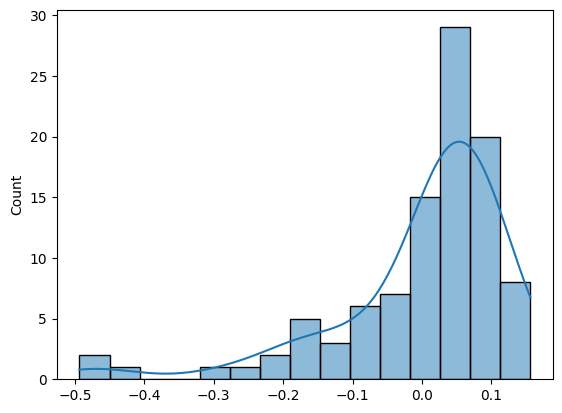

In [ ]:
sns.histplot(st, kde=True)

In [ ]:
m.predict(X_test)

array([0.37219302, 0.43975808, 0.474861  , 0.47304056, 0.45537795,
       0.24924836, 0.27307389, 0.37863075, 0.37925368, 0.31489431,
       0.53104952, 0.41891461, 0.43677259, 0.44756224, 0.38270874,
       0.30980672])

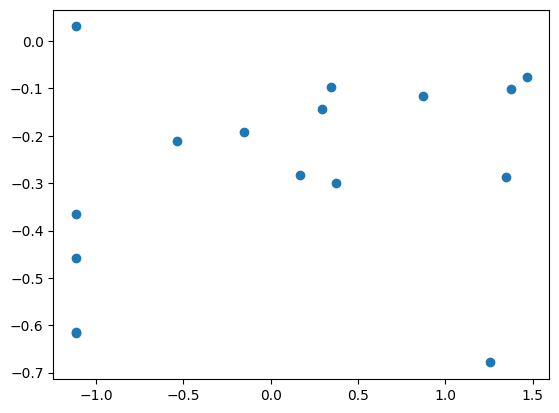

In [ ]:
plt.scatter(y_test, m.predict(X_test))

In [ ]:
a = y>=15
b = (y>=10) & (y<15)
c = (y>=5) & (y<10)
d = (y<=5)
y[a] = 3
y[b] = 2
y[c] = 1
y[d] = 0
y


0    0.0000
1    2.0000
2    0.0000
3    0.0000
4    0.0000
      ...  
59   0.0000
60   0.0000
61   0.0000
62   0.0000
63   0.0000
Length: 64, dtype: float64

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=10000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1), ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)
# y = (y-y.min())/(y.max()-y.min())
# X.loc[:, cat_features] = X.loc[:, cat_features].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y)
m.fit(X_train, y_train)
m.score(X_test, y_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
5000:	learn: 0.0539011	total: 21.4s	remaining: 21.4s
5001:	learn: 0.0538837	total: 21.4s	remaining: 21.4s
5002:	learn: 0.0538590	total: 21.4s	remaining: 21.4s
5003:	learn: 0.0538372	total: 21.4s	remaining: 21.4s
5004:	learn: 0.0538050	total: 21.4s	remaining: 21.4s
5005:	learn: 0.0537908	total: 21.4s	remaining: 21.4s
5006:	learn: 0.0537721	total: 21.4s	remaining: 21.4s
5007:	learn: 0.0537473	total: 21.4s	remaining: 21.4s
5008:	learn: 0.0537315	total: 21.4s	remaining: 21.4s
5009:	learn: 0.0537167	total: 21.4s	remaining: 21.4s
5010:	learn: 0.0536933	total: 21.4s	remaining: 21.3s
5011:	learn: 0.0536784	total: 21.4s	remaining: 21.3s
5012:	learn: 0.0536600	total: 21.5s	remaining: 21.3s
5013:	learn: 0.0536439	total: 21.5s	remaining: 21.3s
5014:	learn: 0.0536276	total: 21.5s	remaining: 21.3s
5015:	learn: 0.0536101	total: 21.5s	remaining: 21.3s
5016:	learn: 0.0535951	total: 21.5s	remaining: 21.3s
5017:	learn: 0.0535772	total: 2

0.75

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=1000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
params = [
    'Адипонектин (мкг/мл) 0 мес',
    'Грелин 1 час (нг/мл) 0 мес.1',
    'miR142 (ПЛАЗМА) 0 мес',
    'Лептин 1 час (нг/мл) 0 мес',
    'ADIPOQ 0 мес',
    'Проколлаген 1 типа нг/мл (183-244) 0 мес',
    'Вес 0 мес',
    'ИМТ 0 мес'
]
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1)[params], ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)

# fedot_solver = Fedot(problem="classification", timeout=5, preset='fast_train', n_jobs=-1, logging_level=logging.FATAL)
# result = fedot_solver.fit(X, y)

cv_loo = LeaveOneOut()
y_pred = []
y_true = []
for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
  X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                    X.iloc[test_index, :], \
                                    y[train_index], \
                                    y[test_index]
  m.fit(X_train, y_train)
  y_pred.append(m.predict(X_test))
  y_true.append(y_test)
print(classification_report(y_true, y_pred))

0:	learn: 0.6924033	total: 4.08ms	remaining: 4.08s
1:	learn: 0.6918947	total: 6.93ms	remaining: 3.46s
2:	learn: 0.6913966	total: 9.42ms	remaining: 3.13s
3:	learn: 0.6909883	total: 12.2ms	remaining: 3.03s
4:	learn: 0.6904669	total: 14.7ms	remaining: 2.92s
5:	learn: 0.6898479	total: 17ms	remaining: 2.82s
6:	learn: 0.6892676	total: 19.5ms	remaining: 2.76s
7:	learn: 0.6887439	total: 22ms	remaining: 2.73s
8:	learn: 0.6881737	total: 24.3ms	remaining: 2.67s
9:	learn: 0.6874413	total: 26.4ms	remaining: 2.62s
10:	learn: 0.6868619	total: 29.1ms	remaining: 2.62s
11:	learn: 0.6862904	total: 31.8ms	remaining: 2.62s
12:	learn: 0.6855394	total: 34.2ms	remaining: 2.6s
13:	learn: 0.6851780	total: 36.7ms	remaining: 2.59s
14:	learn: 0.6846980	total: 39.3ms	remaining: 2.58s
15:	learn: 0.6842714	total: 41.9ms	remaining: 2.58s
16:	learn: 0.6837391	total: 44.7ms	remaining: 2.59s
17:	learn: 0.6833668	total: 47.2ms	remaining: 2.58s
18:	learn: 0.6828713	total: 49.6ms	remaining: 2.56s
19:	learn: 0.6822109	total:

KeyboardInterrupt: ignored

In [ ]:
roc_auc_score(y_true, y_pred)

0.5059523809523809

In [ ]:
y_pred = np.array(y_pred).squeeze()

In [ ]:
y_true = np.array(y_true).squeeze()

              precision    recall  f1-score   support

           0       0.57      0.58      0.58        36
           1       0.44      0.43      0.44        28

    accuracy                           0.52        64
   macro avg       0.51      0.51      0.51        64
weighted avg       0.51      0.52      0.51        64



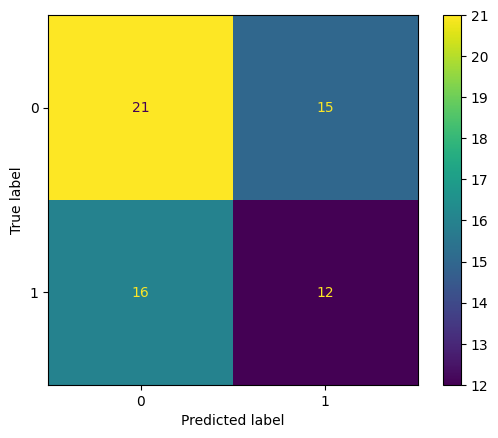

In [ ]:
print(classification_report(y_true, y_pred))
display(ConfusionMatrixDisplay.from_predictions(y_true, y_pred))

In [ ]:
m.save_model("model.bin")

In [ ]:
z= pd.DataFrame(list(zip(m.feature_names_, m.feature_importances_)))
z[z[1]>0].sort_values(by=1, ascending=False)

0       1
1              Грелин 1 час (нг/мл) 0 мес.1 23.1543
2                     miR142 (ПЛАЗМА) 0 мес 20.0316
5  Проколлаген 1 типа нг/мл (183-244) 0 мес 19.3695
0                Адипонектин (мкг/мл) 0 мес 13.5391
3                Лептин 1 час (нг/мл) 0 мес 13.4969
4                              ADIPOQ 0 мес 10.4087

In [ ]:
from catboost import Pool
import shap

In [ ]:
m = catboost.CatBoostClassifier(learning_rate=0.001, iterations=10000)
st = []
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=="SIB"].drop(["Лечение"], 1)
params = [
    'Адипонектин (мкг/мл) 0 мес',
    'Грелин 1 час (нг/мл) 0 мес.1',
    'miR142 (ПЛАЗМА) 0 мес',
    'Лептин 1 час (нг/мл) 0 мес',
    'ADIPOQ 0 мес',
    'Проколлаген 1 типа нг/мл (183-244) 0 мес'
]
X, y = dataset_x.drop(["% потери веса 3 мес", "% потери веса 6 мес"], 1)[params], ((dataset_x["% потери веса 3 мес"]>=5)|(dataset_x["% потери веса 6 мес"]>=5)).astype(int)
m.fit(X, y)

Выходные данные были обрезаны до нескольких последних строк (5000).
5000:	learn: 0.0846661	total: 3.21s	remaining: 3.21s
5001:	learn: 0.0846519	total: 3.21s	remaining: 3.21s
5002:	learn: 0.0846288	total: 3.21s	remaining: 3.21s
5003:	learn: 0.0845934	total: 3.21s	remaining: 3.21s
5004:	learn: 0.0845673	total: 3.21s	remaining: 3.21s
5005:	learn: 0.0845435	total: 3.21s	remaining: 3.21s
5006:	learn: 0.0845307	total: 3.21s	remaining: 3.21s
5007:	learn: 0.0845160	total: 3.21s	remaining: 3.21s
5008:	learn: 0.0844785	total: 3.22s	remaining: 3.2s
5009:	learn: 0.0844484	total: 3.22s	remaining: 3.2s
5010:	learn: 0.0844175	total: 3.22s	remaining: 3.2s
5011:	learn: 0.0843907	total: 3.22s	remaining: 3.2s
5012:	learn: 0.0843757	total: 3.22s	remaining: 3.2s
5013:	learn: 0.0843377	total: 3.22s	remaining: 3.2s
5014:	learn: 0.0843136	total: 3.22s	remaining: 3.2s
5015:	learn: 0.0842855	total: 3.22s	remaining: 3.2s
5016:	learn: 0.0842660	total: 3.22s	remaining: 3.2s
5017:	learn: 0.0842336	total: 3.22s	rema

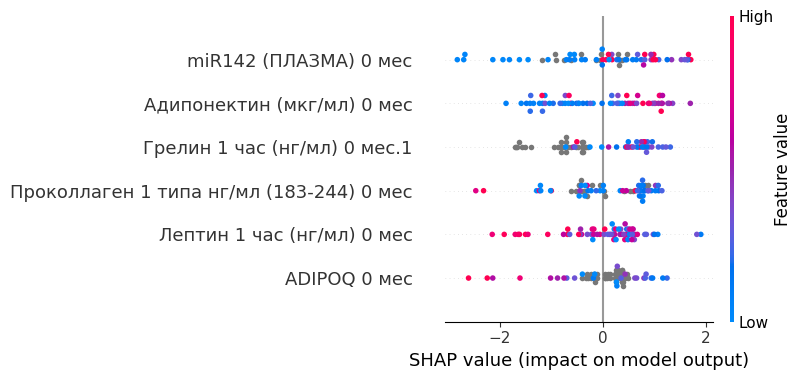

In [ ]:
shap_values = m.get_feature_importance(Pool(X, y), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.summary_plot(shap_values, X)

## Fedot

## Тестирование модели на новых данных

In [ ]:
test_dataset_path = "/content/dataset_almazov_november.xlsx"
if (not os.path.exists(test_dataset_path)):
  !gdown 1mYU2x0NhbIhmuCYAKPSP3Q9345sPlAC1 -O dataset_almazov_november.xlsx
test_dataset = pd.read_excel(test_dataset_path)
test_dataset = test_dataset.loc[125:, :]
test_dataset

ID  Пол 0 - М, 1 - Ж  Выполняли ли ПЭТ 0- нет, 1 - да  \
125  SIB2-01                 0                                1   
126  SIB2-02                 1                                1   
127  SIB2-04                 1                                1   
128  SIB2-05                 0                                1   
129  SIB2-06                 0                                0   
130  SIB2-08                 0                                1   
131  SIB2-10                 1                                0   
132  SIB2-11                 1                                1   
133  SIB2-12                 0                                1   
134  SIB2-13                 1                                0   
135  SIB2-14                 1                                0   
136  SIB2-15                 1                                0   
137  SIB2-16                 1                                0   
138  SIB2-19                 1                                0   
139  SIB2-21                 1                                0   
140  RedF-01                 1                                1   
141  RedF-02                 1                                1   
142  RedF-03                 1                                1   
143  RedF-05                 1                                1   
144  RedF-06                 1                                1   
145  RedF-07                 1                                1   
146  RedF-08                 1                                1   
147  RedF-09                 1                                1   
148  RedF-10                 1                                1   
149  RedF-11                 1                                1   
150  RedF-12                 1                                1   
151  RedF-13                 1                                1   
152  RedF-15                 0                                1   
153  RedF-18                 0                                1   
154  RedF-19                 1                                1   
155  RedF-20                 1                                1   
156  RedF-21                 1                                1   
157  RedF-22                 1                                1   
158  RedF-23                 0                                0   
159  STD2-01                 1                                1   
160  STD2-02                 1                                1   
161  STD2-03                 1                                1   
162  STD2-04                 1                                0   
163  STD2-05                 1                                0   
164  STD2-06                 1                                1   
165  STD2-07                 1                                0   
166  STD2-08                 1                                0   
167  STD2-09                 1                                1   
168  STD2-10                 1                                1   
169  STD2-11                 0                                0   

     Наличие БЖТ исходно по ПЭТ 0 -нет, 1 - да  \
125                                     0.0000   
126                                     0.0000   
127                                     0.0000   
128                                     0.0000   
129                                        NaN   
130                                     0.0000   
131                                        NaN   
132                                     0.0000   
133                                     0.0000   
134                                        NaN   
135                                        NaN   
136                                        NaN   
137                                        NaN   
138                                        NaN   
139                                        NaN   
140                                     0.0000   
141                                     0.0000   
142                        

In [ ]:
def preprocess_dataset(dataset):
  global parameters_truncated
  dataset.loc[:, "Лечение"] = dataset["ID"].apply(lambda x: x[:4])
  dataset = dataset.drop("ID", 1)
  dataset.columns = list(map(lambda x: x.strip(), dataset.columns))
  dataset.columns = list(map(lambda x: " ".join(x.split()), dataset.columns))
  dataset.columns = list(map(lambda i: parameters_truncated[i] if i in parameters_truncated else i, dataset.columns))
  dataset = dataset.loc[~pd.isna(dataset['Вес 3 мес']) | ~pd.isna(dataset['Вес 6 мес'])]
  dataset["% потери веса 3 мес"] = (((dataset["Вес 0 мес"]-dataset["Вес 3 мес"])/dataset["Вес 0 мес"]))*100
  dataset["% потери веса 6 мес"] = (((dataset["Вес 0 мес"]-dataset["Вес 6 мес"])/dataset["Вес 0 мес"]))*100
  dataset[dataset["ИМТ 0 мес"].isna()]["ИМТ 0 мес"] = (dataset[dataset["ИМТ 0 мес"].isna()]["Вес 0 мес"] / dataset[dataset["ИМТ 0 мес"].isna()]["Рост"]**2).round()
  to_drop = []
  for c in dataset.columns:
    for k in ["3 мес", "В2","6 мес", "В.2", "В1", "В1..1", "Депрессия 2", "Респондер", "ПЭТ"]:
      if (c.find(k)!=-1):
        to_drop.append(c)
  to_drop.remove("% потери веса 6 мес")
  to_drop.remove("% потери веса 3 мес")
  dataset = dataset.drop(to_drop, axis=1)
  for c in dataset.columns:
    if (dataset[c].nunique()>20):
      q3 = dataset[c].quantile(q = 0.75, interpolation = 'midpoint')
      q1 = dataset[c].quantile(q = 0.25, interpolation = 'midpoint')
      IQR = q3 - q1
      s = 1.5
      a = q1 - s*IQR
      b = q3 + s*IQR
      dataset.loc[(dataset[c]<a), c] = a
      dataset.loc[(dataset[c]>b), c] = b
  return dataset


In [ ]:
pd.set_option('display.max_columns', None)
test_dataset = preprocess_dataset(test_dataset)

In [ ]:
sib_test_dataset = test_dataset[test_dataset["Лечение"]=="SIB2"].drop("Лечение", 1)
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = sib_test_dataset[targetcol_3]
y_6 = sib_test_dataset[targetcol_6]
treshold = 5
target = (np.max([y_3, y_6], axis=0).round()>treshold).astype(int)
y = target
params=['miR142 (ПЛАЗМА) 0 мес',
            'СРБ',
            'ГИП (пг/мл) 0 мес',
            'Лептин 1 час (нг/мл) 0 мес',
            'Миелопероксидаза нг/мл (˂200) 0 мес', "ИМТ 0 мес"]
X = sib_test_dataset[params]
X = X.reset_index(drop=True)
X

miR142 (ПЛАЗМА) 0 мес     СРБ  ГИП (пг/мл) 0 мес  \
0                     NaN  6.0700           447.5700   
1                     NaN  0.6700           469.1700   
2                     NaN  1.7700                NaN   
3                     NaN  7.9800                NaN   
4                     NaN  1.2900                NaN   
5                     NaN  5.8000                NaN   
6                     NaN  3.8000                NaN   
7                     NaN  2.4500                NaN   
8                     NaN  1.0300                NaN   
9                     NaN  6.0500                NaN   
10                    NaN  7.0700                NaN   
11                    NaN  5.0200                NaN   
12                    NaN  0.9300                NaN   
13                    NaN  0.6100                NaN   
14                    NaN 16.6700                NaN   

    Лептин 1 час (нг/мл) 0 мес  Миелопероксидаза нг/мл (˂200) 0 мес  ИМТ 0 мес  
0                          NaN                                  NaN    41.3500  
1                          NaN                                  NaN    29.1000  
2                          NaN                                  NaN    41.0000  
3                          NaN                                  NaN    37.6500  
4                          NaN                                  NaN    33.5100  
5                          NaN                                  NaN    36.7200  
6                          NaN                                  NaN    43.1000  
7                          NaN                                  NaN    39.4000  
8                          NaN                                  NaN    30.3500  
9                          NaN                                  NaN    43.0000  
10                         NaN                                  NaN    35.7500  
11                         NaN                                  NaN    34.0100  
12                         NaN                                  NaN    30.1100  
13                         NaN                                  NaN    34.0600  
14                         NaN                                  NaN    46.6800

In [ ]:
y

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [ ]:
y_pred = model.predict(X)

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.60      0.50      0.55         6

    accuracy                           0.67        15
   macro avg       0.65      0.64      0.64        15
weighted avg       0.66      0.67      0.66        15



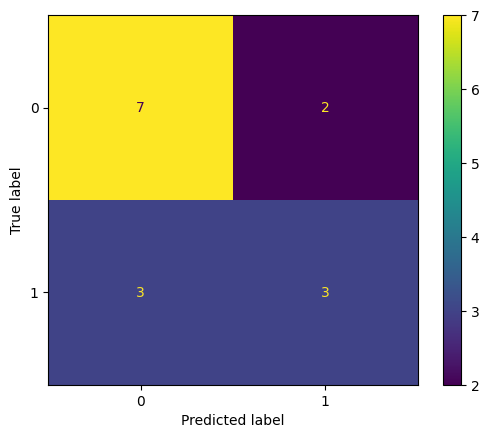

In [ ]:
ConfusionMatrixDisplay.from_predictions(y, y_pred)

In [ ]:
X["y"] = y
X["y_pred"] = y_pred
X

miR142 (ПЛАЗМА) 0 мес     СРБ  ГИП (пг/мл) 0 мес  \
0                     NaN  6.0700           447.5700   
1                     NaN  0.6700           469.1700   
2                     NaN  1.7700                NaN   
3                     NaN  7.9800                NaN   
4                     NaN  1.2900                NaN   
5                     NaN  5.8000                NaN   
6                     NaN  3.8000                NaN   
7                     NaN  2.4500                NaN   
8                     NaN  1.0300                NaN   
9                     NaN  6.0500                NaN   
10                    NaN  7.0700                NaN   
11                    NaN  5.0200                NaN   
12                    NaN  0.9300                NaN   
13                    NaN  0.6100                NaN   
14                    NaN 16.6700                NaN   

    Лептин 1 час (нг/мл) 0 мес  Миелопероксидаза нг/мл (˂200) 0 мес  \
0                          NaN                                  NaN   
1                          NaN                                  NaN   
2                          NaN                                  NaN   
3                          NaN                                  NaN   
4                          NaN                                  NaN   
5                          NaN                                  NaN   
6                          NaN                                  NaN   
7                          NaN                                  NaN   
8                          NaN                                  NaN   
9                          NaN                                  NaN   
10                         NaN                                  NaN   
11                         NaN                                  NaN   
12                         NaN                                  NaN   
13                         NaN                                  NaN   
14                         NaN                                  NaN   

    ИМТ 0 мес  y  y_pred  
0     41.3500  1       0  
1     29.1000  1       1  
2     41.0000  1       0  
3     37.6500  0       0  
4     33.5100  1       1  
5     36.7200  0       0  
6     43.1000  0       0  
7     39.4000  0       0  
8     30.3500  0       1  
9     43.0000  1       0  
10    35.7500  0       0  
11    34.0100  0       0  
12    30.1100  1       1  
13    34.0600  0       1  
14    46.6800  0       0

In [ ]:
explainer.expected_value[0]

0.5441269841269841

In [ ]:
X

miR142 (ПЛАЗМА) 0 мес     СРБ  ГИП (пг/мл) 0 мес  \
0                     NaN  6.0700           447.5700   
1                     NaN  0.6700           469.1700   
2                     NaN  1.7700                NaN   
3                     NaN  7.9800                NaN   
4                     NaN  1.2900                NaN   
5                     NaN  5.8000                NaN   
6                     NaN  3.8000                NaN   
7                     NaN  2.4500                NaN   
8                     NaN  1.0300                NaN   
9                     NaN  6.0500                NaN   
10                    NaN  7.0700                NaN   
11                    NaN  5.0200                NaN   
12                    NaN  0.9300                NaN   
13                    NaN  0.6100                NaN   
14                    NaN 16.6700                NaN   

    Лептин 1 час (нг/мл) 0 мес  Миелопероксидаза нг/мл (˂200) 0 мес  \
0                          NaN                                  NaN   
1                          NaN                                  NaN   
2                          NaN                                  NaN   
3                          NaN                                  NaN   
4                          NaN                                  NaN   
5                          NaN                                  NaN   
6                          NaN                                  NaN   
7                          NaN                                  NaN   
8                          NaN                                  NaN   
9                          NaN                                  NaN   
10                         NaN                                  NaN   
11                         NaN                                  NaN   
12                         NaN                                  NaN   
13                         NaN                                  NaN   
14                         NaN                                  NaN   

    ИМТ 0 мес  y  y_pred  
0     41.3500  1       0  
1     29.1000  1       1  
2     41.0000  1       0  
3     37.6500  0       0  
4     33.5100  1       1  
5     36.7200  0       0  
6     43.1000  0       0  
7     39.4000  0       0  
8     30.3500  0       1  
9     43.0000  1       0  
10    35.7500  0       0  
11    34.0100  0       0  
12    30.1100  1       1  
13    34.0600  0       1  
14    46.6800  0       0

In [ ]:
explanation

In [ ]:
X.drop(["y", "y_pred"], axis=1, inplace=True)

In [ ]:
X

miR142 (ПЛАЗМА) 0 мес     СРБ  ГИП (пг/мл) 0 мес  \
0                     NaN  6.0700           447.5700   
1                     NaN  0.6700           469.1700   
2                     NaN  1.7700                NaN   
3                     NaN  7.9800                NaN   
4                     NaN  1.2900                NaN   
5                     NaN  5.8000                NaN   
6                     NaN  3.8000                NaN   
7                     NaN  2.4500                NaN   
8                     NaN  1.0300                NaN   
9                     NaN  6.0500                NaN   
10                    NaN  7.0700                NaN   
11                    NaN  5.0200                NaN   
12                    NaN  0.9300                NaN   
13                    NaN  0.6100                NaN   
14                    NaN 16.6700                NaN   

    Лептин 1 час (нг/мл) 0 мес  Миелопероксидаза нг/мл (˂200) 0 мес  ИМТ 0 мес  
0                          NaN                                  NaN    41.3500  
1                          NaN                                  NaN    29.1000  
2                          NaN                                  NaN    41.0000  
3                          NaN                                  NaN    37.6500  
4                          NaN                                  NaN    33.5100  
5                          NaN                                  NaN    36.7200  
6                          NaN                                  NaN    43.1000  
7                          NaN                                  NaN    39.4000  
8                          NaN                                  NaN    30.3500  
9                          NaN                                  NaN    43.0000  
10                         NaN                                  NaN    35.7500  
11                         NaN                                  NaN    34.0100  
12                         NaN                                  NaN    30.1100  
13                         NaN                                  NaN    34.0600  
14                         NaN                                  NaN    46.6800

## 3 bins

### 3 bins on target

In [ ]:
def classification_experiment_multi(model, params, medicine="SIB", target_type="C"):
  dataset_x = some_transforms()
  dataset_x = dataset_x[dataset_x["Лечение"]==medicine].drop("Лечение", 1)
  if (target_type == "B"):
    dataset_x = dataset_x[~dataset_x["% потери веса 6 мес"].isna()]

  pipe = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", model)
  ])

  cv_loo = LeaveOneOut()
  targetcol_3 = "% потери веса 3 мес"
  targetcol_6 = "% потери веса 6 мес"
  y_3 = dataset_x[targetcol_3]
  y_6 = dataset_x[targetcol_6]
  if (target_type=="A"):
    target = y_3.astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="B"):
    target = y_6.astype(int).reset_index(drop=True).to_numpy()
  if (target_type=="C"):
    target = np.nanmax([y_3, y_6], axis=0)
  target = np.digitize(target, [-10, 5, 10])
  y = target
  X = dataset_x
  if params!=None:
    X = dataset_x[params]
  X = X.loc[:, ~X.isna().all()]
  X = X.reset_index(drop=True)
  for j in [targetcol_3, targetcol_6]:
    if (j in X.columns):
      X = X.drop(j, axis=1)
  y_pred = []
  y_true = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    try:
      pipe.fit(X_train, y_train)
    except:
      raise Exception(str((X_train, y_train)))
    y_pred.append(pipe.predict(X_test))
    y_true.append(y_test[0])
  y_pred = np.array(y_pred).squeeze().tolist()
  y_true = np.array(y_true).squeeze().tolist()
  return pipe, X, y_true, y_pred

In [ ]:
21/36

0.5833333333333334

In [ ]:
def recursively_delete_params_multi(medicine, set_of_params):
  params_to_eliminate = set_of_params.copy()
  stats = []
  while len(params_to_eliminate)!=0:
    try:
      model, X, y_true, y_pred = classification_experiment_multi(DecisionTreeClassifier(),
                                                                params=params_to_eliminate,
                                                                medicine=medicine,
                                                                target_type="C")
    except:
      break
    statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
    statdf = statdf[statdf[1]>0]
    macro_f1 = classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"]
    stats.append([params_to_eliminate.copy(), macro_f1, len(params_to_eliminate.copy())])
    param_to_remove = statdf.iloc[-1, 0]
    params_to_eliminate.remove(param_to_remove)
    # print("Progress: ", len(set_of_params) - len(params_to_eliminate), " / ", len(set_of_params), "F score ", macro_f1)
  dfstats = pd.DataFrame(stats, columns=["Set of params", "F1", "Count of parameters"])
  dfstats = dfstats.sort_values(by = "F1", ascending=False)
  return dfstats

In [ ]:
t = []
sdpl_copy = sib_default_params_list.copy()
for i in range(5):
  sibstatsdf = recursively_delete_params_multi("SIB", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['HOMA-B', 'Глюкоза', 'СРБ', 'ЛПНП', 'Лептин/Адипонектин 0 мес']




              precision    recall  f1-score   support

           1       0.54      0.67      0.59        33
           2       0.35      0.32      0.33        28
           3       0.25      0.17      0.20        18

    accuracy                           0.43        79
   macro avg       0.38      0.38      0.38        79
weighted avg       0.40      0.43      0.41        79



0      1
1                                  СРБ 0.2010
5                              Инсулин 0.1886
3                miR142 (ПЛАЗМА) 0 мес 0.1701
4           Лептин 1 час (нг/мл) 0 мес 0.1688
0  параксоназа мкг/мл (0,56-8,2) 0 мес 0.1551
2         Грелин 1 час (нг/мл) 0 мес.1 0.1164

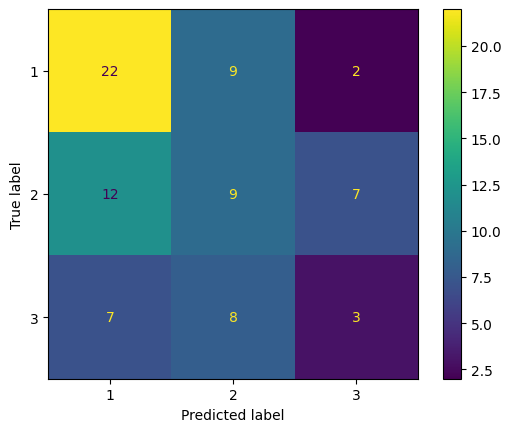

In [ ]:
# model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SIB", params = ['СРБ', 'ЛПНП', 'Лептин/Адипонектин 0 мес', 'Глюкоза', 'OXC'], target_type="C")
model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SIB", params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин'], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

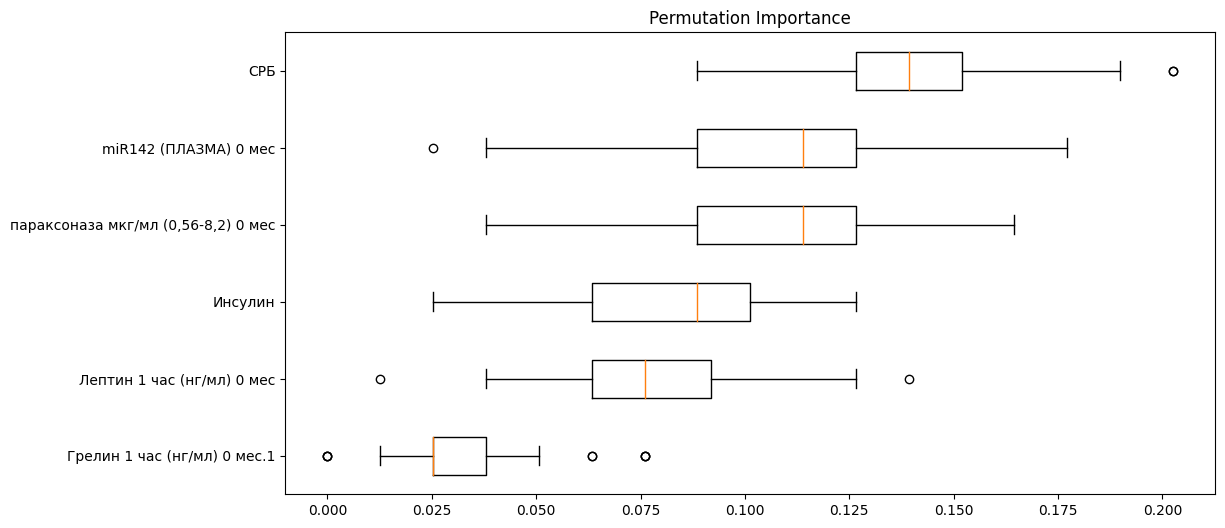

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

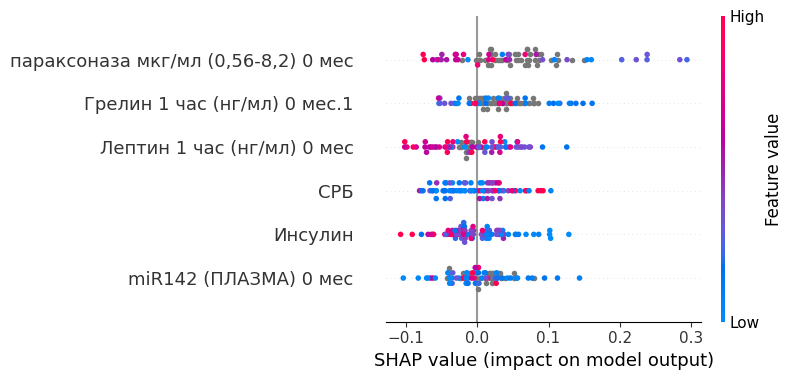

In [ ]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

SAX

In [ ]:
t = []
sdpl_copy = sax_default_params_list.copy()
for i in range(3):
  sibstatsdf = recursively_delete_params_multi("SAX", sdpl_copy)
  best_param = sibstatsdf[sibstatsdf["Count of parameters"]==1]["Set of params"].iloc[0][0]
  sdpl_copy.remove(best_param)
  t.append(best_param)
print(t)

['HOMA-B', 'ГПП 1 нг/мл 0 мес', 'Креатинин мкмоль/л (53-106) 0 мес']




              precision    recall  f1-score   support

           1       0.71      0.83      0.77        12
           2       0.57      0.57      0.57         7
           3       0.67      0.50      0.57         8

    accuracy                           0.67        27
   macro avg       0.65      0.63      0.64        27
weighted avg       0.66      0.67      0.66        27



0      1
0                             HOMA-B 0.2001
3                               ЛПНП 0.1930
2                  ГПП 1 нг/мл 0 мес 0.1841
5                          ИМТ 0 мес 0.1693
4  Креатинин мкмоль/л (53-106) 0 мес 0.1387
1                              Пульс 0.1148

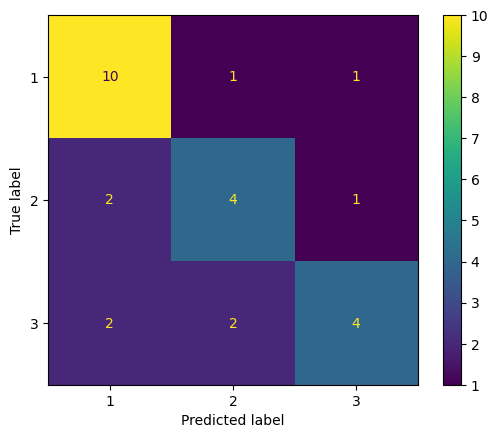

In [ ]:
model, X, y_true, y_pred = classification_experiment_multi(RandomForestClassifier(), medicine="SAX",
        params = ['HOMA-B', 'Пульс', 'ГПП 1 нг/мл 0 мес', 'ЛПНП', 'Креатинин мкмоль/л (53-106) 0 мес', 'ИМТ 0 мес'], target_type="C")
statdf = pd.DataFrame(list(zip(model[:-1].get_feature_names_out(), model[-1].feature_importances_))).sort_values(by=1, ascending=False)
statdf = statdf[statdf[1]>0]
print("\n")
print(classification_report(y_true, y_pred))
display(statdf)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

Text(0.5, 1.0, 'Permutation Importance')

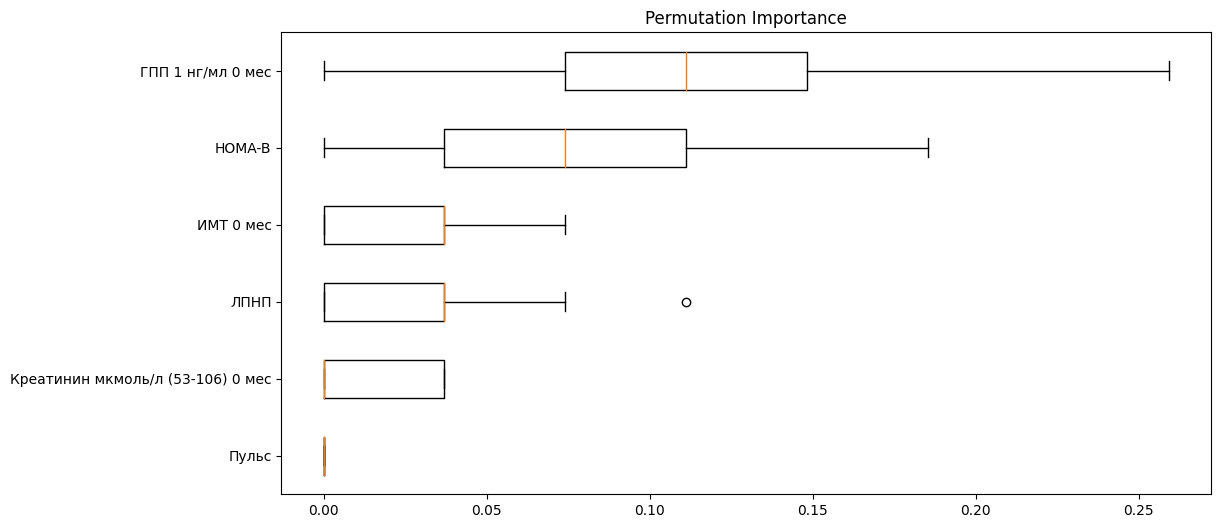

In [ ]:
feature_importance =  model[-1].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
result = permutation_importance(
    model, X, y_true, n_repeats=100
)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=model[:-1].get_feature_names_out()[sorted_idx],
)
plt.title("Permutation Importance")

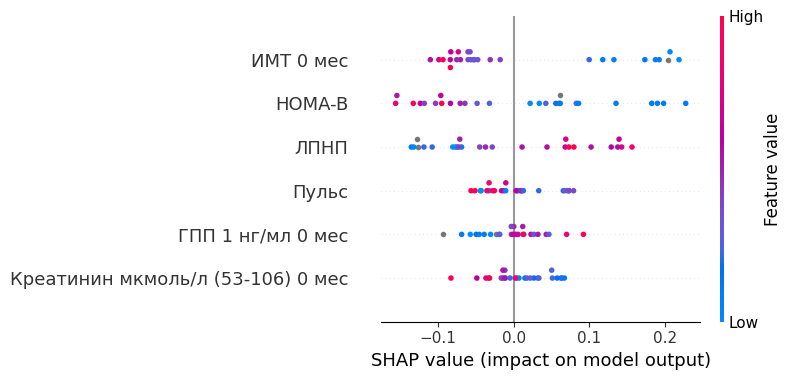

In [ ]:
explainer = shap.TreeExplainer(model[-1])
shap_values = explainer(X)
shap.summary_plot(shap_values[:, :, 1],X)

In [ ]:
!pip install fedot

In [ ]:
import logging
import fedot

In [ ]:
default_predictors = list(filter(lambda x: x not in targets, agroup_parameters)) # список предикторов
def validate_model_fedot(pipe_super, dataset, target="% потери веса 3 мес"):
  target = "% потери веса 3 мес"
  np.random.seed(42)

  # cv
  cv_loo = LeaveOneOut()
  X = dataset.drop(columns=target)
  y = dataset[target]
  y_pred = []
  for idx, (train_index, test_index) in enumerate(cv_loo.split(dataset)):

    X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                      X.iloc[test_index, :], \
                                      y[train_index], \
                                      y[test_index]
    data_fedot_train =
    pipe_super.unfit()
    pipe_super.fit(X_train, y_train)
    y_pred.append(pipe_super.predict(X_test))

  # intervals
  y, y_pred = np.array(y).squeeze(), np.array(y_pred).squeeze()
  mse = (y - y_pred) ** 2
  mae = np.abs(y - y_pred)
  r2 = ((y-y_pred)**2)/((y-np.mean(y))**2)
  print(r2)
  l_mse, r_mse = norm.interval(alpha=0.95, loc=np.mean(mse), scale=np.std(mse))
  l_mae, r_mae = norm.interval(alpha=0.95, loc=np.mean(mae), scale=np.std(mae))
  l_r2, r_r2 = norm.interval(alpha=0.95, loc=np.mean(r2), scale=np.std(r2))

  # binary metrics
  y_label = (y>5).astype(np.int64).squeeze()
  y_pred_label = (y_pred>5).astype(np.int64).squeeze()
  try:
    model_name = pipe_super["regressor"].__class__.__name__
  except:
    try:
      model_name = str(pipe_super)
    except:
      model_name = "Undefined"
  return {
      "model": model_name,
      "date": datetime.now().strftime("%H:%M %d/%m/%y"),
      "r2": r2_score(y, y_pred),
      "interval_explained_variance": (l_r2, r_r2),
      "mae": mean_absolute_error(y, y_pred),
      "interval_mae": (round(max(0, l_mae), 2), round(r_mae, 2)),
      "rmse": mean_squared_error(y, y_pred, squared=False),
      "interval_rmse": (round(max(0, np.sqrt(l_mse)), 2), round(np.sqrt(r_mse), 2)),
      "accuracy": accuracy_score(y_label, y_pred_label),
      "precision": precision_score(y_label, y_pred_label),
      "recall": precision_score(y_label, y_pred_label),
      "rocAUC": roc_auc_score(y_label, y_pred_label),
      "f1": f1_score(y_label, y_pred_label)
  }

In [ ]:
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"]=='SIB'].drop("Лечение", 1)
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = dataset_x[targetcol_3]
y_6 = dataset_x[targetcol_6]
target = (np.nanmax([y_3, y_6], axis=0).round()>=treshold).astype(int)
y = target

X = dataset_x.drop([targetcol_3, targetcol_6], axis=1)
X = X.loc[:, ~X.isna().all()]
X = X.reset_index(drop=True)


NameError: ignored

In [ ]:
fedot_solver = Fedot(problem="regression", timeout=1, preset='fast_train', n_jobs=-1, logging_level=logging.FATAL)
result = fedot_solver.fit(X, y)

NameError: ignored

In [ ]:
validate_model_fedot(result, dataset, target="% потери веса 3 мес")

In [ ]:
if fedot_solver.history and fedot_solver.history.generations:
    print(fedot_solver.history.get_leaderboard())

fedot_solver.current_pipeline.show()

In [ ]:
X_test = X.iloc[:6, :]
y_test = y[:6]
X_test.drop(columns=[target], inplace=True)
X_test

In [ ]:
fedot_solver.predict(X_test)
metrics = fedot_solver.get_metrics()

In [ ]:
fedot_solver.predict(X_test)

In [ ]:
X_test[target]

In [ ]:
metrics

In [ ]:
df[(df.iloc[:, 0]=="SIB") & (df.iloc[:, 1]==0) & (df.iloc[:, 2]==1)].groupby("Успех").count()

Врач  Модель - Сибутрамин  Модель - Саксенда
Успех                                              
0         3                    3                  3
1         8                    8                  8

## Economical efficancy

In [ ]:
target_type="C"
dataset_x = some_transforms()
dataset_x = dataset_x[dataset_x["Лечение"].isin(["SIB", "SAX"])]
treatment = dataset_x["Лечение"]
dataset_x = dataset_x.drop("Лечение", 1)

pipe_sib = Pipeline([
  ("imputer", SimpleImputer()),
  ("regressor", RandomForestClassifier())
])

pipe_sax = Pipeline([
  ("imputer", SimpleImputer()),
  ("regressor", RandomForestClassifier())
])

cv_loo = LeaveOneOut()
targetcol_3 = "% потери веса 3 мес"
targetcol_6 = "% потери веса 6 мес"
y_3 = dataset_x[targetcol_3]
y_6 = dataset_x[targetcol_6]
treshold = 5
target = (np.nanmax([y_3, y_6], axis=0).astype(int)>treshold).astype(int)
y = target
X = dataset_x
sib_params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                  'СРБ',
                  'Грелин 1 час (нг/мл) 0 мес.1',
                  'miR142 (ПЛАЗМА) 0 мес',
                  'Лептин 1 час (нг/мл) 0 мес',
                  'Инсулин']

sax_params = ['ГПП 1 нг/мл 0 мес',
                  'Креатинин мкмоль/л (53-106) 0 мес',
                  'HOMA-B', 'ИМТ 0 мес', "Сартаны"]

X = X.loc[:, ~X.isna().all()]
X = X.reset_index(drop=True)
for j in [targetcol_3, targetcol_6]:
  if (j in X.columns):
    X = X.drop(j, axis=1)
y_pred = []
y_true = []
print(X.shape, y.shape)
for idx, (train_index, test_index) in enumerate(cv_loo.split(X)):
  X_train, X_test, y_train, y_test = X.iloc[train_index, :], \
                                    X.iloc[test_index, :], \
                                    y[train_index], \
                                    y[test_index]
  print()
  patient_treatment = treatment[idx]
  if (patient_treatment == "SIB"):
    model = pipe_sib
  else:
    model = pipe_sax
  model.fit(X_train, y_train)
  y_pred.append(pipe.predict(X_test))
  y_true.append(y_test[0])
  break
y_pred = np.array(y_pred).squeeze()

(106, 169) (106,)



In [ ]:
def sppr_test(idx, X_input, y_input, treatment):
  X = X_input.copy()
  y = y_input.copy()
  test_sample = X.loc[idx]
  test_medicine = treatment.values[idx]
  test_success = y[idx]
  treatment_tmp = treatment.values.copy()

  sib_params = ['параксоназа мкг/мл (0,56-8,2) 0 мес',
                    'СРБ',
                    'Грелин 1 час (нг/мл) 0 мес.1',
                    'miR142 (ПЛАЗМА) 0 мес',
                    'Лептин 1 час (нг/мл) 0 мес',
                    'Инсулин']

  sax_params = ['ГПП 1 нг/мл 0 мес',
                    'Креатинин мкмоль/л (53-106) 0 мес',
                    'HOMA-B', 'ИМТ 0 мес', "Сартаны"]

  tmp_X = X.drop(idx)
  tmp_y = np.delete(y, idx, 0)
  treatment_tmp = np.delete(treatment_tmp, idx, 0)

  model_sib_tmp = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", RandomForestClassifier())
  ])
  model_sax_tmp = Pipeline([
    ("imputer", SimpleImputer()),
    ("regressor", RandomForestClassifier())
  ])

  model_sib_tmp.fit(tmp_X.loc[treatment_tmp=="SIB", sib_params], tmp_y[treatment_tmp=="SIB"])
  model_sax_tmp.fit(tmp_X.loc[treatment_tmp=="SAX", sax_params], tmp_y[treatment_tmp=="SAX"])
  sib_solution = model_sib_tmp.predict([test_sample[sib_params]])[0]
  sax_solution = model_sax_tmp.predict([test_sample[sax_params]])[0]
  return test_medicine, test_success, sib_solution, sax_solution

stats = []
for i in range(X.shape[0]):
  stats.append(sppr_test(i, X, y, treatment))

df = pd.DataFrame(stats, columns=["Врач", "Модель - Сибутрамин", "Модель - Саксенда", "Успех"])
df

Врач  Модель - Сибутрамин  Модель - Саксенда  Успех
0    SIB                    0                  0      1
1    SIB                    1                  1      0
2    SIB                    1                  1      1
3    SIB                    1                  1      1
4    SIB                    0                  1      1
..   ...                  ...                ...    ...
101  SIB                    0                  0      1
102  SIB                    0                  0      1
103  SIB                    1                  1      1
104  SIB                    0                  1      1
105  SIB                    0                  0      1

[106 rows x 4 columns]

In [ ]:
df[(df.iloc[:, 0]=="SAX")].groupby("Успех").count()

Врач  Модель - Сибутрамин  Модель - Саксенда
Успех                                              
0        10                   10                 10
1        17                   17                 17

In [ ]:
df[(df.iloc[:, 0]=="SIB")].groupby("Успех").count()

Врач  Модель - Сибутрамин  Модель - Саксенда
Успех                                              
0        14                   14                 14
1        65                   65                 65

In [ ]:
df[(df.iloc[:, 0]=="SAX") & ((df.iloc[:, 1]==1) & (df.iloc[:, 2]==0))].groupby("Успех").count()

Врач  Модель - Сибутрамин  Модель - Саксенда
Успех                                              
0         2                    2                  2
1         6                    6                  6

In [ ]:
df[(df.iloc[:, 0]=="SAX") & ((df.iloc[:, 1]==0) & (df.iloc[:, 2]==1))].groupby("Успех").count()

Врач  Модель - Сибутрамин  Модель - Саксенда
Успех                                              
0         1                    1                  1
1         2                    2                  2

In [ ]:
df[(df.iloc[:, 0]=="SIB") & (df.iloc[:, 1]==1) & (df.iloc[:, 2]==0)].groupby("Успех").count()

Врач  Модель - Сибутрамин  Модель - Саксенда
Успех                                              
0         3                    3                  3
1        11                   11                 11